In [ ]:
!pip install -q transformers torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 148.7 MB/s eta 0:00:00


In [ ]:
import os
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

warnings.filterwarnings("ignore")

# Detect Colab & mount Drive if needed
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    # Prefer the Shared Drive if present, else fallback to MyDrive
    shared = Path("/content/drive/Shareddrives/Bank of England - Project")
    mydrive = Path("/content/drive/MyDrive/Bank of England - Project")
    PROJECT_ROOT = shared if shared.exists() else mydrive
else:
    PROJECT_ROOT = Path(".").resolve()

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "emotion_temporal"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TRANSCRIPTS_PATH = PROCESSED_DIR / "transcripts_clean.csv"
OPTIONAL_MODEL_SCORES = PROCESSED_DIR / "deberta_earnings_analysis.csv"

assert TRANSCRIPTS_PATH.exists(), f"Missing {TRANSCRIPTS_PATH}, did you run preprocessing?"
print("Using project root:", PROJECT_ROOT)
print("Found transcripts:", TRANSCRIPTS_PATH)
print("Optional model scores present:", OPTIONAL_MODEL_SCORES.exists())


Mounted at /content/drive
Using project root: /content/drive/MyDrive/Bank of England - Project
Found transcripts: /content/drive/MyDrive/Bank of England - Project/data/processed/transcripts_clean.csv
Optional model scores present: True


In [ ]:
# --- Finance Sentiment
import pandas as pd
import numpy as np
from pathlib import Path
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ===== Config =====
MODEL_NAME = "ProsusAI/finbert"   # Finance-domain sentiment (pos/neu/neg)
TEXT_COL   = "text_clean"
MAX_LENGTH = 512
STRIDE     = 64
BATCH_SIZE = 8
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Load data =====
df = pd.read_csv(TRANSCRIPTS_PATH)

# Validate required metadata columns
required_meta = ["company", "call_date", "fiscal_quarter", "speaker_role", "exchange_id"]
missing_meta = [c for c in required_meta if c not in df.columns]
if missing_meta:
    raise ValueError(f"Missing required columns in transcripts: {missing_meta}")

if TEXT_COL not in df.columns:
    raise ValueError(f"Expected text column '{TEXT_COL}' not found. Available columns: {list(df.columns)}")

# ----- Quarter normalisation: "Q1 2022" → "2022Q1", keep if already "YYYYQ#"
def normalise_quarter(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # already "YYYYQ#"
    if re.fullmatch(r"\d{4}Q[1-4]", s):
        return s
    # "Q# YYYY"
    m = re.match(r"Q([1-4])\s+(\d{4})", s)
    if m:
        q, y = m.group(1), m.group(2)
        return f"{y}Q{q}"
    # try other loose patterns, else return as-is
    return s

df["fiscal_quarter"] = df["fiscal_quarter"].map(normalise_quarter)

# ===== Model =====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()
id2label = model.config.id2label  # {0:'neutral',1:'positive',2:'negative'} order may vary per model
label2id = {v.lower(): k for k, v in id2label.items()}

# Map indices for stable access
idx_pos = label2id.get("positive")
idx_neg = label2id.get("negative")

if idx_pos is None or idx_neg is None:
    raise RuntimeError(f"Model labels not as expected. Found id2label={id2label}. Need 'positive' and 'negative'.")

# ----- Chunking util -----
def chunk_text(text: str, max_length=512, stride=64):
    enc = tokenizer(
        text,
        return_overflowing_tokens=True,
        truncation=True,
        max_length=max_length,
        stride=stride,
        padding="max_length",          # ← ensure equal-length chunks
        return_tensors="pt"
    )
    if "input_ids" not in enc:
        return []
    n = enc["input_ids"].size(0)
    return [
        {
            "input_ids": enc["input_ids"][i].to(DEVICE),
            "attention_mask": enc["attention_mask"][i].to(DEVICE)
        }
        for i in range(n)
    ]

@torch.no_grad()
def polarity_score(text: str) -> float:
    """Return P(pos) - P(neg) averaged across chunks. Near 0 for neutral, small +/- for lean."""
    if not isinstance(text, str) or not text.strip():
        return 0.0
    chunks = chunk_text(text, max_length=MAX_LENGTH, stride=STRIDE)
    if not chunks:
        enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH).to(DEVICE)
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)
        return float(probs[idx_pos].item() - probs[idx_neg].item())

    probs_all = []
    for i in range(0, len(chunks), BATCH_SIZE):
        batch = chunks[i:i+BATCH_SIZE]
        input_ids = torch.nn.utils.rnn.pad_sequence([c["input_ids"] for c in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
        attn = torch.nn.utils.rnn.pad_sequence([c["attention_mask"] for c in batch], batch_first=True, padding_value=0)
        logits = model(input_ids=input_ids, attention_mask=attn).logits   # (B, 3)
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        probs_all.append(probs)
        del logits, probs, input_ids, attn
        if DEVICE.type == "cuda":
            torch.cuda.empty_cache()

    probs_all = np.concatenate(probs_all, axis=0)  # (num_chunks, 3)
    # average across chunks, then pos-neg
    mean_probs = probs_all.mean(axis=0)
    return float(mean_probs[idx_pos] - mean_probs[idx_neg])

# ===== Inference =====
scores = []
texts = df[TEXT_COL].fillna("").astype(str).tolist()
for t in texts:
    scores.append(polarity_score(t))

# ===== Build EXACT layout =====
out = pd.DataFrame({
    "company":        df["company"],
    "call_date":      df["call_date"],
    "fiscal_quarter": df["fiscal_quarter"],
    "speaker_role":   df["speaker_role"],
    "exchange_id":    df["exchange_id"],
    "sentiment_score": scores
})

# Enforce exact column order
out = out[["company", "call_date", "fiscal_quarter", "speaker_role", "exchange_id", "sentiment_score"]]

# (Optional) Sort by company/quarter/exchange_id for sanity
sort_cols = [c for c in ["company", "fiscal_quarter", "exchange_id"] if c in out.columns]
if sort_cols:
    out = out.sort_values(sort_cols).reset_index(drop=True)

# Save
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
out.to_csv(OPTIONAL_MODEL_SCORES, index=False)
print("✅ Wrote EXACT-layout CSV →", OPTIONAL_MODEL_SCORES)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Wrote EXACT-layout CSV → /content/drive/MyDrive/Bank of England - Project/data/processed/deberta_earnings_analysis.csv


In [ ]:
import re

# Quarter normalization + sorting utilities

_Q_PATTERNS = [
    # 2024Q1 / 2024-Q1 / 2024 Q1
    re.compile(r"^\s*(20\d{2})[\s\-_]*Q([1-4])\s*$", re.IGNORECASE),
    # Q1 2024 / Q1-2024 / Q1_2024
    re.compile(r"^\s*Q([1-4])[\s\-_]*(20\d{2})\s*$", re.IGNORECASE),
    # 1Q2024 / 1Q 2024 / 1-Q-2024
    re.compile(r"^\s*([1-4])[\s\-_]*Q[\s\-_]*(20\d{2})\s*$", re.IGNORECASE),
    # 1Q24 / Q1 24 / 2024 Q1 with 2-digit year (assume 20YY)
    re.compile(r"^\s*(?:Q)?([1-4])[\s\-_]*([0-9]{2})\s*$", re.IGNORECASE),
    # Q1'24 or Q1 ’24
    re.compile(r"^\s*Q([1-4])\s*['’]\s*([0-9]{2})\s*$", re.IGNORECASE),
]

def normalize_quarter(q, call_date=None):
    """
    Return canonical 'YYYYQn' or np.nan.
    Accepts: '2024Q1', '2024-Q1', 'Q1 2024', '1Q2024', 'Q1 24', "Q1'24", etc.
    Falls back to call_date (datetime) if needed.
    """
    import numpy as np
    if q is None or (isinstance(q, float) and np.isnan(q)):
        # try fallback to call_date
        if call_date is not None and not pd.isna(call_date):
            y = int(call_date.year)
            n = (int(call_date.month) - 1)//3 + 1
            return f"{y}Q{n}"
        return np.nan

    s = str(q).strip()
    if not s:
        # fallback to call_date if present
        if call_date is not None and not pd.isna(call_date):
            y = int(call_date.year)
            n = (int(call_date.month) - 1)//3 + 1
            return f"{y}Q{n}"
        return np.nan

    # Direct canonical already?
    m = re.match(r"^\s*(20\d{2})Q([1-4])\s*$", s, re.IGNORECASE)
    if m:
        return f"{int(m.group(1))}Q{int(m.group(2))}"

    # Try other patterns
    for pat in _Q_PATTERNS:
        m = pat.match(s)
        if m:
            g1, g2 = m.groups()
            # figure out which group is year
            if len(g1) == 4:      # (year, q)
                year, qtr = int(g1), int(g2)
            elif len(g2) == 4:    # (q, year)
                year, qtr = int(g2), int(g1)
            elif len(g1) == 1 and len(g2) == 2:  # (q, yy)
                year, qtr = 2000 + int(g2), int(g1)
            else:
                continue
            return f"{year}Q{qtr}"

    # Fallback: use call_date
    if call_date is not None and not pd.isna(call_date):
        y = int(call_date.year)
        n = (int(call_date.month) - 1)//3 + 1
        return f"{y}Q{n}"

    return np.nan


def quarter_sort_key(q):
    """
    Sorter that works on anything parseable by normalize_quarter.
    Unknowns go to the end.
    """
    norm = normalize_quarter(q)
    if isinstance(norm, str) and re.match(r"^20\d{4}$", norm.replace("Q","")) is None:
        # just in case: norm is like '2024Q1'
        pass
    if isinstance(norm, str) and "Q" in norm:
        y, n = norm.split("Q")
        try:
            return (int(y), int(n))
        except:
            pass
    return (9999, 9)


def sort_quarter_series(quart_series: pd.Series) -> pd.Series:
    """
    Return the same series but with a Categorical dtype ordered by quarter_sort_key.
    """
    vals = quart_series.astype(str).unique()
    order = sorted(vals, key=quarter_sort_key)
    return pd.Categorical(quart_series, categories=order, ordered=True)

In [ ]:
df = pd.read_csv(TRANSCRIPTS_PATH)
df["call_date"] = pd.to_datetime(df["call_date"], errors="coerce")

required = [
    "company", "call_date", "fiscal_quarter",
    "speaker_name", "speaker_role", "text_clean", "exchange_id"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in transcripts_clean.csv: {missing}")

# Robust fiscal_quarter normalization (uses call_date as fallback)
df["fiscal_quarter"] = df.apply(
    lambda r: normalize_quarter(r.get("fiscal_quarter"), r.get("call_date")),
    axis=1
)

# Role normalisation
role_map = {
    "Exec":"Executive","executive":"Executive","Management":"Executive",
    "CEO":"Executive","CFO":"Executive","COO":"Executive","IR":"Executive",
    "Analyst":"Analyst","analyst":"Analyst"
}
df["speaker_role"] = df["speaker_role"].map(lambda x: role_map.get(str(x), x))
df = df[df["speaker_role"].isin(["Executive","Analyst"])].copy()

print("Rows:", len(df))
print("Companies:", df["company"].nunique())
print("Quarters:", df["fiscal_quarter"].nunique())
try:
    display(df.head(3))
except NameError:
    print(df.head(3))

Rows: 2990
Companies: 5
Quarters: 12


company  call_date fiscal_quarter       speaker_name speaker_role  \
0     UBS 2022-04-26         2022Q1  Kian Abouhossei n      Analyst   
1     UBS 2022-04-26         2022Q1       Ralph Hamers    Executive   
2     UBS 2022-04-26         2022Q1       Kirt Gardner    Executive   

                                          text_clean      exchange_id  
0  Yes. Thank you very much for taking my questio...  UBS-Q1-2022-001  
1  Okay. Thank you, Kian. I'm sure Kirt is going ...  UBS-Q1-2022-001  
2  Yeah. Thank you, Ralph. So, Kian , I would jus...  UBS-Q1-2022-001

In [ ]:
from pathlib import Path

def _is_usable_scores(df_scores: pd.DataFrame) -> bool:
    if df_scores is None or df_scores.empty:
        return False
    need = {"company","fiscal_quarter","speaker_role","exchange_id","sentiment_score"}
    if not need.issubset(df_scores.columns):
        return False
    s = pd.to_numeric(df_scores["sentiment_score"], errors="coerce")
    # reject if all-NaN, all-zero, or almost-constant
    if s.isna().all():
        return False
    if (s.fillna(0) == 0).all():
        return False
    if s.std(skipna=True) < 1e-6:
        return False
    return True

def _keyword_heuristic(frame: pd.DataFrame) -> pd.DataFrame:
    POS = {"strong","confident","growth","improve","optimistic","solid","positive","resilient"}
    NEG = {"risk","concern","uncertain","weak","decline","loss","negative","challenge","volatility","headwind"}
    def simple_sentiment(s):
        if not isinstance(s,str): return 0.0
        toks = s.lower().split()
        return (sum(t in POS for t in toks) - sum(t in NEG for t in toks)) / max(len(toks),1)
    out = frame.copy()
    out["sentiment_score"] = out["text_clean"].apply(simple_sentiment)
    return out[["company","call_date","fiscal_quarter","speaker_role","exchange_id","sentiment_score"]]

def _try_hf_models(frame: pd.DataFrame) -> pd.DataFrame | None:
    """
    Try a finance model first, then a general model.
    Return None if both fail (network/private model/etc).
    """
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
        import torch

        candidates = [
            # finance-specific
            ("ProsusAI/finbert", {"pos": 1, "neg": -1, "neutral": 0}),
            # general (falls back to POSITIVE/NEGATIVE)
            ("cardiffnlp/twitter-roberta-base-sentiment-latest", {"positive": 1, "negative": -1, "neutral": 0}),
        ]
        device = 0 if torch.cuda.is_available() else -1

        texts = frame["text_clean"].astype(str).tolist()
        results = None

        for model_id, label_map in candidates:
            try:
                tok = AutoTokenizer.from_pretrained(model_id)
                mdl = AutoModelForSequenceClassification.from_pretrained(model_id)
                pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, device=device, truncation=True)
                # batched inference for speed
                preds = pipe(texts, batch_size=32, truncation=True)
                # to score in [-1, 1] using label probabilities if available
                scores = []
                for p in preds:
                    # p can be a dict with 'label' and 'score', or a list of dicts with all labels
                    if isinstance(p, list):
                        # convert to prob dict
                        lab2prob = {d["label"].lower(): float(d["score"]) for d in p}
                        score = 0.0
                        for k, w in label_map.items():
                            if k in lab2prob:
                                score += w * lab2prob[k]
                        scores.append(float(score))
                    else:
                        lbl = str(p.get("label","")).lower()
                        scr = float(p.get("score", 0.0))
                        # signed score using single label confidence
                        scores.append(float(label_map.get(lbl, 0)) * scr)

                out = frame[["company","call_date","fiscal_quarter","speaker_role","exchange_id"]].copy()
                out["sentiment_score"] = pd.to_numeric(scores, errors="coerce")
                results = out
                if _is_usable_scores(results):
                    print(f"Built model scores with: {model_id}")
                    return results
                else:
                    print(f"Scores from {model_id} looked degenerate; trying next model…")
            except Exception as e:
                print(f"Skipping {model_id}: {e}")
                continue
        return results
    except Exception as e:
        print(f"HF pipeline unavailable: {e}")
        return None
try:
    normalize_quarter
except NameError:
    try:
        normalize_quarter = normalise_quarter  # alias the FinBERT helper if defined
    except NameError:
        pass  # utilities cell later will define normalize_quarter

print("Model scores file present on disk:", OPTIONAL_MODEL_SCORES.exists())

ms = None
loaded_existing = False
if OPTIONAL_MODEL_SCORES.exists():
    try:
        tmp = pd.read_csv(OPTIONAL_MODEL_SCORES)
        # harmonise common variants if present
        tmp = tmp.rename(columns={"date":"call_date","bank_name":"company","quarter":"fiscal_quarter"})
        # coerce dates (ok if NaT)
        if "call_date" in tmp.columns:
            tmp["call_date"] = pd.to_datetime(tmp["call_date"], errors="coerce")
        # ensure quarter shape
        if "fiscal_quarter" in tmp.columns:
            tmp["fiscal_quarter"] = tmp.apply(
                lambda r: normalize_quarter(r.get("fiscal_quarter"), r.get("call_date")),
                axis=1
            )
        # ensure required keys exist
        for col in ["company","fiscal_quarter","speaker_role","exchange_id"]:
            if col not in tmp.columns and col in df.columns:
                if col == "exchange_id":
                    # merge it in
                    tmp = tmp.merge(
                        df[["company","call_date","speaker_role","exchange_id"]].drop_duplicates(),
                        on=[c for c in ["company","call_date","speaker_role"] if c in tmp.columns],
                        how="left"
                    )
                else:
                    tmp[col] = df[col]
        if "sentiment_score" not in tmp.columns:
            print("Existing scores unusable (no 'sentiment_score').")
        elif not _is_usable_scores(tmp):
            print("Existing scores present but degenerate (all zeros/NaN/constant).")
        else:
            ms = tmp[["company","call_date","fiscal_quarter","speaker_role","exchange_id","sentiment_score"]].copy()
            loaded_existing = True
            print("Using existing non-degenerate sentiment scores.")
    except Exception as e:
        print(f"Could not read existing scores: {e}")

if ms is None:
    print("Building sentiment scores…")
    # 1) try HF models
    ms_try = _try_hf_models(df)
    if ms_try is not None and _is_usable_scores(ms_try):
        ms = ms_try
    else:
        print("Falling back to keyword heuristic.")
        ms = _keyword_heuristic(df)

    # write out for reuse
    safe_out = PROCESSED_DIR / "deberta_earnings_analysis.csv"
    ms.to_csv(safe_out, index=False)
    print(f"Saved fresh scores to: {safe_out}")

# Final guard: if still degenerate, force heuristic
if not _is_usable_scores(ms):
    print("Final guard triggered: replacing degenerate scores with heuristic.")
    ms = _keyword_heuristic(df)

# tiny print
print("Score sample:")
try:
    display(ms.head(8))
except NameError:
    print(ms.head(8).to_string(index=False))

Model scores file present on disk: True
Using existing non-degenerate sentiment scores.
Score sample:


company  call_date fiscal_quarter speaker_role  \
0  CreditSuisse 2022-04-28         2022Q1     Operator   
1  CreditSuisse 2022-04-28         2022Q1    Executive   
2  CreditSuisse 2022-04-28         2022Q1    Executive   
3  CreditSuisse 2022-04-28         2022Q1    Executive   
4  CreditSuisse 2022-04-28         2022Q1    Executive   
5  CreditSuisse 2022-04-28         2022Q1    Executive   
6  CreditSuisse 2022-04-28         2022Q1     Operator   
7  CreditSuisse 2022-04-28         2022Q1      Analyst   

                exchange_id  sentiment_score  
0  CreditSuisse-Q1-2022-001         0.068223  
1  CreditSuisse-Q1-2022-001         0.010447  
2  CreditSuisse-Q1-2022-001         0.433283  
3  CreditSuisse-Q1-2022-001        -0.327015  
4  CreditSuisse-Q1-2022-001         0.333094  
5  CreditSuisse-Q1-2022-001         0.014042  
6  CreditSuisse-Q1-2022-002         0.032821  
7  CreditSuisse-Q1-2022-002         0.102587

In [ ]:
# === Block 5 (robust): exchange aggregation + z-scaling + adaptive cuts + percentile fallbacks ===

# 1) Aggregate to exchange × role on raw scores
ex_role_raw = (
    ms.groupby(["company","fiscal_quarter","exchange_id","speaker_role"], dropna=True)
      .agg(mean_sent=("sentiment_score","mean"),
           n_turns=("sentiment_score","size"))
      .reset_index()
)

# 2) Z-score per (company, quarter, role) to normalise tiny model ranges
#    + winsorise to tame outliers
def _zscore_winsorise(s: pd.Series, zclip=3.0):
    mu = s.mean()
    sd = s.std(ddof=0)
    if not np.isfinite(sd) or sd == 0:
        z = (s - mu)  # all zeros; harmless
    else:
        z = (s - mu) / (sd + 1e-6)
    return z.clip(-zclip, zclip)

ex_role = ex_role_raw.copy()
ex_role["mean_sent_z"] = (
    ex_role.groupby(["company","fiscal_quarter","speaker_role"])["mean_sent"]
           .transform(_zscore_winsorise)
)

# 3) Pivot to Analyst/Executive side-by-side on z-scores
ex_pivot = ex_role.pivot_table(
    index=["company","fiscal_quarter","exchange_id"],
    columns="speaker_role",
    values=["mean_sent_z","n_turns"]
)
ex_pivot.columns = [f"{a}_{b}" for a,b in ex_pivot.columns]
ex_pivot = ex_pivot.reset_index()

# Ensure expected columns exist; rename to familiar names
for c in ["mean_sent_z_Analyst","mean_sent_z_Executive","n_turns_Analyst","n_turns_Executive"]:
    if c not in ex_pivot.columns:
        ex_pivot[c] = np.nan
ex_pivot = ex_pivot.rename(columns={
    "mean_sent_z_Analyst":   "mean_sent_Analyst",
    "mean_sent_z_Executive": "mean_sent_Executive",
})

# Basic features
ex_pivot["has_both_sides"] = (
    (ex_pivot["n_turns_Analyst"].fillna(0)   >= 1) &
    (ex_pivot["n_turns_Executive"].fillna(0) >= 1)
)
ex_pivot["sent_delta_exec_minus_analyst"] = (
    ex_pivot["mean_sent_Executive"].fillna(0) - ex_pivot["mean_sent_Analyst"].fillna(0)
)
ex_pivot["has_followup"] = (ex_pivot["n_turns_Analyst"].fillna(0) > 1).astype(int)

# --- Adaptive disagreement cut in z-units -----------------------------------
def _mad(x):
    x = np.asarray(x)
    med = np.nanmedian(x)
    return np.nanmedian(np.abs(x - med))

d_all = ex_pivot.loc[ex_pivot["has_both_sides"], "sent_delta_exec_minus_analyst"].dropna().values
global_q20 = np.nanpercentile(d_all, 20) if len(d_all) else -0.25
GLOBAL_FLOOR_Z = min(-0.25, global_q20)  # keep some bite
company_floors = (
    ex_pivot[ex_pivot["has_both_sides"]]
      .groupby("company")["sent_delta_exec_minus_analyst"]
      .apply(lambda s: np.nanpercentile(s, 25) if len(s) else -0.25)
      .to_dict()
)

rows = []
for (co, fq), sub in ex_pivot[ex_pivot["has_both_sides"]].groupby(["company","fiscal_quarter"]):
    vals = sub["sent_delta_exec_minus_analyst"].dropna().values
    if len(vals) >= 4:
        med = np.nanmedian(vals)
        iqr = np.nanpercentile(vals, 75) - np.nanpercentile(vals, 25)
        mad = _mad(vals)
        c1 = np.nanpercentile(vals, 25) - 1.5 * iqr
        c2 = med - 0.5 * iqr
        c3 = med - 0.8 * (mad if mad > 0 else np.std(vals) + 1e-6)
        local_cut = np.nanmin([c1, c2, c3])
    else:
        # Borrow from company distribution if quarter too small
        cf = company_floors.get(co, GLOBAL_FLOOR_Z)
        local_cut = np.nanmin([cf, GLOBAL_FLOOR_Z])
    rows.append((co, fq, local_cut))

local_cuts = pd.DataFrame(rows, columns=["company","fiscal_quarter","local_cut"])
ex_pivot = ex_pivot.merge(local_cuts, on=["company","fiscal_quarter"], how="left")
ex_pivot["local_cut"] = ex_pivot["local_cut"].fillna(GLOBAL_FLOOR_Z)

# --- Primary rules -----------------------------------------------------------
base_rule = ex_pivot["sent_delta_exec_minus_analyst"] < ex_pivot["local_cut"]

support_rule_1 = (
    (ex_pivot["sent_delta_exec_minus_analyst"] < (ex_pivot["local_cut"] * 0.9)) &
    (ex_pivot["has_followup"] == 1)
)

# Exec notably negative vs analyst ~neutral-or-better (z-units)
support_rule_2 = (
    (ex_pivot["mean_sent_Analyst"].fillna(0)   > -0.10) &
    (ex_pivot["mean_sent_Executive"].fillna(0) < -0.35)
)

ex_pivot["flag_disagreement_like"] = ((base_rule) | support_rule_1 | support_rule_2).astype(int)

# --- Percentile fallbacks to avoid flat quarters (keeps plots lively) -------
# 1) If a (company, quarter) has zero flags and ≥ 5 exchanges,
#    also flag the bottom max(1, ceil(12% * n)) deltas.
def _apply_quarter_percentile_fallback(g: pd.DataFrame) -> pd.DataFrame:
    n = len(g)
    if n >= 5 and g["flag_disagreement_like"].sum() == 0:
        k = int(np.ceil(0.12 * n))
        k = max(k, 1)
        idx = g["sent_delta_exec_minus_analyst"].nsmallest(k).index
        g.loc[idx, "flag_disagreement_like"] = 1
    return g

ex_pivot = (
    ex_pivot.groupby(["company","fiscal_quarter"], group_keys=False)
            .apply(_apply_quarter_percentile_fallback)
)

# 2) If a company’s overall flag rate is still very low (<7%),
#    soften a bit: also flag any deltas below the company’s 15th percentile.
def _company_soften(g: pd.DataFrame) -> pd.DataFrame:
    rate = g["flag_disagreement_like"].mean()
    if np.isnan(rate) or rate < 0.07:
        vals = g.loc[g["has_both_sides"], "sent_delta_exec_minus_analyst"].dropna()
        if len(vals) >= 10:
            p15 = np.nanpercentile(vals, 15)
            g.loc[g["sent_delta_exec_minus_analyst"] < p15, "flag_disagreement_like"] = 1
    return g

ex_pivot = (
    ex_pivot.groupby("company", group_keys=False)
            .apply(_company_soften)
)

# --- Evasive-like (z-units) with a gentle fallback --------------------------
primary_evasive = (
    (ex_pivot["mean_sent_Analyst"].fillna(0)   < -0.25) &   # analyst notably negative
    (ex_pivot["mean_sent_Executive"].fillna(0) > -0.10) &   # exec closer to neutral
    (ex_pivot["has_followup"] == 1)
)

ex_pivot["flag_evasive_like"] = primary_evasive.astype(int)

# Percentile fallback: in any (company, quarter) with ≥ 8 exchanges and zero evasive flags,
# flag the top 10% of cases where (exec - analyst) is most positive AND analyst is negative.
def _apply_evasive_fallback(g: pd.DataFrame) -> pd.DataFrame:
    n = len(g)
    if n >= 8 and g["flag_evasive_like"].sum() == 0:
        # target: negative analyst, exec relatively higher
        cand = g[(g["mean_sent_Analyst"] < 0)]
        if len(cand) >= 3:
            # sort by (exec - analyst) descending; take top 10%
            k = int(np.ceil(0.10 * len(cand)))
            k = max(k, 1)
            idx = (cand["mean_sent_Executive"] - cand["mean_sent_Analyst"]).nlargest(k).index
            g.loc[idx, "flag_evasive_like"] = 1
    return g

ex_pivot = (
    ex_pivot.groupby(["company","fiscal_quarter"], group_keys=False)
            .apply(_apply_evasive_fallback)
)

# --- Diagnostics -------------------------------------------------------------
print(f"[Diag] Global disagreement floor (z): {GLOBAL_FLOOR_Z:.3f} | "
      f"Company floors median: {np.nanmedian(list(company_floors.values())):.3f} | "
      f"All-deltas q20: {global_q20:.3f}")

print("Disagreement-like flags:", int(ex_pivot["flag_disagreement_like"].sum()), "of", len(ex_pivot))
print("Evasive-like  flags:",    int(ex_pivot["flag_evasive_like"].sum()),    "of", len(ex_pivot))

try:
    d_by_c = (ex_pivot.groupby("company")["flag_disagreement_like"].sum()
              .sort_values(ascending=False))
    e_by_c = (ex_pivot.groupby("company")["flag_evasive_like"].sum()
              .sort_values(ascending=False))
    print("\n[Diag] Disagreement flags by company:\n", d_by_c.to_string())
    print("\n[Diag] Evasive flags by company:\n", e_by_c.to_string())
except Exception:
    pass

# (ex_pivot is used later as-is by the rest of your pipeline)

[Diag] Global disagreement floor (z): -0.877 | Company floors median: -0.733 | All-deltas q20: -0.877
Disagreement-like flags: 152 of 999
Evasive-like  flags: 78 of 999

[Diag] Disagreement flags by company:
 company
JPMorgan         42
Deutsche Bank    36
UBS              34
HSBC             25
CreditSuisse     15

[Diag] Evasive flags by company:
 company
JPMorgan         28
UBS              14
Deutsche Bank    13
HSBC             12
CreditSuisse     11


In [ ]:
# Turn-level averages by role (original view)
agg = (
    ms.groupby(["company","fiscal_quarter","speaker_role"], dropna=True)
      .agg(mean_sentiment=("sentiment_score","mean"),
           n_points=("sentiment_score","size"))
      .reset_index()
)

pivot = (
    agg.pivot_table(index=["company","fiscal_quarter"], columns="speaker_role", values="mean_sentiment")
      .reset_index().rename_axis(None, axis=1)
)

# Exchange-level rates per quarter
ex_quarter = (
    ex_pivot.groupby(["company","fiscal_quarter"])
            .agg(
                exchanges=("exchange_id","nunique"),
                pct_disagreement_like=("flag_disagreement_like","mean"),
                pct_evasive_like=("flag_evasive_like","mean"),
                analyst_followup_rate=("has_followup","mean")
            )
            .reset_index()
)

# Combined quarterly panel
quarter_panel = pivot.merge(ex_quarter, on=["company","fiscal_quarter"], how="left")
quarter_panel = quarter_panel.rename(columns={"Executive":"exec_mean_sent","Analyst":"analyst_mean_sent"})

# Save key outputs
out_long  = OUTPUT_DIR / "emotion_quarterly_by_speaker.csv"
out_wide  = OUTPUT_DIR / "emotion_quarterly_pivot.csv"
ex_feat   = OUTPUT_DIR / "exchange_level_features.csv"
q_panel   = OUTPUT_DIR / "quarter_panel_with_exchange_metrics.csv"

agg.to_csv(out_long, index=False)
pivot.to_csv(out_wide, index=False)
ex_pivot.to_csv(ex_feat, index=False)
quarter_panel.to_csv(q_panel, index=False)

print("Saved:")
print(f"- {out_long}")
print(f"- {out_wide}")
print(f"- {ex_feat}")
print(f"- {q_panel}")

try:
    display(quarter_panel.head(8))
except NameError:
    print(quarter_panel.head(8))


Saved:
- /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/emotion_quarterly_by_speaker.csv
- /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/emotion_quarterly_pivot.csv
- /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exchange_level_features.csv
- /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/quarter_panel_with_exchange_metrics.csv


company fiscal_quarter  analyst_mean_sent  exec_mean_sent  Operator  \
0   CreditSuisse         2022Q1           0.167764        0.106549  0.028420   
1   CreditSuisse         2022Q2           0.086745        0.201981 -0.016090   
2   CreditSuisse         2022Q3           0.056342        0.012517  0.011168   
3   CreditSuisse         2022Q4           0.204115        0.199462  0.012053   
4   CreditSuisse         2023Q1           0.101400        0.141607 -0.064000   
5  Deutsche Bank         2022Q1           0.034472        0.182393       NaN   
6  Deutsche Bank         2022Q2           0.058692        0.175750       NaN   
7  Deutsche Bank         2022Q3           0.091918        0.230346       NaN   

   Unknown  exchanges  pct_disagreement_like  pct_evasive_like  \
0      NaN         14               0.214286          0.142857   
1      NaN         15               0.266667          0.066667   
2      NaN          9               0.333333          0.111111   
3      NaN         16               0.187500          0.250000   
4      NaN         14               0.142857          0.214286   
5      NaN         16               0.187500          0.062500   
6      NaN         19               0.157895          0.052632   
7      NaN         16               0.312500          0.062500   

   analyst_followup_rate  
0               0.714286  
1               0.466667  
2               0.444444  
3               0.875000  
4               0.642857  
5               0.187500  
6               0.210526  
7               0.062500

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_CreditSuisse.png


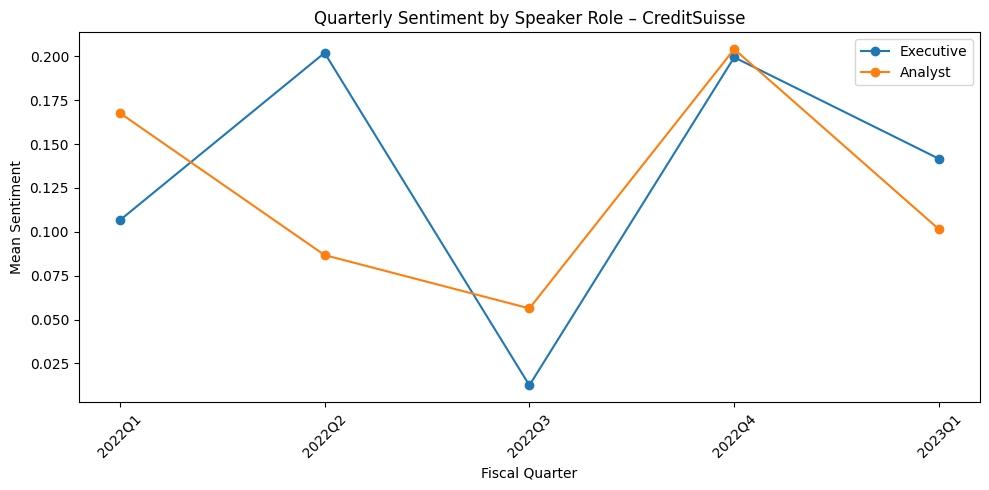

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_CreditSuisse.png


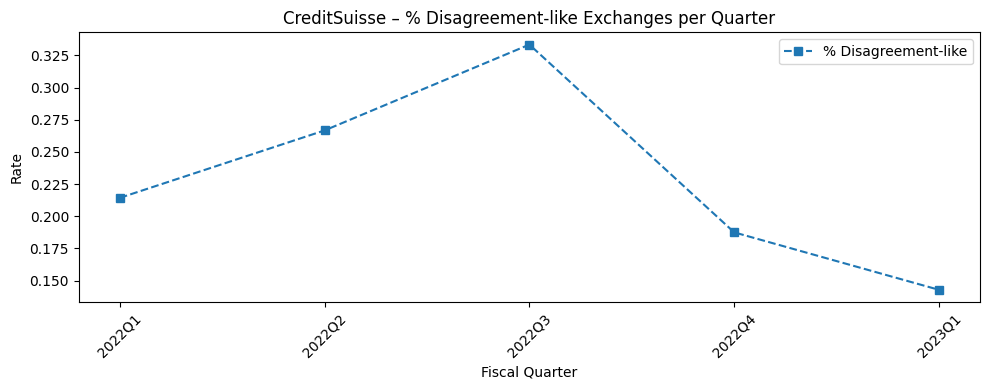

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_CreditSuisse.png


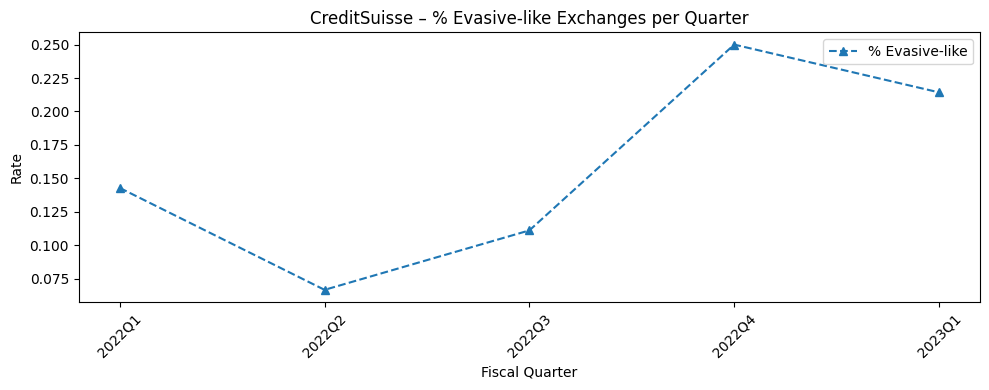

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_Deutsche_Bank.png


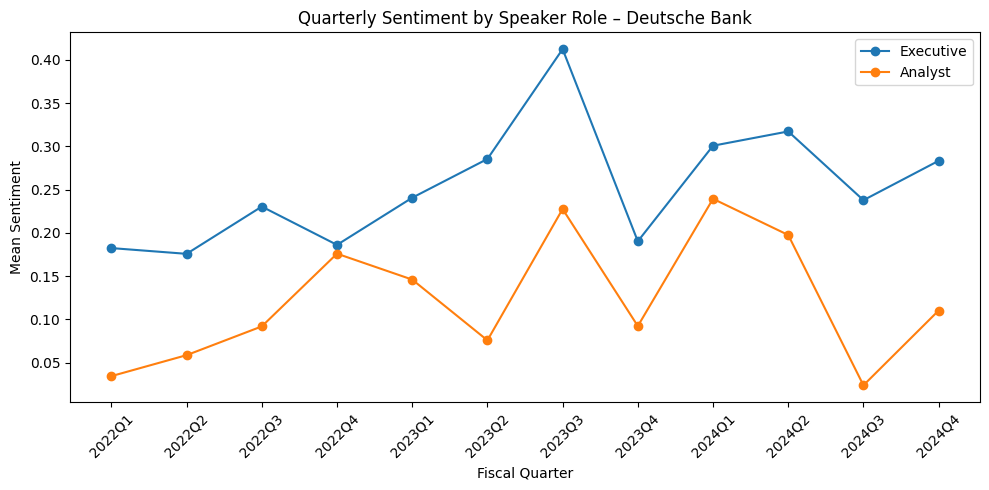

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_Deutsche_Bank.png


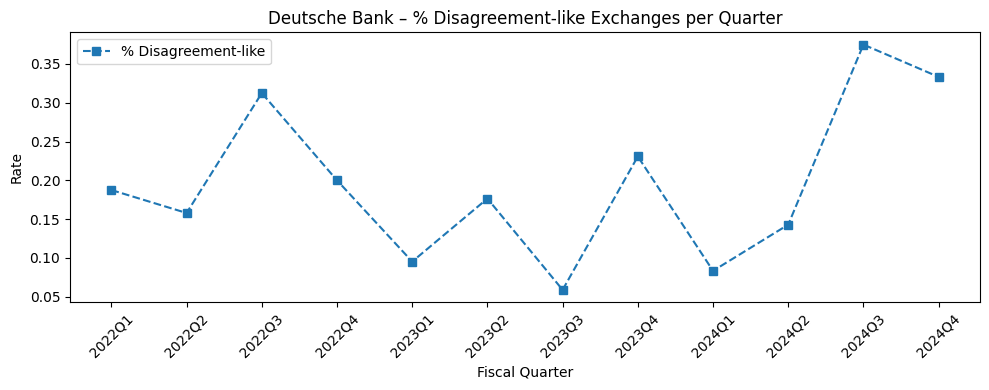

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_Deutsche_Bank.png


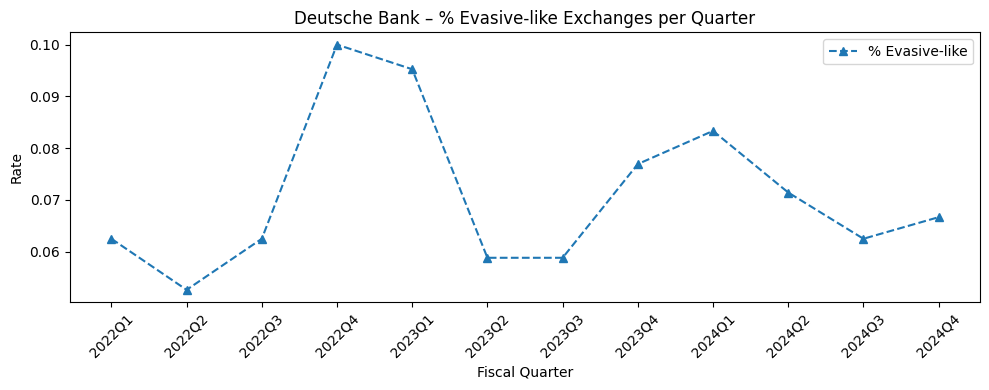

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_HSBC.png


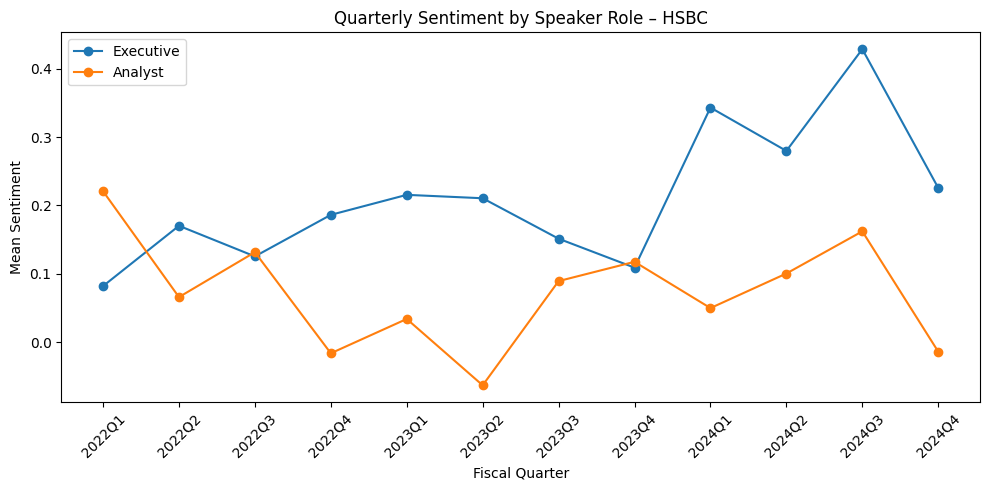

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_HSBC.png


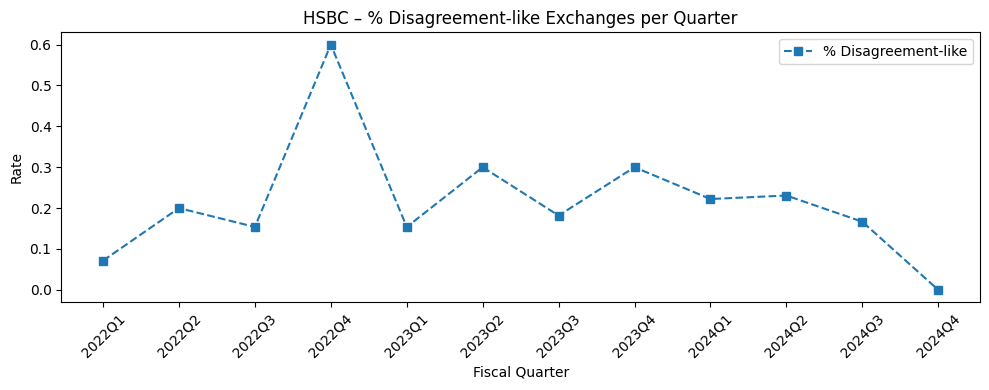

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_HSBC.png


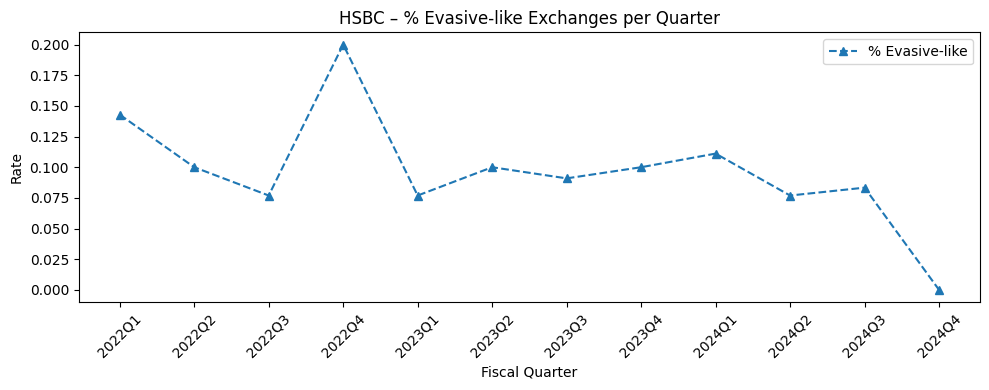

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_JPMorgan.png


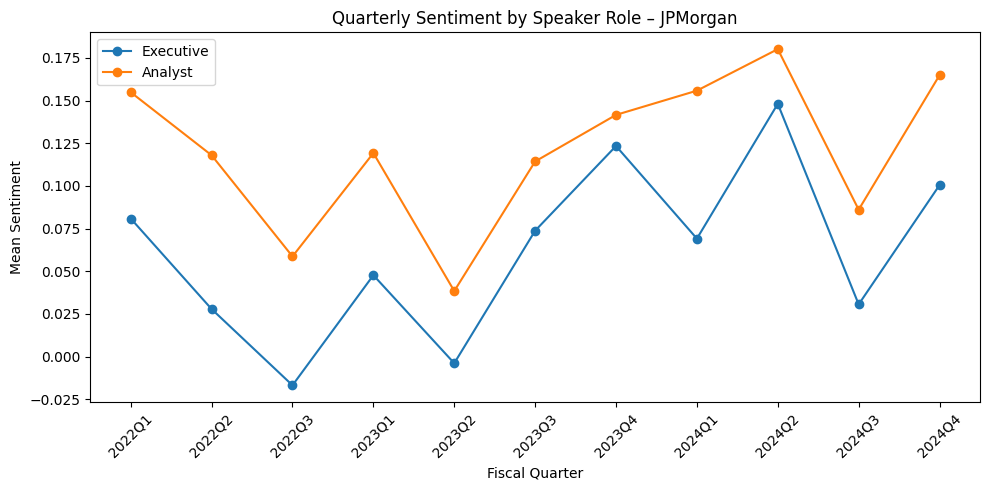

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_JPMorgan.png


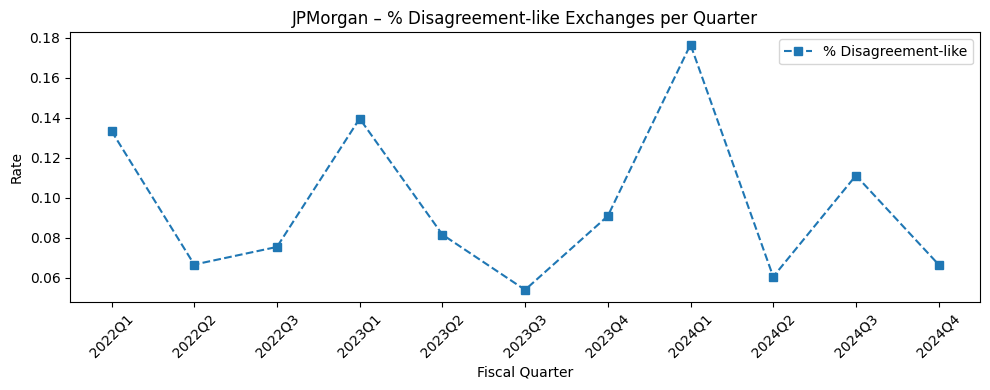

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_JPMorgan.png


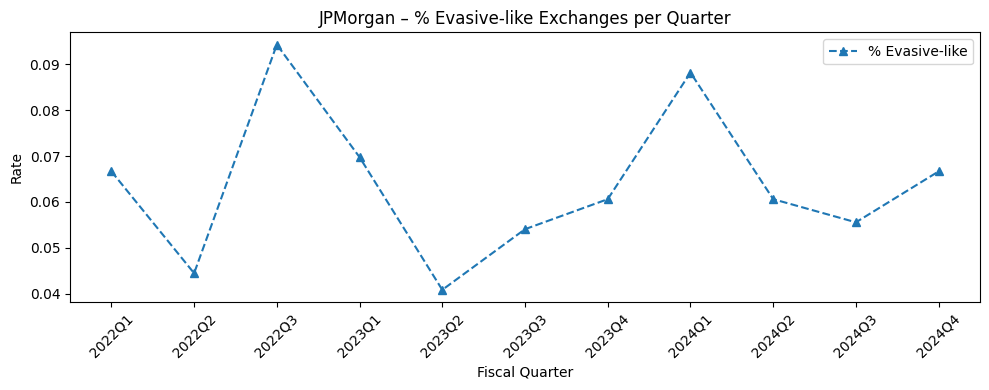

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_UBS.png


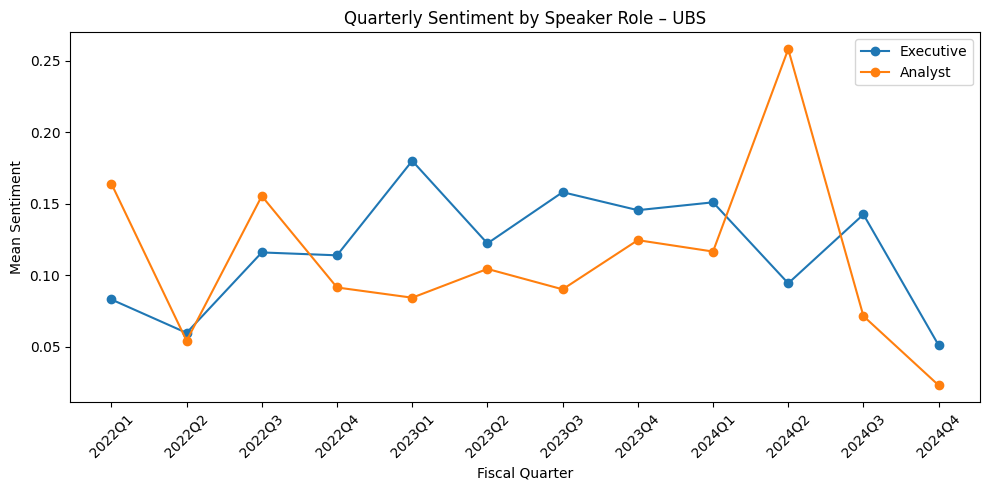

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_UBS.png


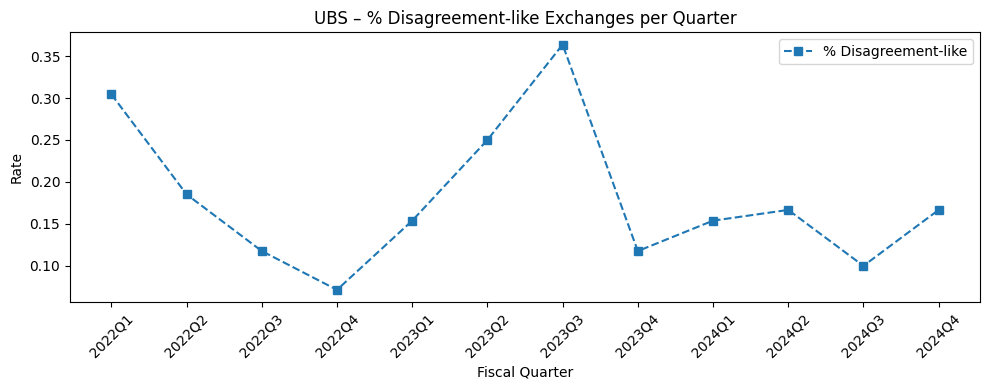

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_UBS.png


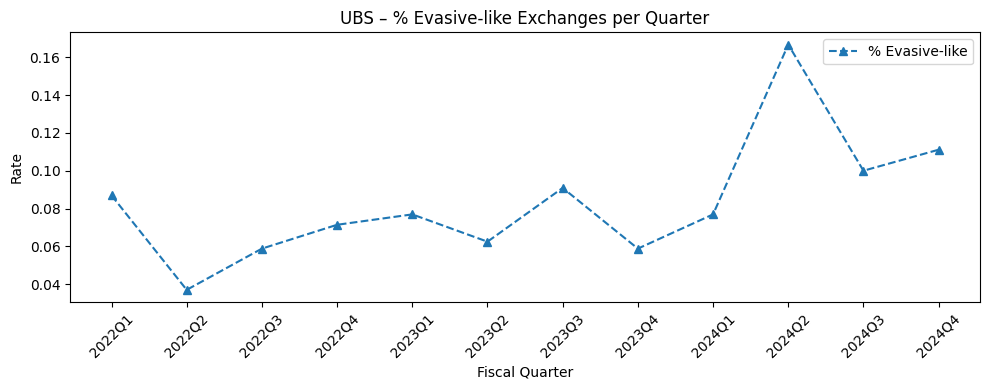

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/trend_overall.png


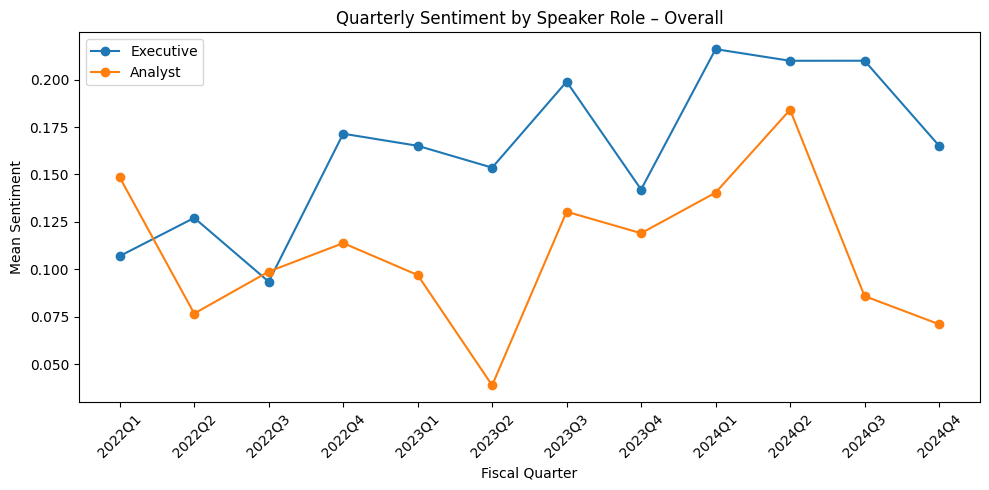

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/disagreement_rate_Overall.png


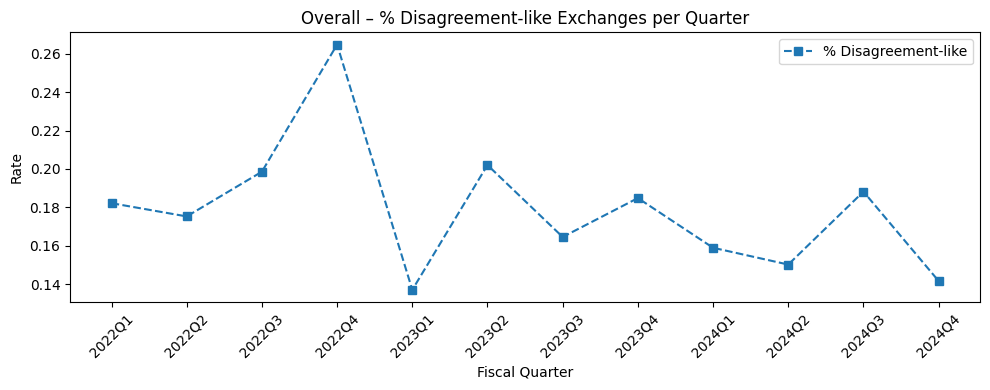

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/evasive_rate_Overall.png


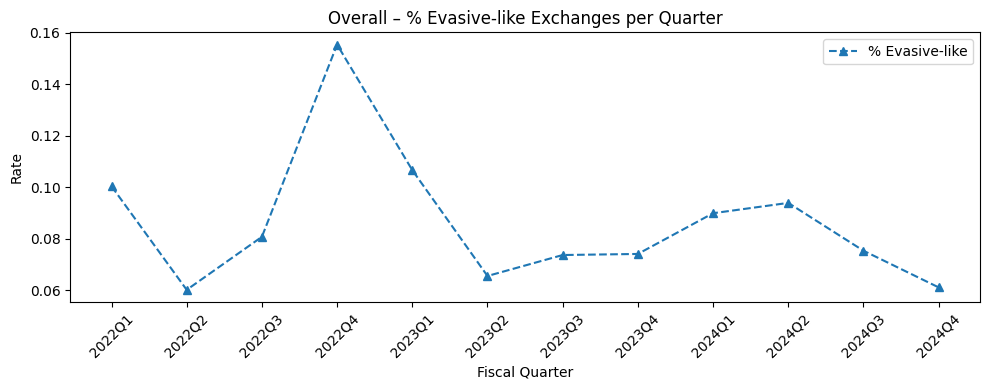

In [ ]:
# Ensure quarter columns are ordered categoricals (consistent sorting everywhere)
if "fiscal_quarter" in pivot.columns:
    pivot["fiscal_quarter"] = sort_quarter_series(pivot["fiscal_quarter"])
if "fiscal_quarter" in quarter_panel.columns:
    quarter_panel["fiscal_quarter"] = sort_quarter_series(quarter_panel["fiscal_quarter"])

def plot_company_trend(df_pivot, df_qpanel, company, save=True):
    # ----- Sentiment trend (Analyst vs Executive) -----
    sub = df_pivot[df_pivot["company"] == company].copy()
    if "fiscal_quarter" in sub.columns:
        sub["fiscal_quarter"] = sort_quarter_series(sub["fiscal_quarter"])
        sub = sub.sort_values("fiscal_quarter")
    else:
        sub = sub.sort_values(["company"])  # fallback

    plt.figure(figsize=(10, 5))
    if "Executive" in sub.columns:
        plt.plot(sub["fiscal_quarter"], sub["Executive"], marker="o", label="Executive")
    if "Analyst" in sub.columns:
        plt.plot(sub["fiscal_quarter"], sub["Analyst"], marker="o", label="Analyst")
    plt.title(f"Quarterly Sentiment by Speaker Role – {company}")
    plt.xlabel("Fiscal Quarter"); plt.ylabel("Mean Sentiment")
    plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
    if save:
        p = OUTPUT_DIR / f"trend_{company.replace(' ','_')}.png"
        plt.savefig(p, dpi=150); print("Saved plot:", p)
    plt.show()

    # ----- Disagreement-like rate -----
    oq = df_qpanel[df_qpanel["company"] == company].copy()
    if "fiscal_quarter" in oq.columns:
        oq["fiscal_quarter"] = sort_quarter_series(oq["fiscal_quarter"])
        oq = oq.sort_values("fiscal_quarter")

    if "pct_disagreement_like" in oq.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(
            oq["fiscal_quarter"],
            oq["pct_disagreement_like"],
            marker="s",
            linestyle="--",
            label="% Disagreement-like"
        )
        plt.title(f"{company} – % Disagreement-like Exchanges per Quarter")
        plt.xlabel("Fiscal Quarter"); plt.ylabel("Rate")
        plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
        if save:
            p = OUTPUT_DIR / f"disagreement_rate_{company.replace(' ','_')}.png"
            plt.savefig(p, dpi=150); print("Saved plot:", p)
        plt.show()

    # ----- Evasive-like rate (NEW) -----
    if "pct_evasive_like" in oq.columns:
        plt.figure(figsize=(10, 4))
        plt.plot(
            oq["fiscal_quarter"],
            oq["pct_evasive_like"],
            marker="^",
            linestyle="--",
            label="% Evasive-like"
        )
        plt.title(f"{company} – % Evasive-like Exchanges per Quarter")
        plt.xlabel("Fiscal Quarter"); plt.ylabel("Rate")
        plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
        if save:
            p = OUTPUT_DIR / f"evasive_rate_{company.replace(' ','_')}.png"
            plt.savefig(p, dpi=150); print("Saved plot:", p)
        plt.show()

# Per-company plots
for comp in pivot["company"].dropna().unique():
    plot_company_trend(pivot, quarter_panel, comp, save=True)

# ----- Overall (mean across companies) -----
overall = (
    agg.groupby(["fiscal_quarter","speaker_role"])
       .agg(mean_sentiment=("mean_sentiment","mean"),
            n_points=("n_points","sum"))
       .reset_index()
)
overall["fiscal_quarter"] = sort_quarter_series(overall["fiscal_quarter"])
overall_p = overall.pivot_table(index="fiscal_quarter", columns="speaker_role", values="mean_sentiment").reset_index()

plt.figure(figsize=(10, 5))
if "Executive" in overall_p.columns:
    plt.plot(overall_p["fiscal_quarter"], overall_p["Executive"], marker="o", label="Executive")
if "Analyst" in overall_p.columns:
    plt.plot(overall_p["fiscal_quarter"], overall_p["Analyst"], marker="o", label="Analyst")
plt.title("Quarterly Sentiment by Speaker Role – Overall")
plt.xlabel("Fiscal Quarter"); plt.ylabel("Mean Sentiment")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
p = OUTPUT_DIR / "trend_overall.png"
plt.savefig(p, dpi=150); print("Saved plot:", p)
plt.show()

# Overall disagreement/evasiveness (mean of company rates per quarter)
overall_rates = (
    quarter_panel.groupby("fiscal_quarter")
                 .agg(pct_disagreement_like=("pct_disagreement_like","mean"),
                      pct_evasive_like=("pct_evasive_like","mean"))
                 .reset_index()
)
overall_rates["fiscal_quarter"] = sort_quarter_series(overall_rates["fiscal_quarter"])
overall_rates = overall_rates.sort_values("fiscal_quarter")

# Overall disagreement
plt.figure(figsize=(10, 4))
plt.plot(overall_rates["fiscal_quarter"], overall_rates["pct_disagreement_like"], marker="s", linestyle="--", label="% Disagreement-like")
plt.title("Overall – % Disagreement-like Exchanges per Quarter")
plt.xlabel("Fiscal Quarter"); plt.ylabel("Rate")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
p = OUTPUT_DIR / "disagreement_rate_Overall.png"
plt.savefig(p, dpi=150); print("Saved plot:", p)
plt.show()

# Overall evasiveness (NEW)
plt.figure(figsize=(10, 4))
plt.plot(overall_rates["fiscal_quarter"], overall_rates["pct_evasive_like"], marker="^", linestyle="--", label="% Evasive-like")
plt.title("Overall – % Evasive-like Exchanges per Quarter")
plt.xlabel("Fiscal Quarter"); plt.ylabel("Rate")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
p = OUTPUT_DIR / "evasive_rate_Overall.png"
plt.savefig(p, dpi=150); print("Saved plot:", p)
plt.show()

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_UBS.png


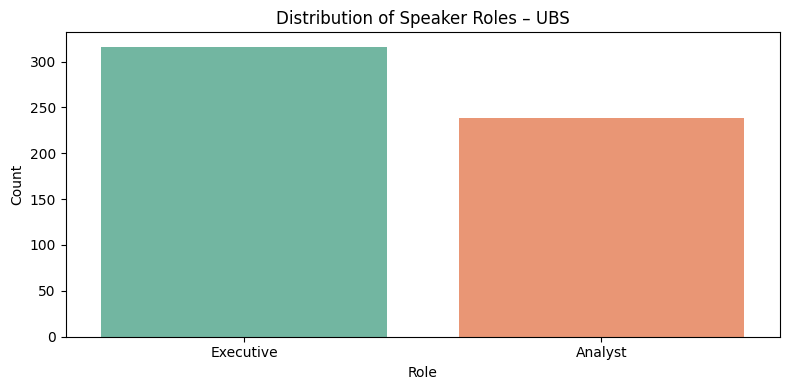

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_UBS.png


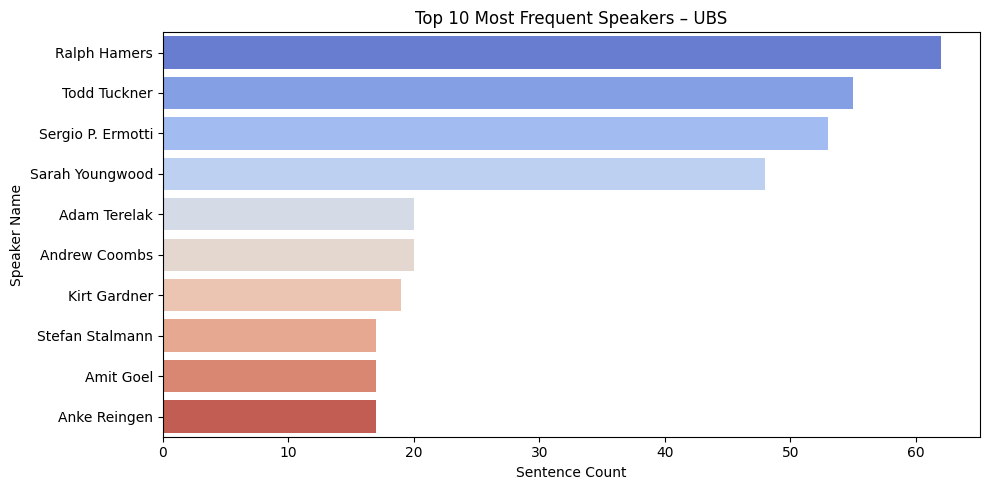

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_UBS.png


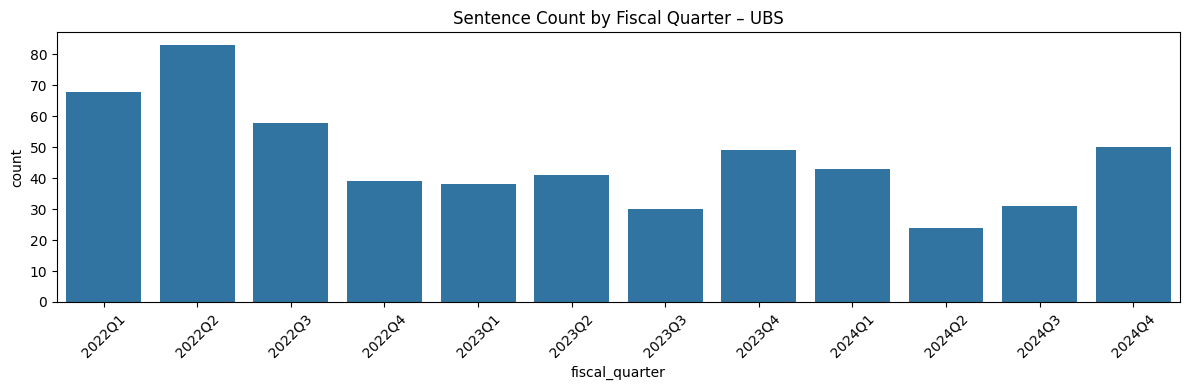

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_JPMorgan.png


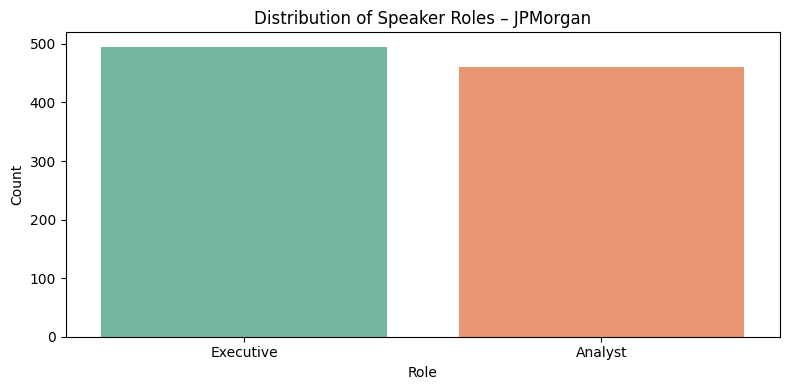

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_JPMorgan.png


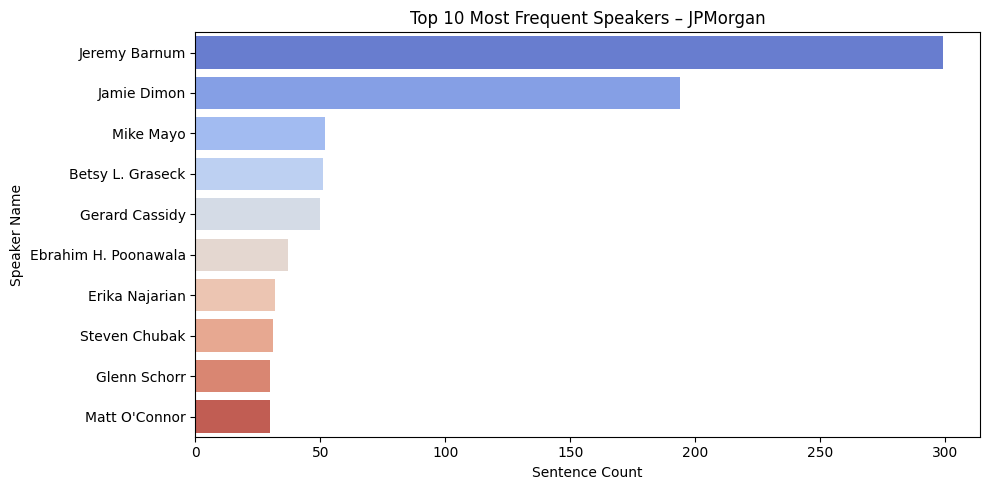

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_JPMorgan.png


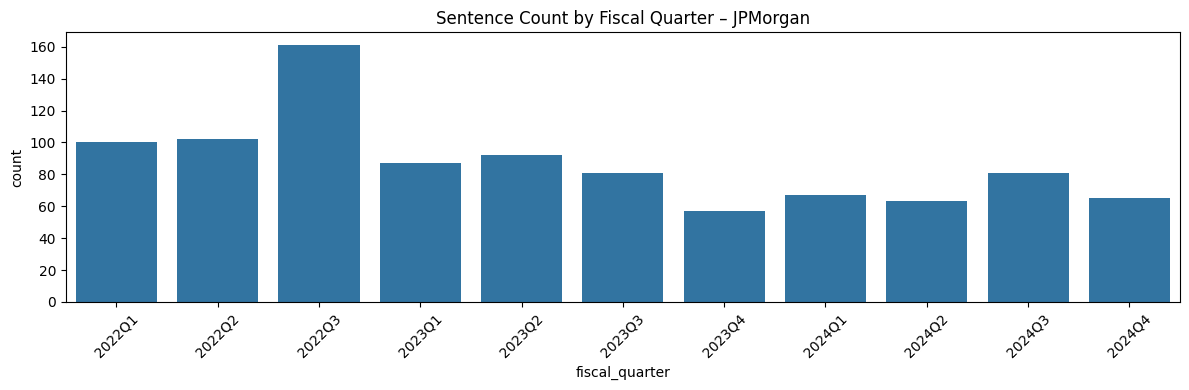

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_Deutsche_Bank.png


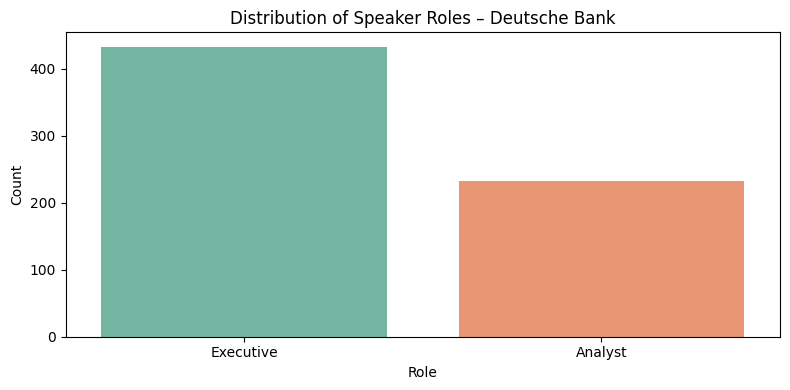

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_Deutsche_Bank.png


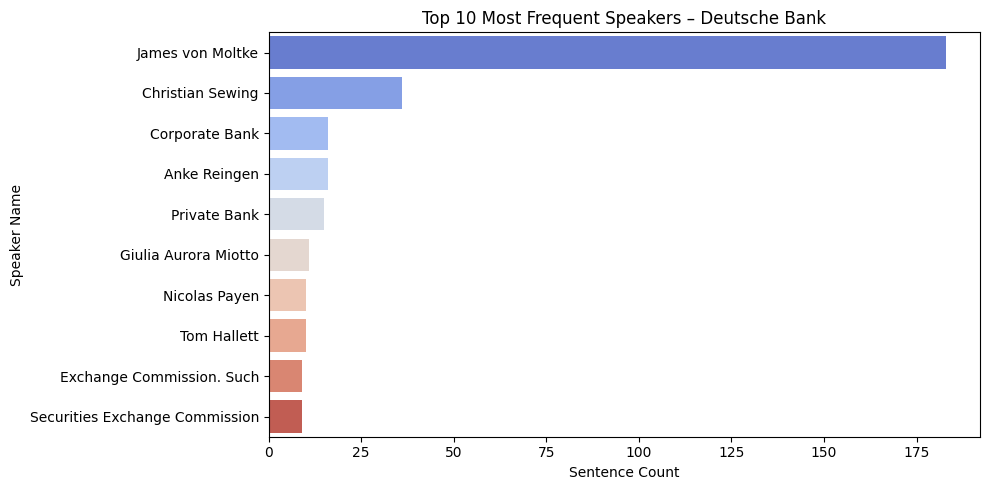

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_Deutsche_Bank.png


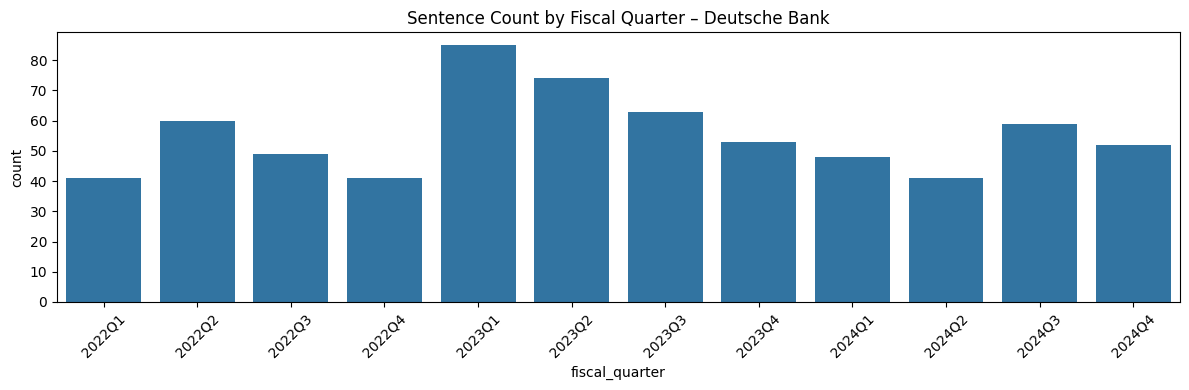

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_HSBC.png


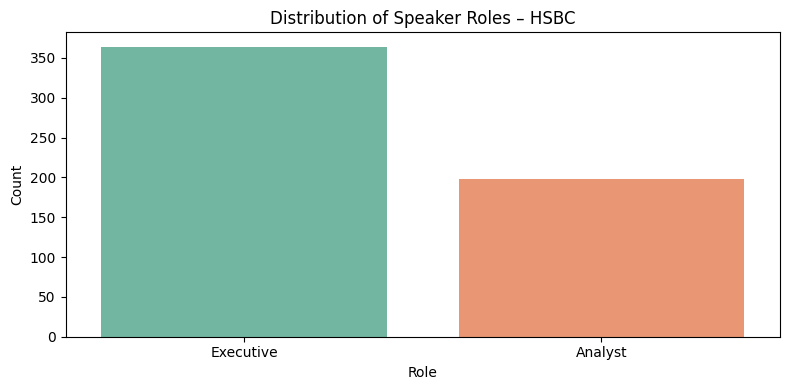

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_HSBC.png


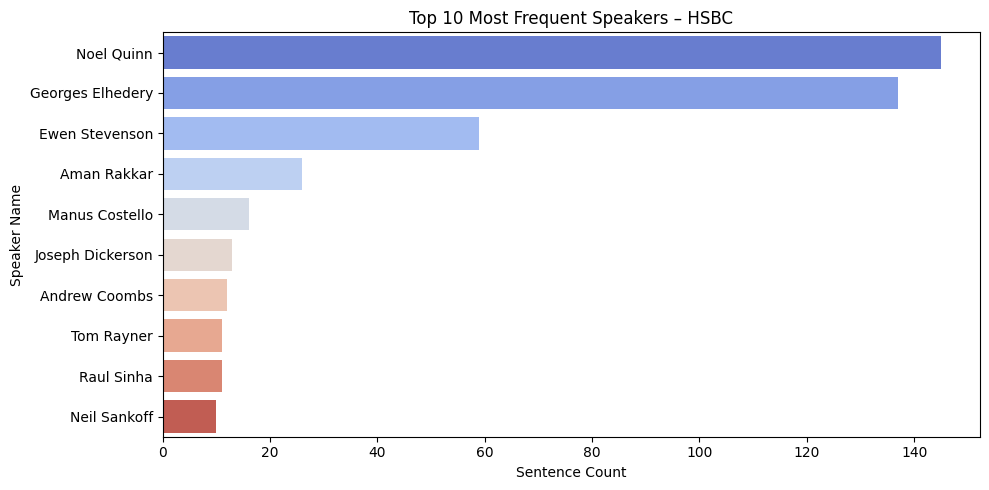

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_HSBC.png


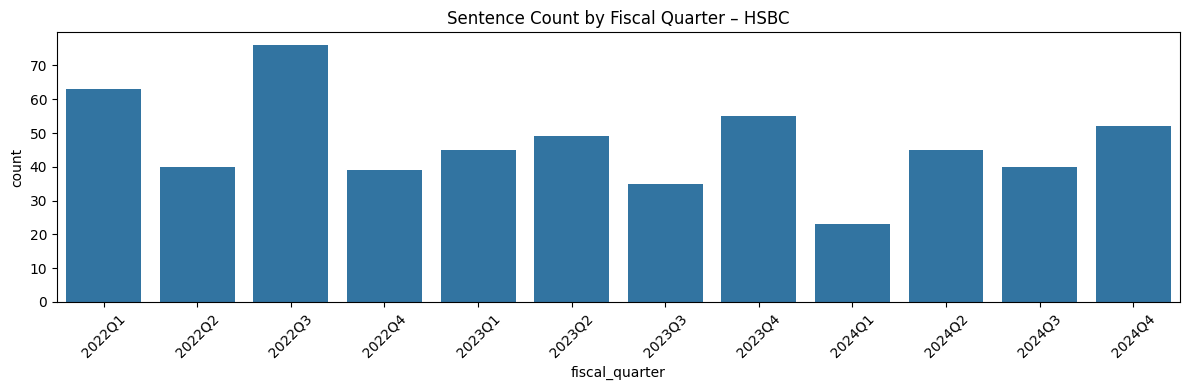

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_CreditSuisse.png


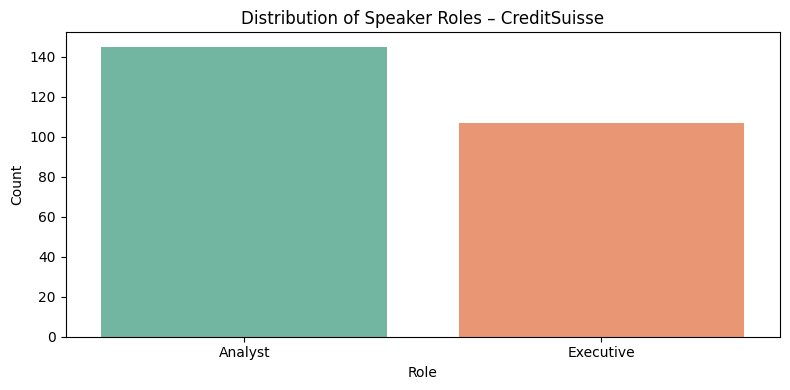

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_CreditSuisse.png


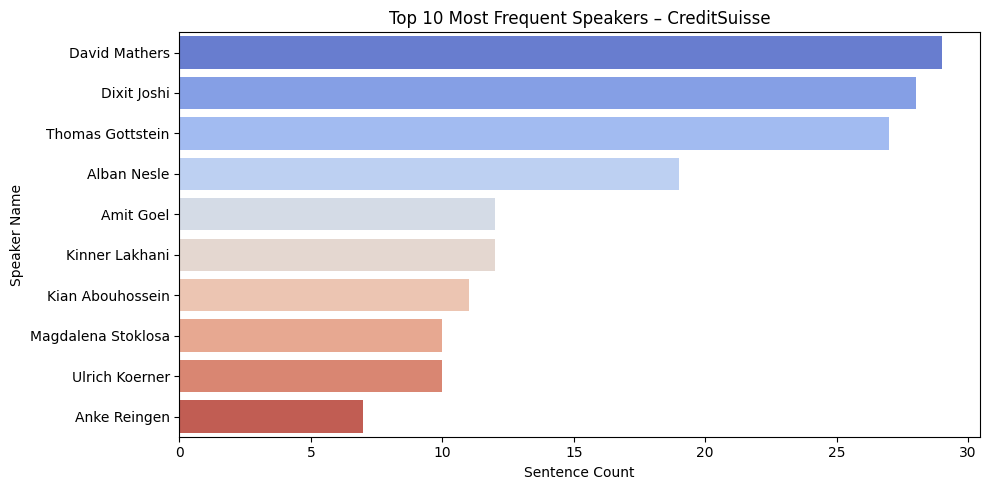

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_CreditSuisse.png


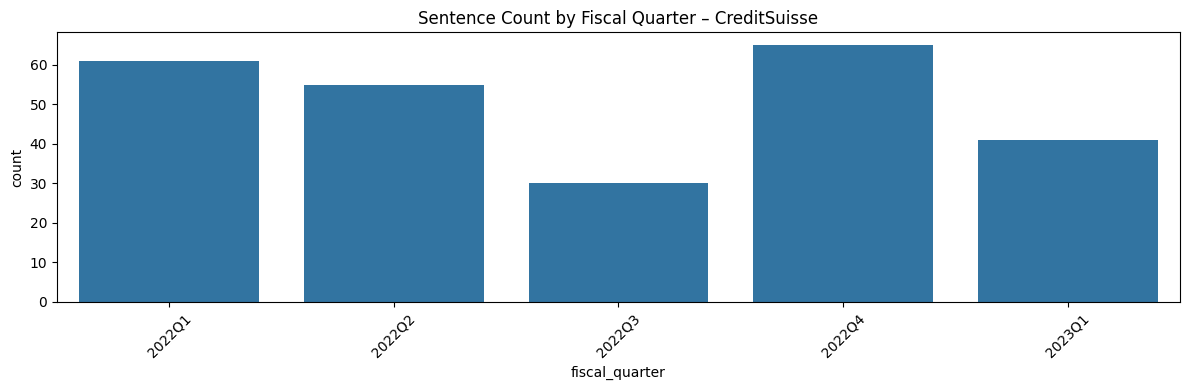

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_speaker_roles_Overall.png


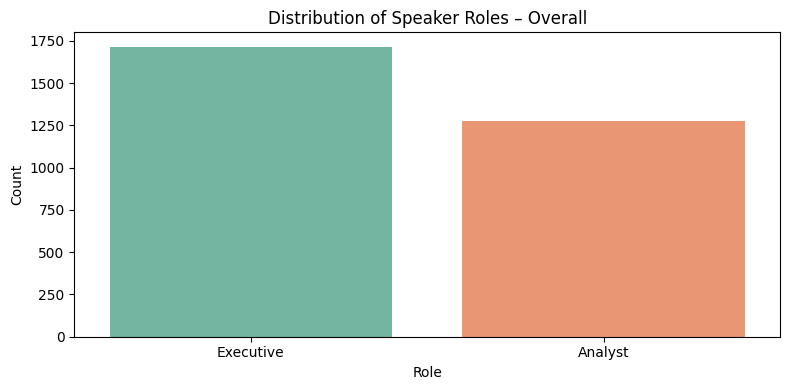

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_top10_speakers_Overall.png


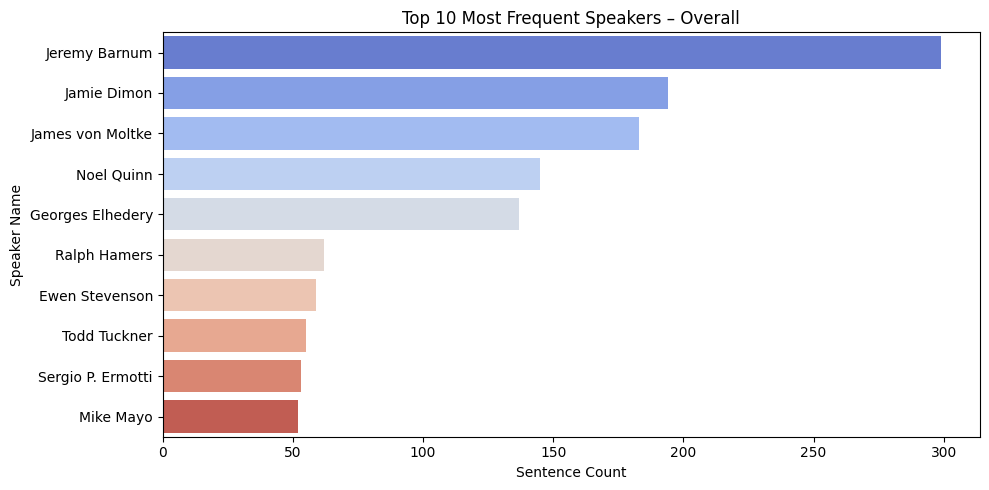

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/exploratory_sentences_per_quarter_Overall.png


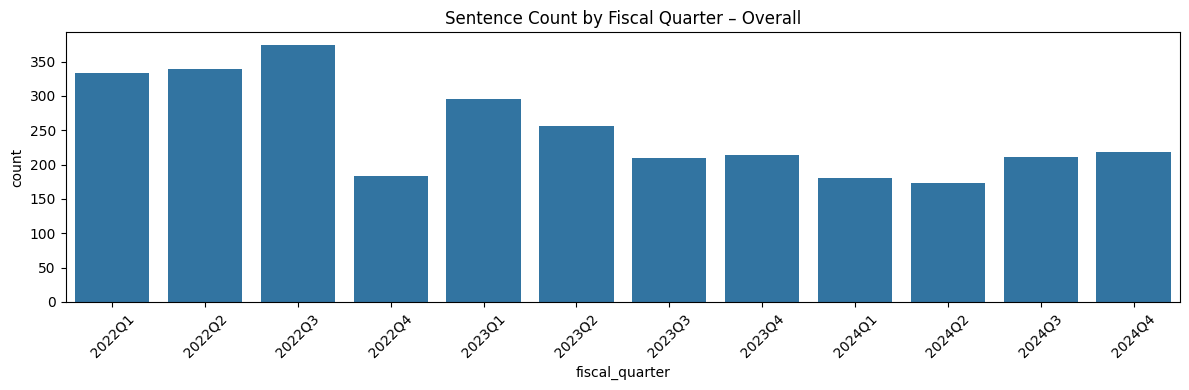

In [ ]:
def plot_company_exploratories(df, company, save=True, drop_operator=True):
    if company == "Overall":
        sub = df.copy()
    else:
        sub = df[df["company"]==company].copy()

    if sub.empty:
        print(f"⚠️ No data for {company}, skipping.")
        return

    # Speaker Role Distribution
    if "speaker_role" in sub.columns or "speaker_type" in sub.columns:
        role_col = "speaker_role" if "speaker_role" in sub.columns else "speaker_type"
        plt.figure(figsize=(8,4))
        sns.countplot(
            data=sub,
            x=role_col,
            palette="Set2",
            order=sub[role_col].value_counts().index
        )
        plt.title(f"Distribution of Speaker Roles – {company}")
        plt.xlabel("Role"); plt.ylabel("Count"); plt.tight_layout()
        if save:
            p = OUTPUT_DIR / f"exploratory_speaker_roles_{company.replace(' ','_')}.png"
            plt.savefig(p, dpi=150); print("Saved plot:", p)
        plt.show()
    else:
        print(f"ℹ️ No role column for {company}, skipping role distribution.")

    # Top 10 Speakers
    if "speaker_name" in sub.columns:
        tmp = sub.copy()
        if drop_operator:
            tmp = tmp[~tmp["speaker_name"].isin(["Operator","Unknown"])]
        top_speakers = tmp["speaker_name"].value_counts().head(10)
        if len(top_speakers) > 0:
            plt.figure(figsize=(10,5))
            sns.barplot(x=top_speakers.values, y=top_speakers.index, palette="coolwarm")
            plt.title(f"Top 10 Most Frequent Speakers – {company}")
            plt.xlabel("Sentence Count"); plt.ylabel("Speaker Name"); plt.tight_layout()
            if save:
                p = OUTPUT_DIR / f"exploratory_top10_speakers_{company.replace(' ','_')}.png"
                plt.savefig(p, dpi=150); print("Saved plot:", p)
            plt.show()

    # Sentiment Distribution
    if "sentiment" in sub.columns:
        s = sub["sentiment"].dropna()
        if len(s) > 0:
            plt.figure(figsize=(8,4))
            sns.histplot(s, bins=30, kde=True, color="purple")
            plt.title(f"Sentiment Polarity Distribution – {company}")
            plt.xlabel("Sentiment Score"); plt.ylabel("Frequency"); plt.tight_layout()
            if save:
                p = OUTPUT_DIR / f"exploratory_sentiment_dist_{company.replace(' ','_')}.png"
                plt.savefig(p, dpi=150); print("Saved plot:", p)
            plt.show()

    # Sentence Count per Fiscal Quarter
    if "fiscal_quarter" in sub.columns:
        sub["fiscal_quarter"] = sort_quarter_series(sub["fiscal_quarter"])
        plt.figure(figsize=(12,4))
        sns.countplot(data=sub, x="fiscal_quarter", order=sub["fiscal_quarter"].cat.categories)
        plt.title(f"Sentence Count by Fiscal Quarter – {company}")
        plt.xticks(rotation=45); plt.tight_layout()
        if save:
            p = OUTPUT_DIR / f"exploratory_sentences_per_quarter_{company.replace(' ','_')}.png"
            plt.savefig(p, dpi=150); print("Saved plot:", p)
        plt.show()

# Run per company
for comp in df["company"].dropna().unique():
    plot_company_exploratories(df, comp, save=True)

# Overall pooled
plot_company_exploratories(df, "Overall", save=True)


Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_CreditSuisse.png


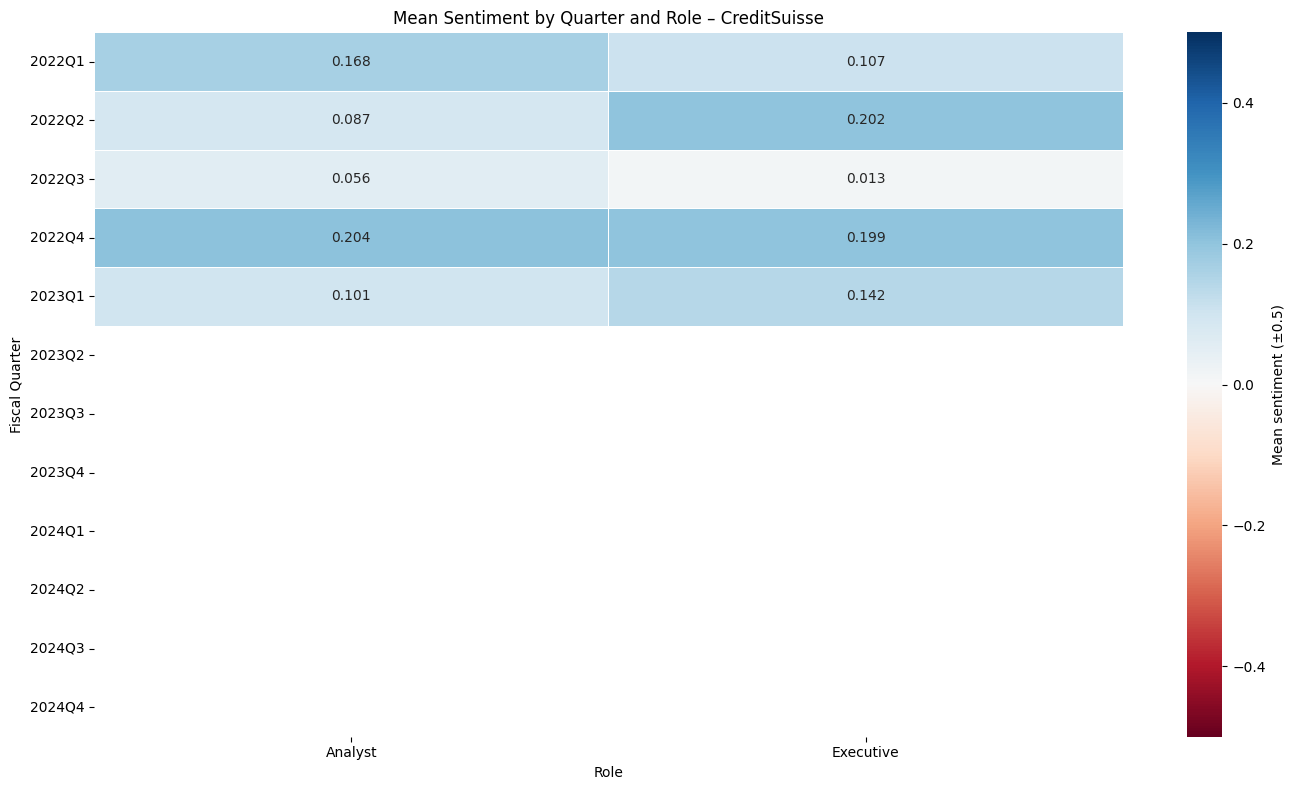

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_Deutsche_Bank.png


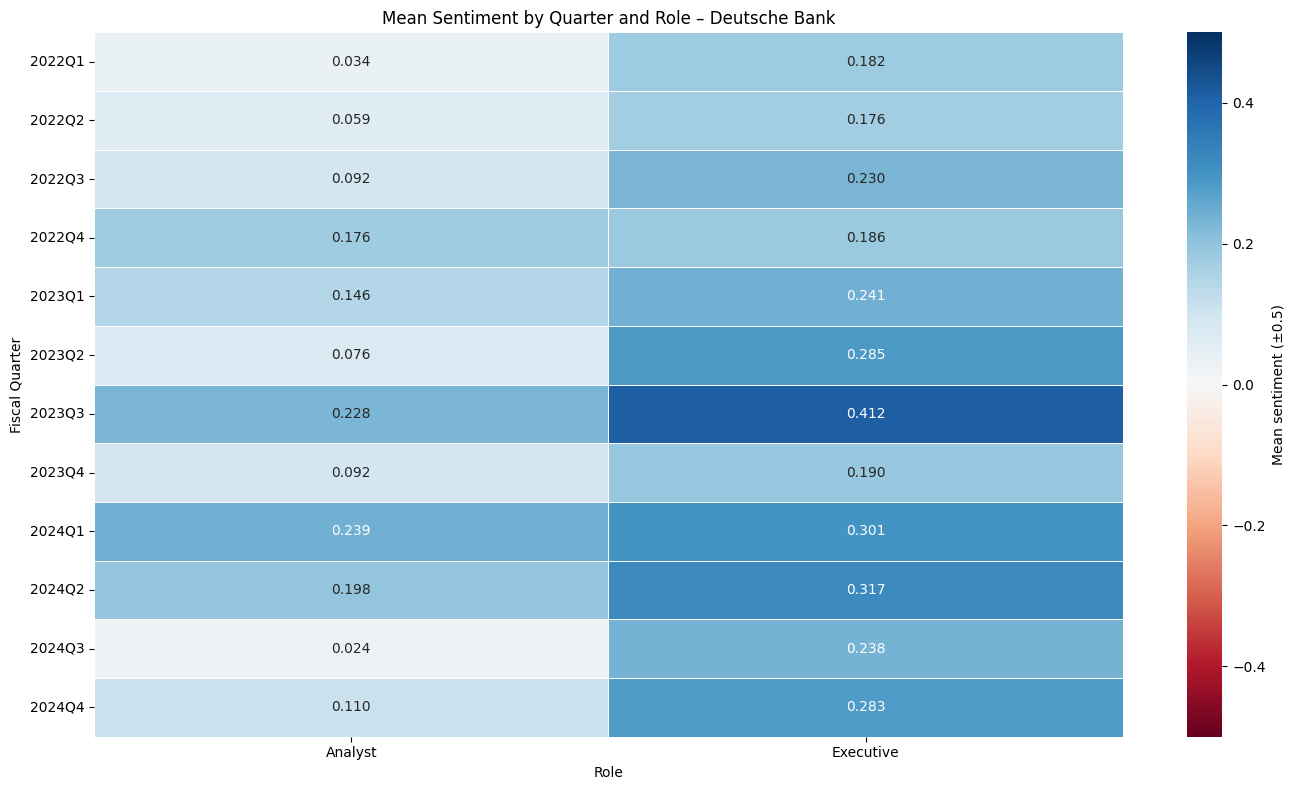

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_HSBC.png


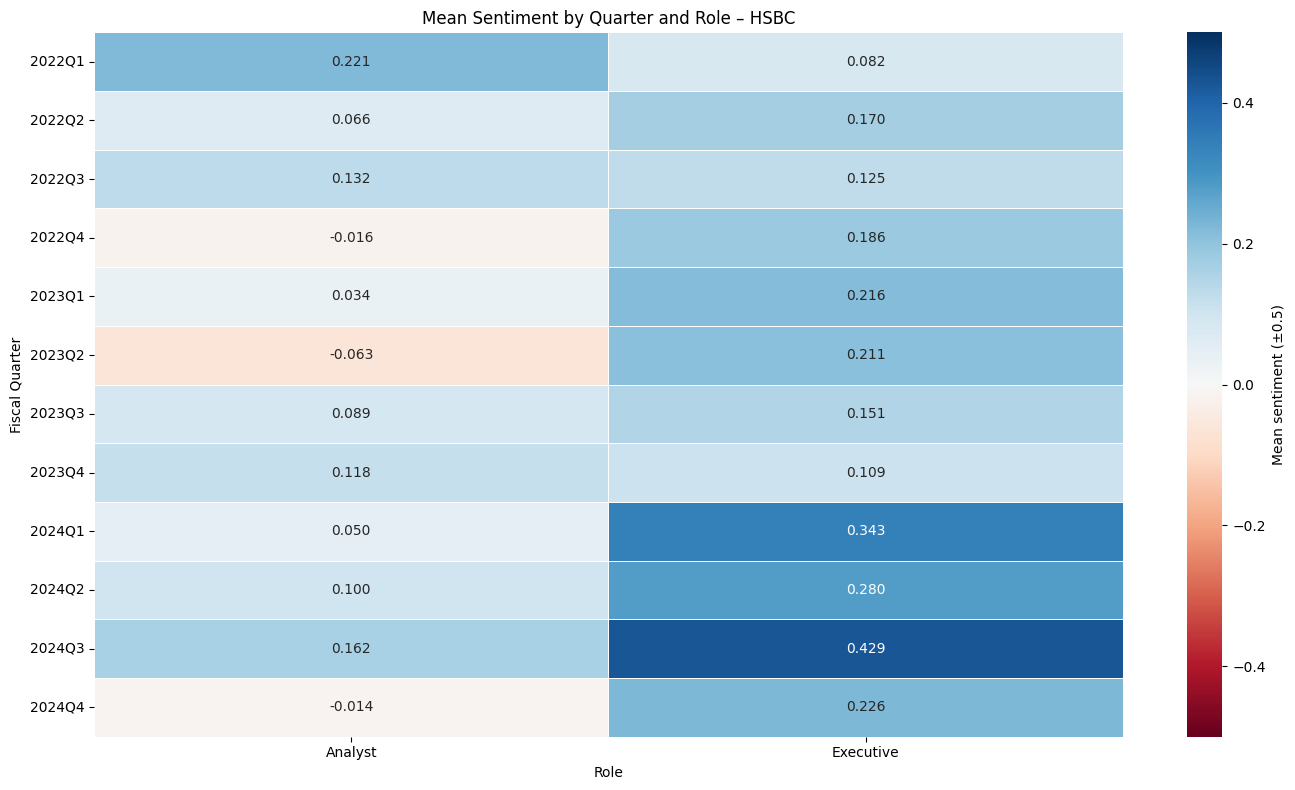

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_JPMorgan.png


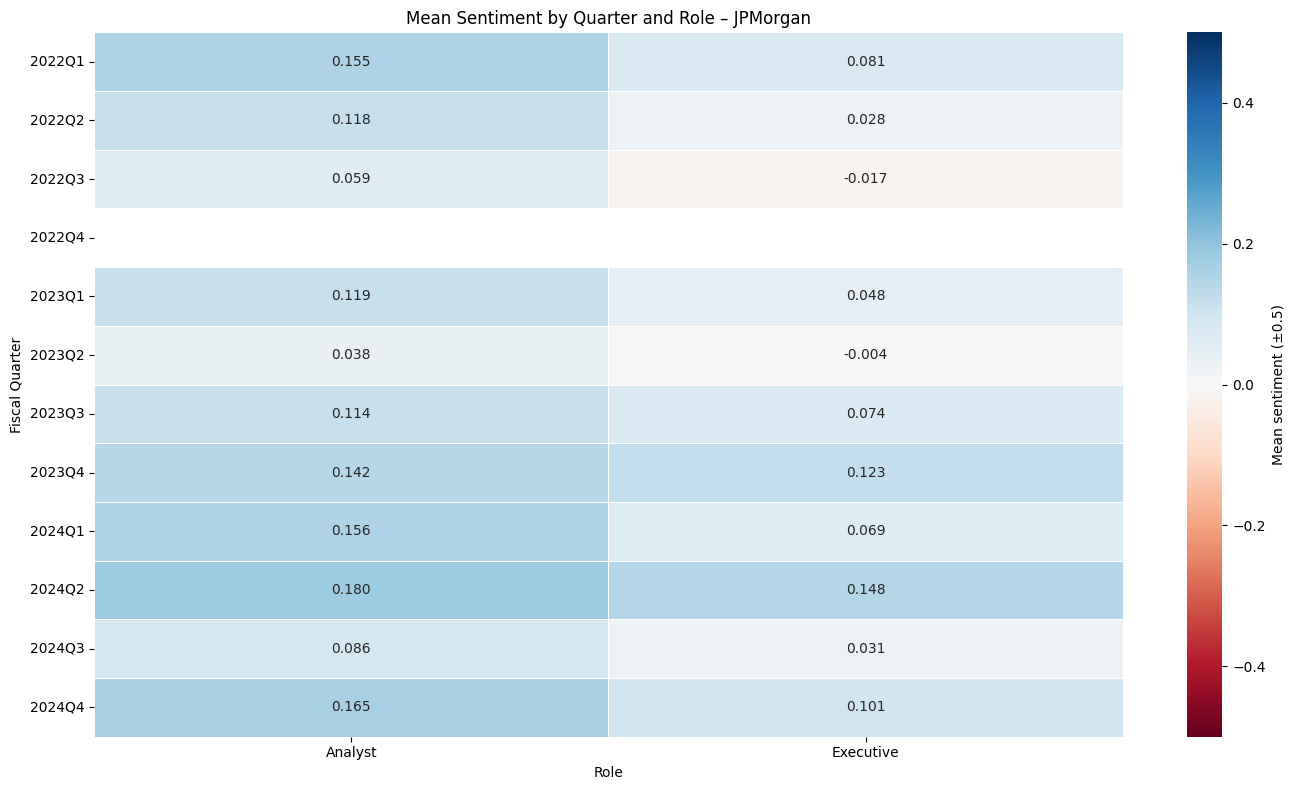

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_UBS.png


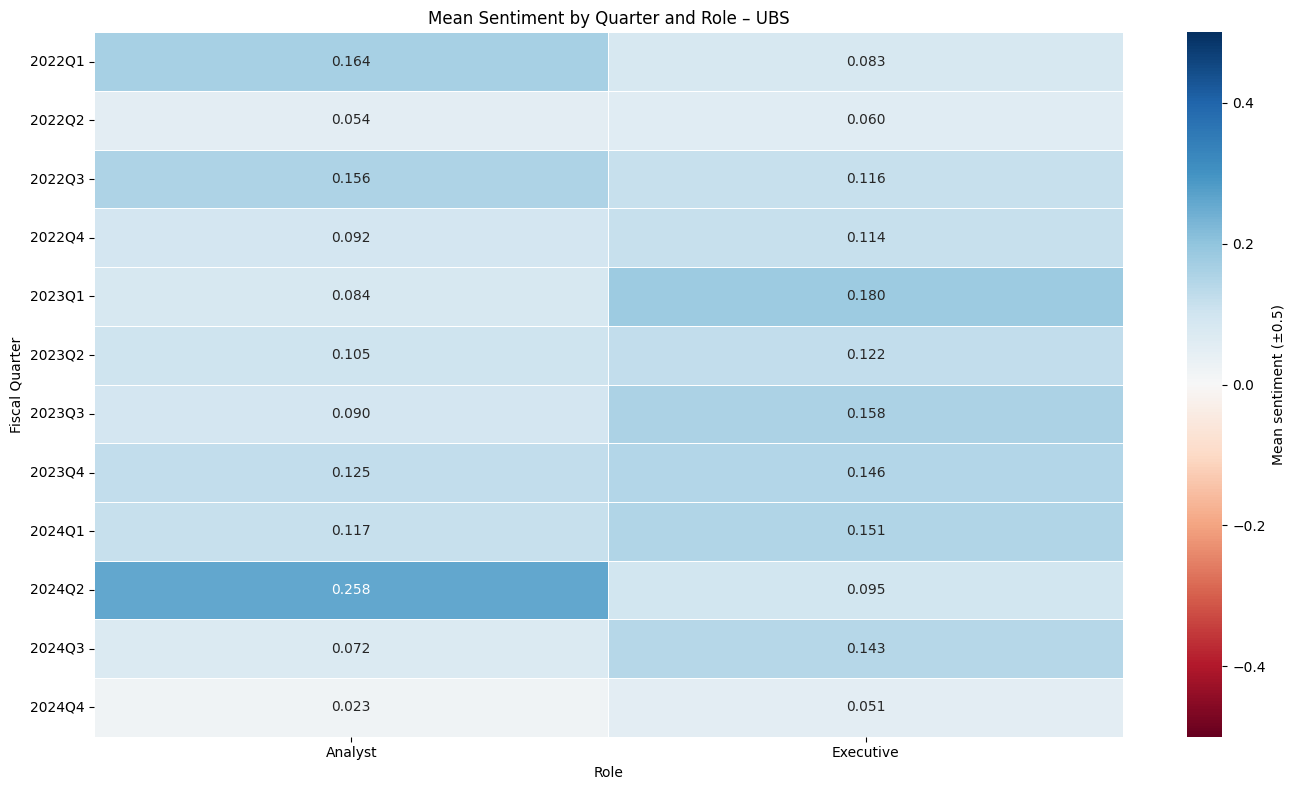

Saved plot: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/heatmap_sentiment_Overall.png


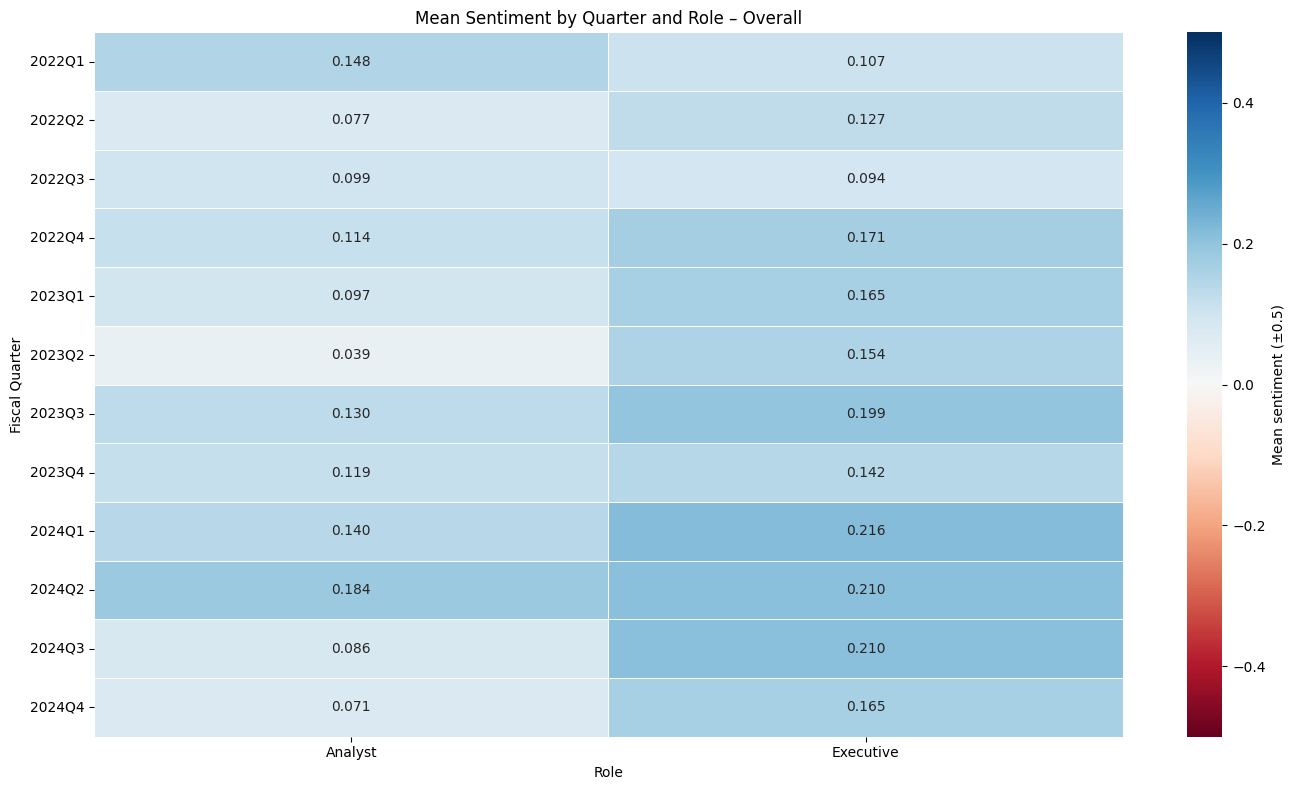

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === HEATMAPS: Mean sentiment by quarter × role (from saved aggregates) ===
sent_path = OUTPUT_DIR / "emotion_quarterly_by_speaker.csv"
df_hm = pd.read_csv(sent_path)

# Ensure expected columns
need = {"company", "fiscal_quarter", "speaker_role", "mean_sentiment"}
missing = need - set(df_hm.columns)
if missing:
    raise ValueError(f"Missing columns in {sent_path.name}: {missing}")

# Quarter ordering helper (reuse your helper if it exists)
def _sort_quarter_series(s: pd.Series) -> pd.Series:
    try:
        return sort_quarter_series(s)  # your existing helper if defined
    except NameError:
        def _key(x):
            x = str(x)
            if "Q" in x:
                y, q = x.split("Q")
                return (int(y), int(q))
            return (9999, 9)
        cats = sorted(s.dropna().unique(), key=_key)
        return pd.Categorical(s, categories=cats, ordered=True)

# Order quarters
df_hm["fiscal_quarter"] = _sort_quarter_series(df_hm["fiscal_quarter"])

# --- Color scale: symmetric ±0.5 to reveal negatives ---
vmax = 0.5
vmin = -vmax

def _heatmap_one(sub: pd.DataFrame, title_company: str, fname_stub: str,
                 decimals: int = 3):
    # Pivot to quarter × role; enforce column order
    piv = (sub.groupby(["fiscal_quarter", "speaker_role"])["mean_sentiment"]
             .mean()
             .reset_index()
             .pivot(index="fiscal_quarter", columns="speaker_role", values="mean_sentiment"))
    for col in ["Analyst", "Executive"]:
        if col not in piv.columns:
            piv[col] = np.nan
    piv = piv[["Analyst", "Executive"]]

    if hasattr(sub["fiscal_quarter"], "cat"):
        piv = piv.reindex(sub["fiscal_quarter"].cat.categories)

    plt.figure(figsize=(14, 8))
    sns.heatmap(
        piv, annot=True, fmt=f".{decimals}f",
        cmap="RdBu", vmin=vmin, vmax=vmax, center=0,
        linewidths=0.5,
        cbar_kws={"label": f"Mean sentiment (±{vmax})"}
    )
    plt.title(f"Mean Sentiment by Quarter and Role – {title_company}")
    plt.xlabel("Role")
    plt.ylabel("Fiscal Quarter")
    plt.tight_layout()
    p = OUTPUT_DIR / f"heatmap_sentiment_{fname_stub}.png"
    plt.savefig(p, dpi=150)
    print("Saved plot:", p)
    plt.show()

# Per-company heatmaps
for comp in sorted(df_hm["company"].dropna().unique()):
    sub = df_hm[df_hm["company"] == comp].copy()
    _heatmap_one(sub, comp, comp.replace(" ", "_"), decimals=3)

# Overall (pooled across companies)
overall = df_hm.copy()
overall["company"] = "Overall"
_heatmap_one(overall, "Overall", "Overall", decimals=3)

In [ ]:
# 0) Load what the heatmap uses
sent_path = OUTPUT_DIR / "emotion_quarterly_by_speaker.csv"
hm = pd.read_csv(sent_path)

# 1) Are those quarters present for DB?
print("DB quarters present:")
print(hm.loc[hm.company=="Deutsche Bank","fiscal_quarter"].value_counts().sort_index())

# 2) What role labels does DB have?
print("\nDB roles present:")
print(hm.loc[hm.company=="Deutsche Bank","speaker_role"].value_counts())

# 3) Do those quarters have NaN means?
print("\nDB Q1/Q3/Q4 rows with NaN means:")
print(hm[(hm.company=="Deutsche Bank") &
         (hm.fiscal_quarter.isin(["2022Q1","2022Q3","2022Q4"])) &
         (hm.mean_sentiment.isna())]
      [["fiscal_quarter","speaker_role","mean_sentiment"]])


DB quarters present:
fiscal_quarter
2022Q1    2
2022Q2    2
2022Q3    2
2022Q4    2
2023Q1    2
2023Q2    2
2023Q3    2
2023Q4    2
2024Q1    2
2024Q2    2
2024Q3    2
2024Q4    2
Name: count, dtype: int64

DB roles present:
speaker_role
Analyst      12
Executive    12
Name: count, dtype: int64

DB Q1/Q3/Q4 rows with NaN means:
Empty DataFrame
Columns: [fiscal_quarter, speaker_role, mean_sentiment]
Index: []


In [ ]:
# === Overlay sentiment (pivot) with Louis's fundamentals (robust, tokenized metrics) ===
import re, unicodedata
from difflib import get_close_matches
from pathlib import Path
import pandas as pd

# ----- Paths -----
PROJECT_ROOT   = Path("/content/drive/MyDrive/Bank of England - Project")
SENT_DIR       = PROJECT_ROOT / "outputs" / "emotion_temporal"
SENT_TABLE     = SENT_DIR / "emotion_quarterly_pivot.csv"     # your sentiment pivot
FUND_TABLE_DIR = PROJECT_ROOT / "outputs" / "fundamental_analysis" / "tables"
FUND_TABLE     = FUND_TABLE_DIR / "fundamentals__ALL.csv"     # Louis' master stack

# ----- Canon + helpers -----
CANONICAL_BANKS = [
    "UBS","Credit Suisse","Deutsche Bank","HSBC","JPMorgan","Barclays","Societe Generale",
]

def strip_accents(s: str) -> str:
    s_norm = unicodedata.normalize("NFKD", str(s))
    return "".join(ch for ch in s_norm if not unicodedata.combining(ch))

def letters_only_upper(s: str) -> str:
    return re.sub(r"[^A-Za-z]+", "", str(s)).upper()

def clean_louis_bank_raw(val: str) -> str:
    """Make Louis' 'fundamental_*' values comparable to canonical names."""
    v = strip_accents(str(val).strip()).lower()
    v = re.sub(r"^fundamental[_\-]+", "", v)   # drop prefix
    # Fix common OCR-ish fragments
    v = v.replace("cr_dit", "credit").replace("soci_t", "societe").replace("g_n", "ge").replace("g n", "ge")
    v = re.sub(r"[_\s]+", " ", v).strip()
    if v == "deutsche": v = "deutsche bank"
    v = v.replace("jp morgan", "jpmorgan")
    return v

CANON_CLEAN = {b: letters_only_upper(strip_accents(b)) for b in CANONICAL_BANKS}
ALIASES = {
    "CRDITSUISSE":"Credit Suisse","CREDITSUISSE":"Credit Suisse",
    "SOCIETEGNRALE":"Societe Generale","SOCIETEGENRALE":"Societe Generale",
    "SOCIETEGNERALE":"Societe Generale","SOCIETEGE NERALE":"Societe Generale",
    "DEUTSCHE":"Deutsche Bank","JPMORGANCHASE":"JPMorgan","JPMORGANCHASECO":"JPMorgan","JPM":"JPMorgan",
}

def to_canonical_bank(name: str) -> str:
    raw = clean_louis_bank_raw(name)
    key = letters_only_upper(raw)
    if key in ALIASES: return ALIASES[key]
    for canon, ckey in CANON_CLEAN.items():
        if key == ckey: return canon
    match = get_close_matches(key, list(CANON_CLEAN.values()), n=1, cutoff=0.60)
    if match:
        best = match[0]
        for canon, ckey in CANON_CLEAN.items():
            if ckey == best: return canon
    return raw.title()

def quarter_to_parts(q: str):
    """Parse to (year:int, q:int)."""
    if not isinstance(q, str): return (None, None)
    s = strip_accents(q).upper().replace("–","-").replace("—","-")
    s = s.replace("\\N"," ").replace("\\n"," ").replace("\n"," ")
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"\(.*?\)$", "", s).strip()

    # 2023Q3 / 2023-Q3 / 2023/Q3
    m = re.match(r"^(\d{4})\s*[-/]?\s*Q0?([1-4])$", s)
    if m: yr, qq = m.groups(); return (int(yr), int(qq))
    # Q3 2023
    m = re.match(r"^Q0?([1-4])\s*[-/]?\s*(\d{4})$", s)
    if m: qq, yr = m.groups(); return (int(yr), int(qq))
    # Q323 or Q3 23
    m = re.match(r"^Q([1-4])\s*([0-9]{2})$", s)
    if m: qq, yy = m.groups(); return (2000+int(yy), int(qq))
    # 3Q 2023 / 3Q23
    m = re.match(r"^([1-4])\s*Q\s*([0-9]{2,4})$", s)
    if m:
        qq, year = m.groups()
        yr = int(year) if len(year)==4 else 2000+int(year)
        return (yr, int(qq))
    # 2023 Q3
    m = re.match(r"^(\d{4})\s+Q([1-4])$", s)
    if m: yr, qq = m.groups(); return (int(yr), int(qq))
    # general fallback
    y = re.search(r"\b(20\d{2})\b", s); qn = re.search(r"\bQ\s*([1-4])\b", s)
    if y and qn: return (int(y.group(1)), int(qn.group(1)))
    return (None, None)

def safe_find_cols(df: pd.DataFrame):
    """Best effort to find bank/quarter columns."""
    low = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for k in cands:
            if k in low: return low[k]
        return None
    bank = pick("company","bank","bank_name","company_name","issuer","name")
    qtr  = pick("fiscal_quarter","quarter","quarter_label","qtr","period")
    if bank is None:
        # naive autodetect of a bank-like col
        best = None; score = -1
        for c in df.columns:
            s = df[c].dropna().astype(str)
            if s.empty: continue
            uniq = s.nunique()
            if 1 < uniq <= 30:
                mapped = s.head(200).map(to_canonical_bank)
                sc = sum(m in CANONICAL_BANKS for m in mapped)
                if sc > score:
                    best, score = c, sc
        bank = best
    if qtr is None:
        for c in df.columns:
            s = df[c].dropna().astype(str).str.upper()
            if s.str.contains(r"\bQ[1-4]\b", regex=True).any() or s.str.contains(r"\b20\d{2}\b", regex=True).any():
                qtr = c; break
    return bank, qtr

# ----- MultiIndex flatten fix -----
def _flatten_frame(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    if isinstance(df2.columns, pd.MultiIndex):
        df2.columns = ["__".join(map(str, tup)).strip("_") for tup in df2.columns.to_list()]
    if isinstance(df2.index, pd.MultiIndex):
        df2 = df2.reset_index()
    return df2

# ----- Load frames -----
if "pivot" in globals() and isinstance(pivot, pd.DataFrame) and not pivot.empty:
    sent = pivot.copy()
else:
    sent = pd.read_csv(SENT_TABLE)

fund = pd.read_csv(FUND_TABLE)

# Flatten any MultiIndex artifacts first
sent = _flatten_frame(sent)
fund = _flatten_frame(fund)

# If fiscal_quarter ended up as an index name, bring it out
if "fiscal_quarter" not in sent.columns and getattr(sent.index, "name", None) == "fiscal_quarter":
    sent = sent.reset_index()

# ----- Detect & standardize keys -----
s_bank, s_q = safe_find_cols(sent)
f_bank, f_q = safe_find_cols(fund)
if s_bank is None or s_q is None:
    print("Sentiment columns:", list(sent.columns))
    raise ValueError("Sentiment pivot needs a bank and a quarter column.")
if f_bank is None or f_q is None:
    print("Fundamentals columns:", list(fund.columns))
    raise ValueError("Fundamentals file needs a bank and a quarter column.")

sent = sent.rename(columns={s_bank: "company", s_q: "fiscal_quarter"})
fund = fund.rename(columns={f_bank: "company", f_q: "fiscal_quarter"})

# ----- Canonicalize banks -----
sent["company"] = sent["company"].astype(str).map(to_canonical_bank)
# fundamentals__ALL.csv has 'fundamental_*' labels; map to canonical
fund["company"] = fund["company"].astype(str).map(clean_louis_bank_raw).map(to_canonical_bank)

# ----- Parse quarters into numeric keys -----
sent["fiscal_quarter"] = sent["fiscal_quarter"].astype(str)
fund["fiscal_quarter"] = fund["fiscal_quarter"].astype(str)

sent[["year","q"]] = sent["fiscal_quarter"].map(quarter_to_parts).apply(pd.Series)
fund[["year","q"]] = fund["fiscal_quarter"].map(quarter_to_parts).apply(pd.Series)

sent_ok = sent.dropna(subset=["year","q"]).copy()
fund_ok = fund.dropna(subset=["year","q"]).copy()
sent_ok["year"] = sent_ok["year"].astype(int); sent_ok["q"] = sent_ok["q"].astype(int)
fund_ok["year"] = fund_ok["year"].astype(int); fund_ok["q"] = fund_ok["q"].astype(int)

# ----- Detect metric columns by token search -----
def normalize_colname(c: str) -> str:
    return strip_accents(c).lower()

norm_cols = {c: normalize_colname(c) for c in fund_ok.columns}
metric_map = {}  # canonical_name -> real column name in fund_ok

def pick_metric(token: str, canonical_name: str):
    # prefer exact token, else startswith, else contains
    for c, n in norm_cols.items():
        if re.fullmatch(fr"{token}\b", n):
            metric_map[canonical_name] = c; return
    for c, n in norm_cols.items():
        if n.startswith(token):
            metric_map[canonical_name] = c; return
    for c, n in norm_cols.items():
        if token in n:
            metric_map[canonical_name] = c; return

# Look for these tokens in Louis' headers (handles long labels)
pick_metric("lcr",  "LCR")
pick_metric("nsfr", "NSFR")
pick_metric("ldr",  "LDR")
pick_metric("cet1", "CET1")

# Also average note variants if they exist
for cand in ["average note","average_note","avg note","avg_note","note average"]:
    for c, n in norm_cols.items():
        if cand in n and "AVG_NOTE" not in metric_map:
            metric_map["AVG_NOTE"] = c
            break

keep_metrics = list(metric_map.keys())
fund_slim_cols = ["company","year","q"] + [metric_map[k] for k in keep_metrics]
fund_slim = fund_ok[fund_slim_cols].drop_duplicates()
rename_dict = {metric_map[k]: k for k in keep_metrics}
fund_slim = fund_slim.rename(columns=rename_dict)

# ----- Merge on numeric keys -----
merged = sent_ok.merge(fund_slim, on=["company","year","q"], how="left")

# ----- Diagnostics -----
matched_rows = merged[keep_metrics].notna().any(axis=1).sum() if keep_metrics else 0
print("Companies in sentiment (canon):", sorted(sent_ok["company"].unique()))
print("Companies in fundamentals (canon):", sorted(fund_ok["company"].unique()))
print("Quarter span in sentiment:", (sent_ok["year"].min(), sent_ok["year"].max()))
print("Quarter span in fundamentals:", (fund_ok["year"].min(), fund_ok["year"].max()))
print("Detected metric columns:", metric_map)
print(f"Rows with at least one fundamental metric matched: {matched_rows} / {len(merged)}")

if matched_rows == 0 and keep_metrics:
    left_keys  = sent_ok[["company","year","q"]].drop_duplicates()
    right_keys = fund_slim[["company","year","q"]].drop_duplicates()
    left_only  = left_keys.merge(right_keys, on=["company","year","q"], how="left", indicator=True)
    left_only  = left_only[left_only["_merge"]=="left_only"].drop(columns=["_merge"])
    print("\nSample keys present in sentiment but not in fundamentals (first 15):")
    print(left_only.head(15).to_string(index=False))

# ----- Save -----
out_path = SENT_DIR / "emotion_vs_fundamentals.csv"
merged.to_csv(out_path, index=False)
print("✅ Saved overlay table:", out_path)

Companies in sentiment (canon): ['Credit Suisse', 'Deutsche Bank', 'HSBC', 'JPMorgan', 'UBS']
Companies in fundamentals (canon): ['Barclays', 'Credit Suisse', 'Deutsche Bank', 'HSBC', 'JPMorgan', 'Societe Generale', 'UBS']
Quarter span in sentiment: (2022, 2024)
Quarter span in fundamentals: (2021, 2025)
Detected metric columns: {'LCR': 'LCR (Liquidity Coverage Ratio)', 'NSFR': 'NSFR (Net Stable Funding Ratio)', 'LDR': 'LDR (Loan to Deposit Ratio)', 'CET1': 'CET1 (Common Equity Tier 1)'}
Rows with at least one fundamental metric matched: 52 / 52
✅ Saved overlay table: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/emotion_vs_fundamentals.csv


In [ ]:
top_exec = (
    agg[agg["speaker_role"]=="Executive"]
      .sort_values(["company","mean_sentiment"], ascending=[True, False])
      .groupby("company").head(3).reset_index(drop=True)
)
bottom_exec = (
    agg[agg["speaker_role"]=="Executive"]
      .sort_values(["company","mean_sentiment"], ascending=[True, True])
      .groupby("company").head(3).reset_index(drop=True)
)

top_exec.to_csv(OUTPUT_DIR / "top_quarters_exec.csv", index=False)
bottom_exec.to_csv(OUTPUT_DIR / "bottom_quarters_exec.csv", index=False)
print("Saved:\n- top_quarters_exec.csv\n- bottom_quarters_exec.csv")

Saved:
- top_quarters_exec.csv
- bottom_quarters_exec.csv


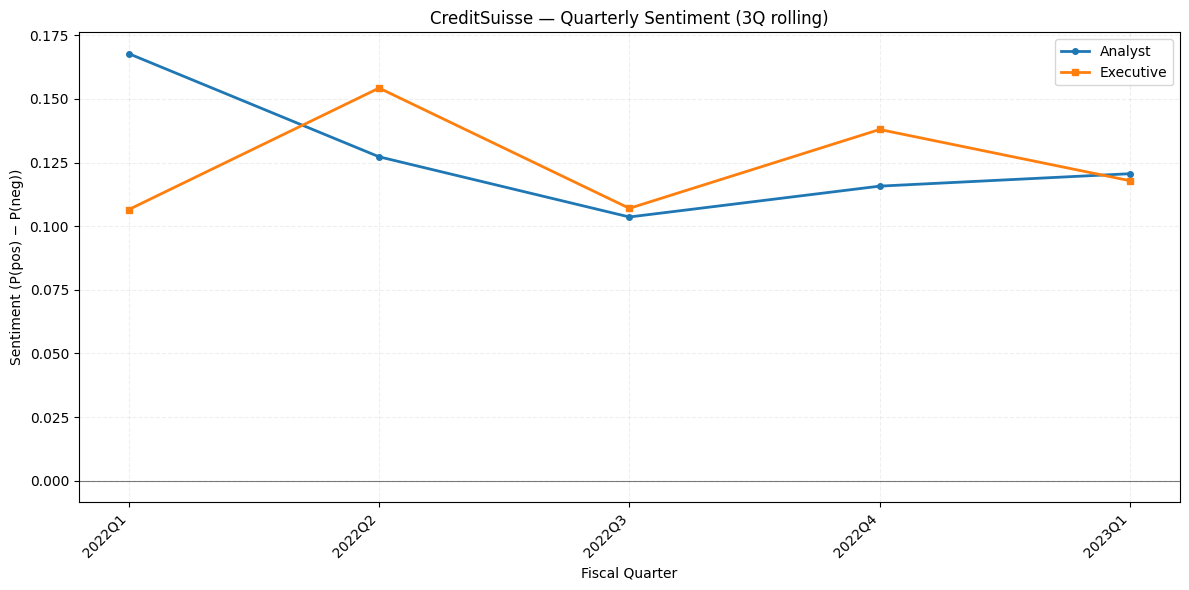

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_CreditSuisse.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_CreditSuisse.csv


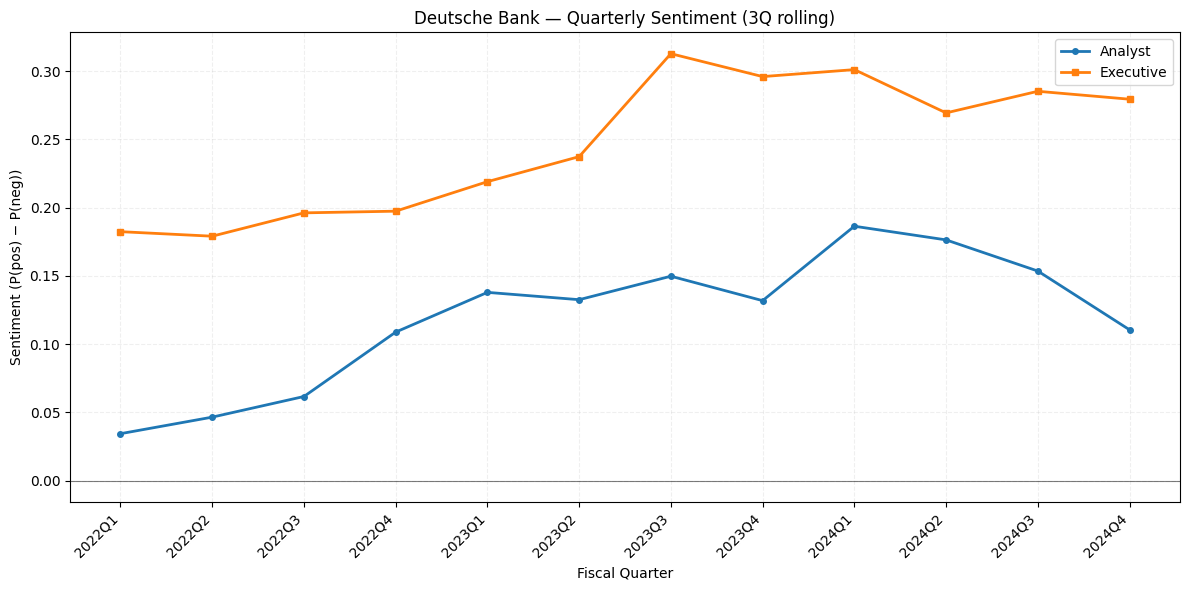

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_Deutsche_Bank.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_Deutsche_Bank.csv


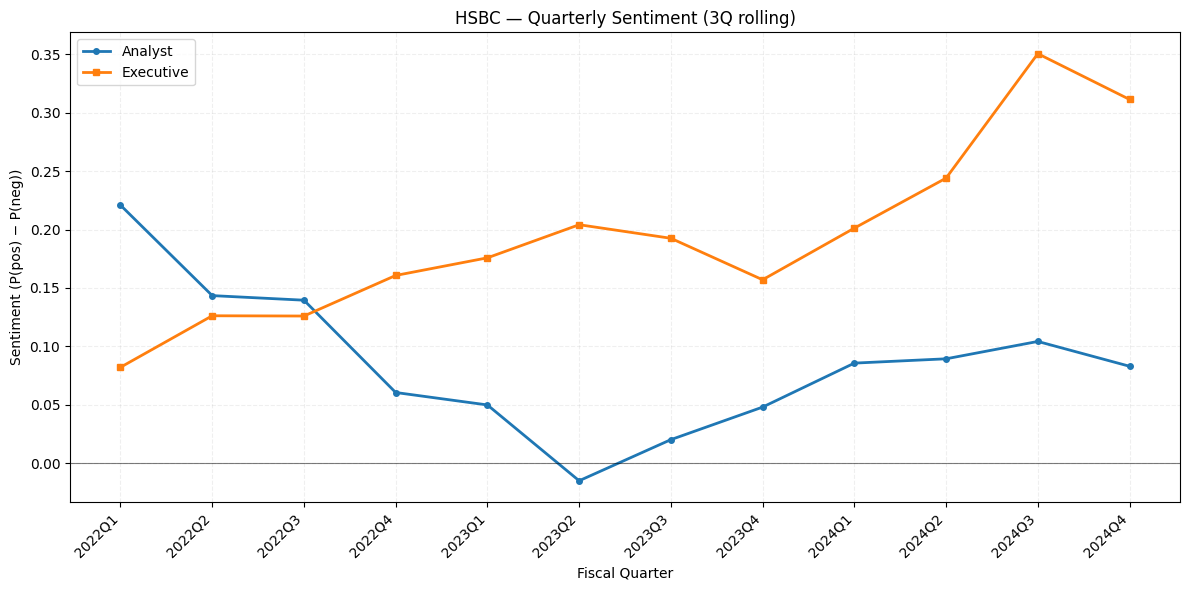

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_HSBC.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_HSBC.csv


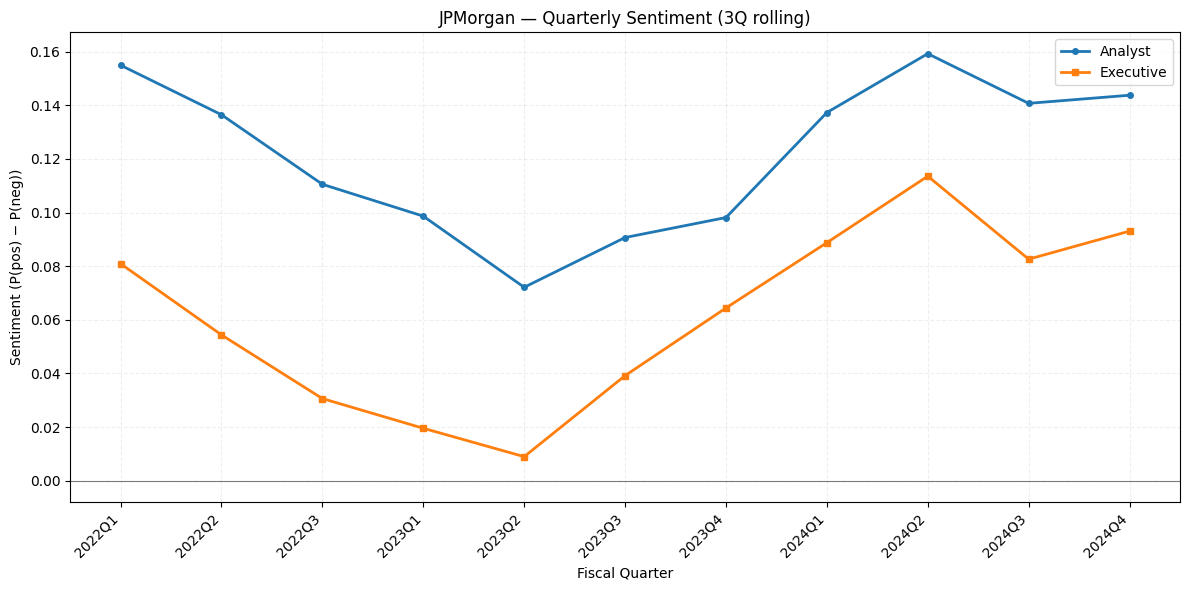

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_JPMorgan.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_JPMorgan.csv


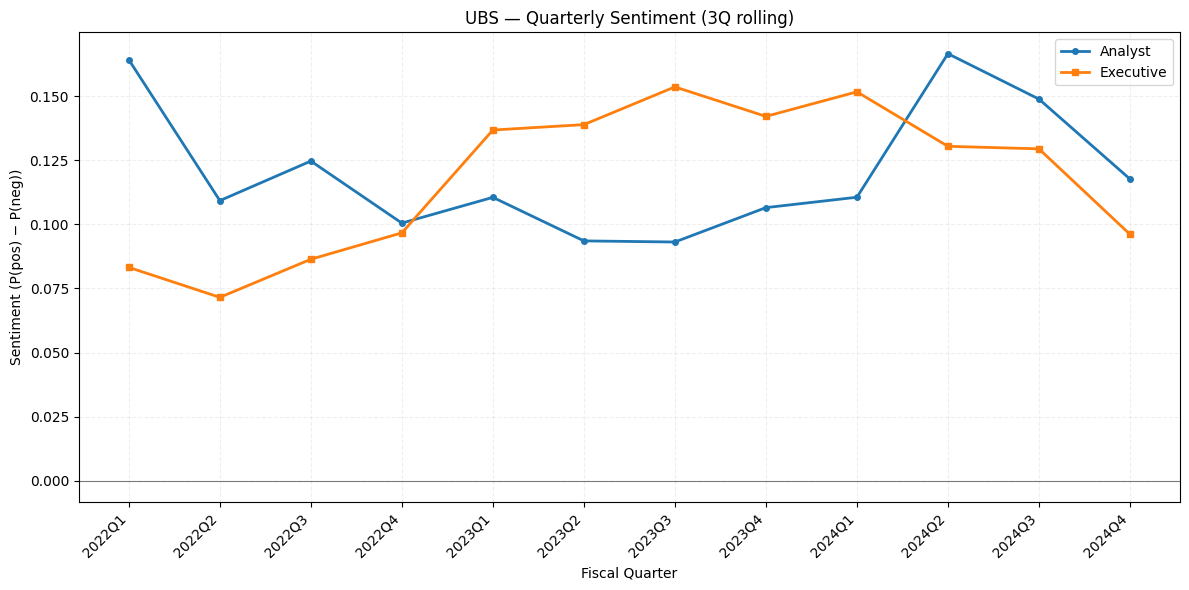

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_UBS.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_UBS.csv


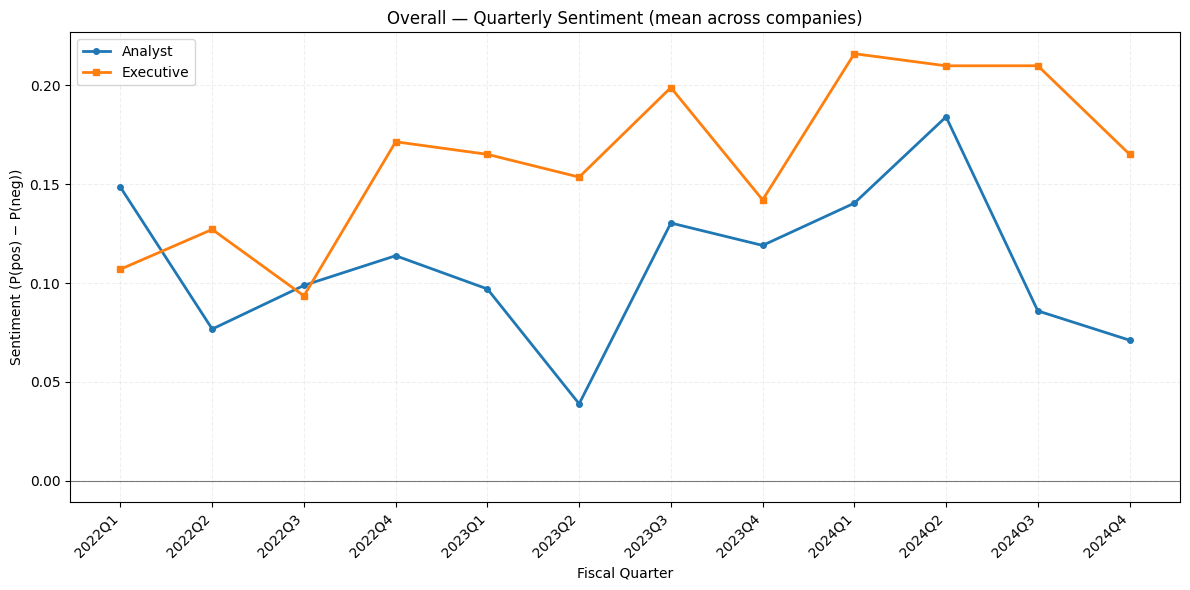

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_overall.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_overall.csv


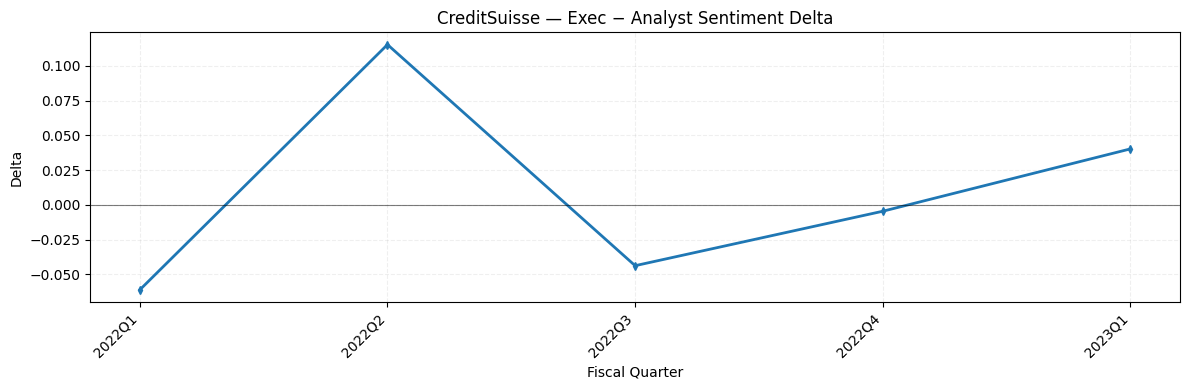

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_delta_CreditSuisse.png


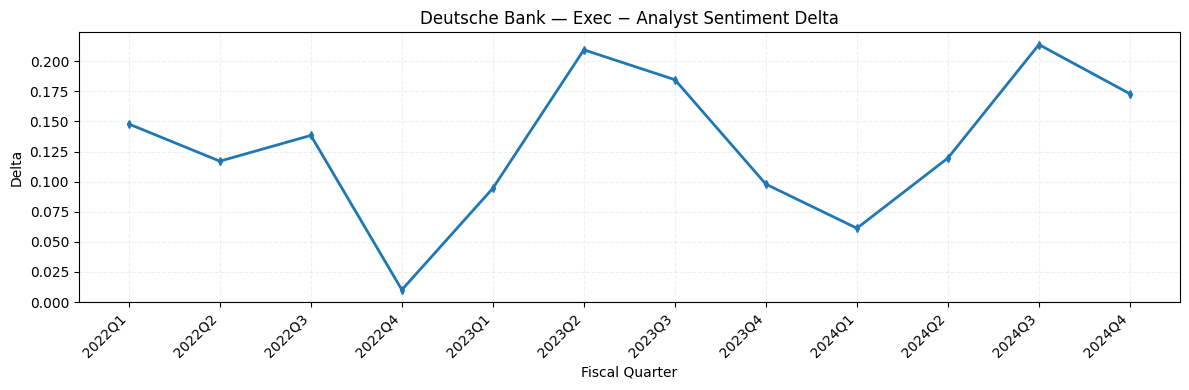

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_delta_Deutsche_Bank.png


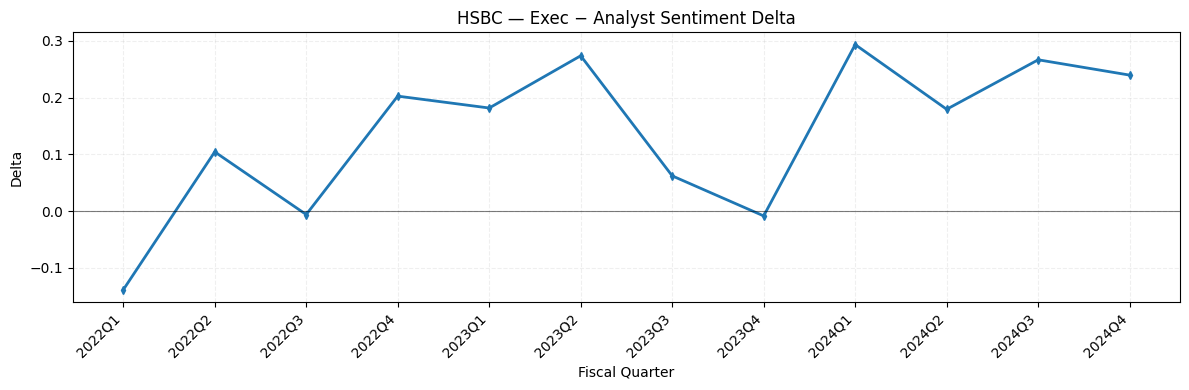

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_delta_HSBC.png


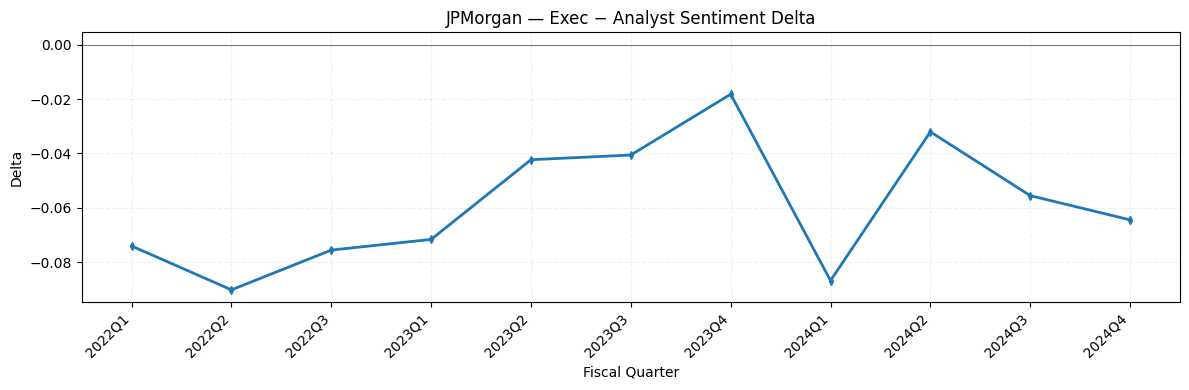

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_delta_JPMorgan.png


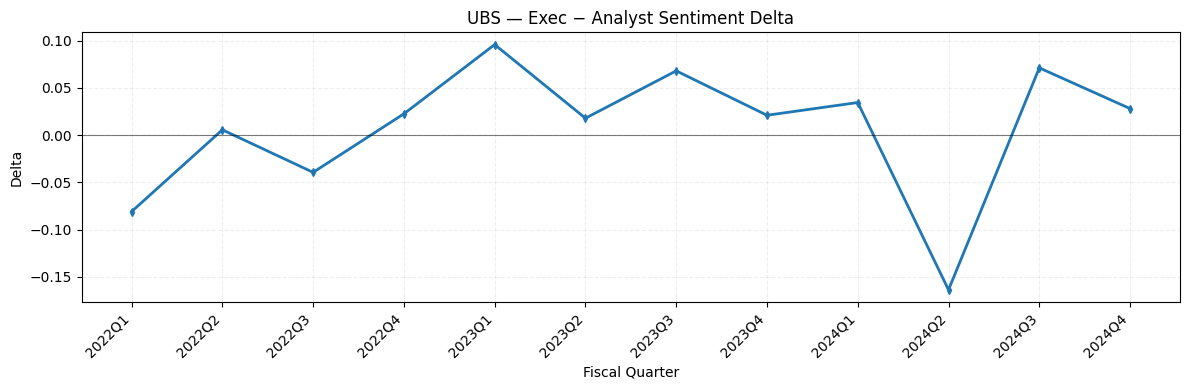

Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series/time_series_delta_UBS.png
Saved:
- sentiment_timeseries_quarterly.csv
- sentiment_timeseries_delta.csv


In [ ]:
# === TIME SERIES: Quarterly sentiment (saved to outputs/time_series AND shown inline) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Base outputs dir already defined earlier:
BASE_OUTPUT = PROJECT_ROOT / "outputs"
TS_DIR = BASE_OUTPUT / "time_series"   # now a sibling of emotion_temporal
TS_DIR.mkdir(parents=True, exist_ok=True)

# Load the aggregated quarterly sentiment produced earlier
sent_path = OUTPUT_DIR / "emotion_quarterly_by_speaker.csv"  # still read from emotion_temporal
df_ts = pd.read_csv(sent_path)

# Validate columns
need = {"company", "fiscal_quarter", "speaker_role", "mean_sentiment"}
missing = need - set(df_ts.columns)
if missing:
    raise ValueError(f"Missing columns in {sent_path.name}: {missing}")

# Quarter ordering helper (reuse your function if available)
def _sort_quarter_series(s: pd.Series) -> pd.Series:
    try:
        return sort_quarter_series(s)
    except NameError:
        def _key(x):
            x = str(x)
            if "Q" in x:
                y, q = x.split("Q")
                return (int(y), int(q))
            return (9999, 9)
        cats = sorted(s.dropna().unique(), key=_key)
        return pd.Categorical(s, categories=cats, ordered=True)

df_ts["fiscal_quarter"] = _sort_quarter_series(df_ts["fiscal_quarter"])

# Optional: add a 3-quarter rolling mean for smoother lines
def _add_roll3(df: pd.DataFrame) -> pd.DataFrame:
    return (df.sort_values(["company","speaker_role","fiscal_quarter"])
              .groupby(["company","speaker_role"], group_keys=False)
              .apply(lambda g: g.assign(roll3 = g["mean_sentiment"].rolling(3, min_periods=1).mean())))

df_ts = _add_roll3(df_ts)

# ---- Plot function: per-company lines (Analyst vs Executive) ----
def plot_company_series(company: str, use_smoothed: bool = True):
    sub = df_ts[df_ts["company"] == company].copy()
    if sub.empty:
        print(f"(no data for {company})"); return

    value_col = "roll3" if use_smoothed else "mean_sentiment"
    piv = (sub.pivot_table(index="fiscal_quarter", columns="speaker_role",
                           values=value_col, aggfunc="mean")
             .reindex(columns=["Analyst","Executive"]))
    for col in ["Analyst","Executive"]:
        if col not in piv.columns:
            piv[col] = np.nan

    plt.figure(figsize=(12,6))
    plt.plot(piv.index, piv["Analyst"], "o-", linewidth=2, markersize=4, label="Analyst")
    plt.plot(piv.index, piv["Executive"], "s-", linewidth=2, markersize=4, label="Executive")
    plt.axhline(0, color="k", linewidth=0.8, alpha=0.5)
    plt.title(f"{company} — Quarterly Sentiment ({'3Q rolling' if use_smoothed else 'mean'})")
    plt.xlabel("Fiscal Quarter"); plt.ylabel("Sentiment (P(pos) − P(neg))")
    plt.xticks(rotation=45, ha="right"); plt.legend(); plt.grid(alpha=0.2, linestyle="--")
    plt.tight_layout()

    png_path = TS_DIR / f"time_series_{company.replace(' ','_')}.png"
    csv_path = TS_DIR / f"time_series_{company.replace(' ','_')}.csv"
    plt.savefig(png_path, dpi=150)
    plt.show()
    plt.close()
    piv.to_csv(csv_path)
    print("Saved:", png_path, "|", csv_path)

# Generate per-company plots (saved + shown)
for comp in sorted(df_ts["company"].dropna().unique()):
    plot_company_series(comp, use_smoothed=True)

# ---- Overall pooled series (average across companies) ----
overall = (df_ts.groupby(["fiscal_quarter","speaker_role"])["mean_sentiment"]
                 .mean().reset_index())
overall["fiscal_quarter"] = _sort_quarter_series(overall["fiscal_quarter"])
piv_overall = (overall.pivot(index="fiscal_quarter", columns="speaker_role", values="mean_sentiment")
                        .reindex(columns=["Analyst","Executive"]))

plt.figure(figsize=(12,6))
plt.plot(piv_overall.index, piv_overall["Analyst"], "o-", linewidth=2, markersize=4, label="Analyst")
plt.plot(piv_overall.index, piv_overall["Executive"], "s-", linewidth=2, markersize=4, label="Executive")
plt.axhline(0, color="k", linewidth=0.8, alpha=0.5)
plt.title("Overall — Quarterly Sentiment (mean across companies)")
plt.xlabel("Fiscal Quarter"); plt.ylabel("Sentiment (P(pos) − P(neg))")
plt.xticks(rotation=45, ha="right"); plt.legend(); plt.grid(alpha=0.2, linestyle="--")
plt.tight_layout()
png_overall = TS_DIR / "time_series_overall.png"
csv_overall = TS_DIR / "time_series_overall.csv"
plt.savefig(png_overall, dpi=150)
plt.show()
plt.close()
piv_overall.to_csv(csv_overall)
print("Saved:", png_overall, "|", csv_overall)

# ---- Exec − Analyst delta per company ----
delta = (df_ts.pivot_table(index=["company","fiscal_quarter"],
                           columns="speaker_role", values="mean_sentiment", aggfunc="mean")
                 .reindex(columns=["Analyst","Executive"])
                 .assign(delta=lambda d: d["Executive"] - d["Analyst"])
                 .reset_index())
delta["fiscal_quarter"] = _sort_quarter_series(delta["fiscal_quarter"])

for comp in sorted(delta["company"].dropna().unique()):
    sub = delta[delta["company"]==comp].set_index("fiscal_quarter")
    if sub.empty: continue
    plt.figure(figsize=(12,4))
    plt.plot(sub.index, sub["delta"], "d-", linewidth=2, markersize=4)
    plt.axhline(0, color="k", linewidth=0.8, alpha=0.5)
    plt.title(f"{comp} — Exec − Analyst Sentiment Delta")
    plt.ylabel("Delta"); plt.xlabel("Fiscal Quarter")
    plt.xticks(rotation=45, ha="right"); plt.grid(alpha=0.2, linestyle="--")
    plt.tight_layout()
    outp = TS_DIR / f"time_series_delta_{comp.replace(' ','_')}.png"
    plt.savefig(outp, dpi=150)
    plt.show()
    plt.close()
    print("Saved:", outp)

# Save tidy master CSVs
(df_ts.rename(columns={"roll3":"roll3_mean"})
      .to_csv(TS_DIR / "sentiment_timeseries_quarterly.csv", index=False))
delta.to_csv(TS_DIR / "sentiment_timeseries_delta.csv", index=False)
print("Saved:\n- sentiment_timeseries_quarterly.csv\n- sentiment_timeseries_delta.csv")

Saving plots to: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal
Fundamental columns detected: {'CET1 (Common Equity Tier 1)': 'CET1', 'LDR (Loan to Deposit Ratio)': 'LDR', 'LCR (Liquidity Coverage Ratio)': 'LCR', 'NSFR (Net Stable Funding Ratio)': 'NSFR'}
Banks found: ['Credit Suisse', 'JPMorgan', 'HSBC', 'Deutsche Bank', 'UBS']


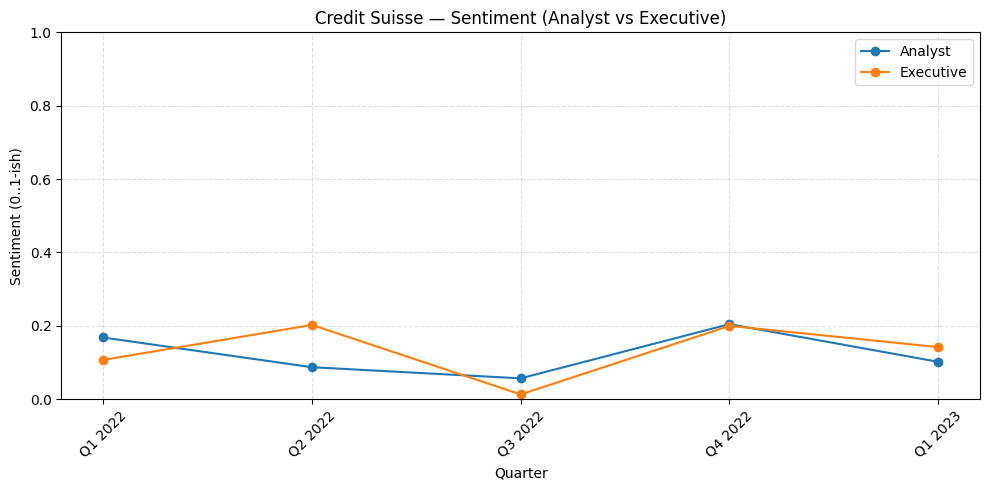

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/sentiment_trend_Credit_Suisse.png


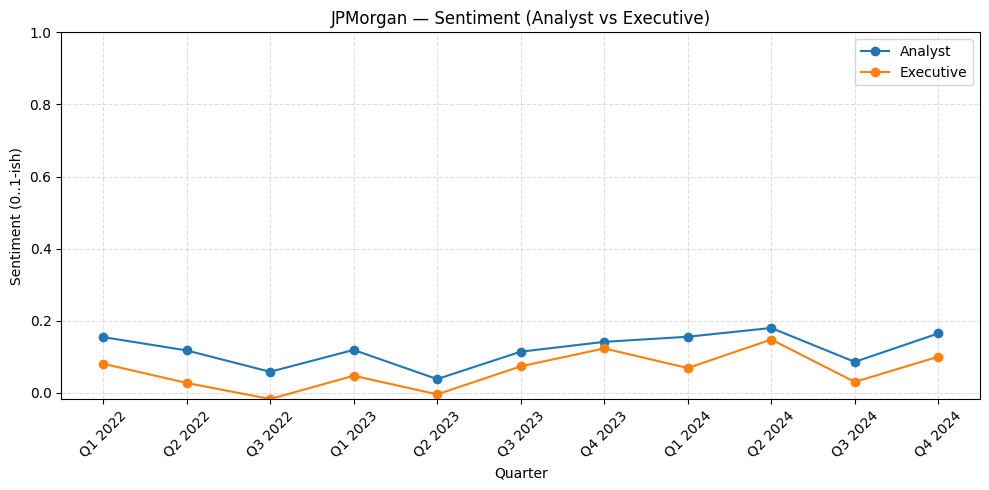

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/sentiment_trend_JPMorgan.png


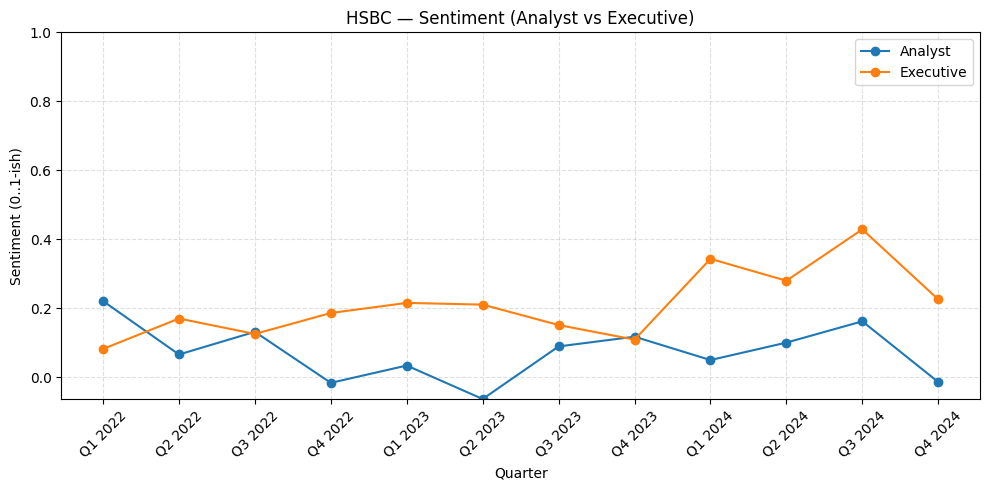

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/sentiment_trend_HSBC.png


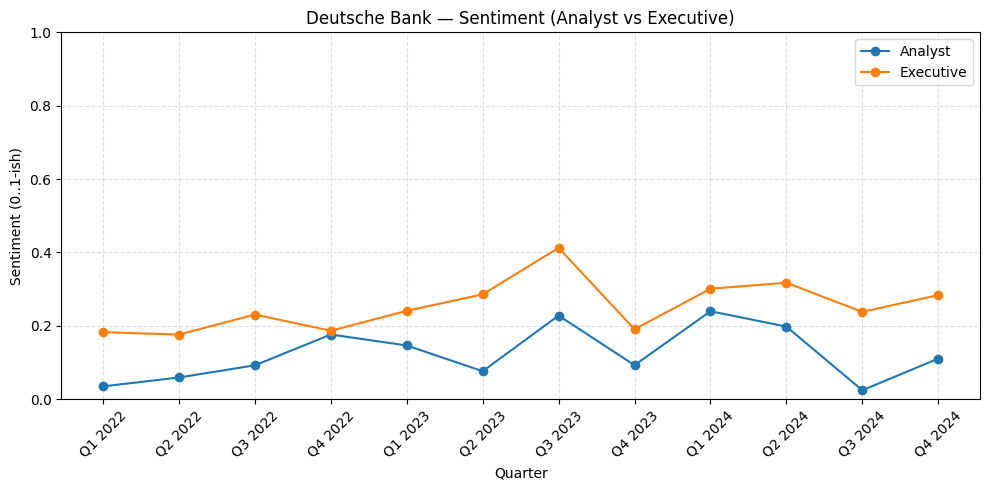

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/sentiment_trend_Deutsche_Bank.png


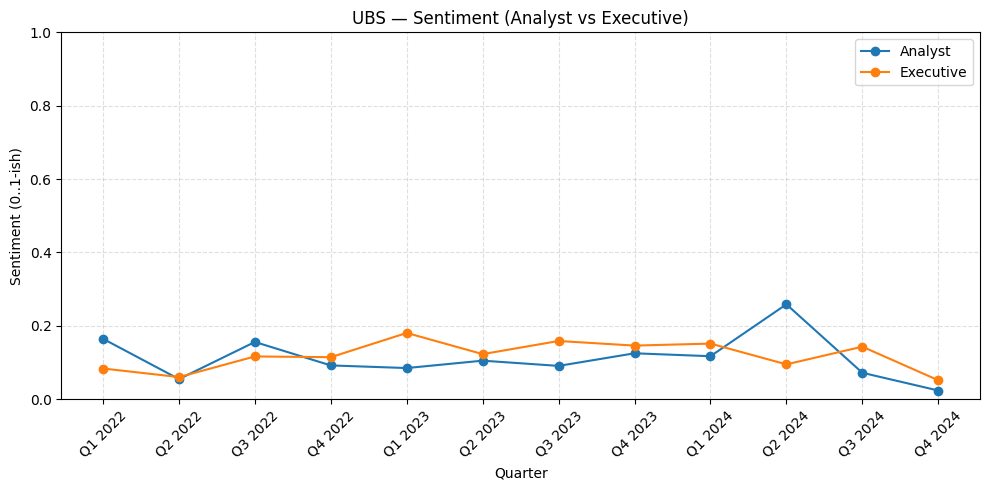

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/sentiment_trend_UBS.png


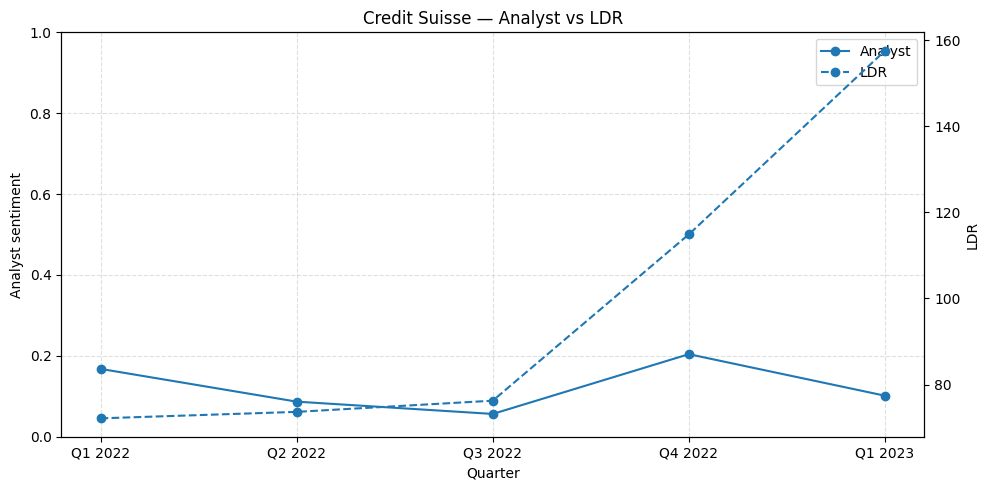

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Credit_Suisse_Analyst_vs_LDR.png


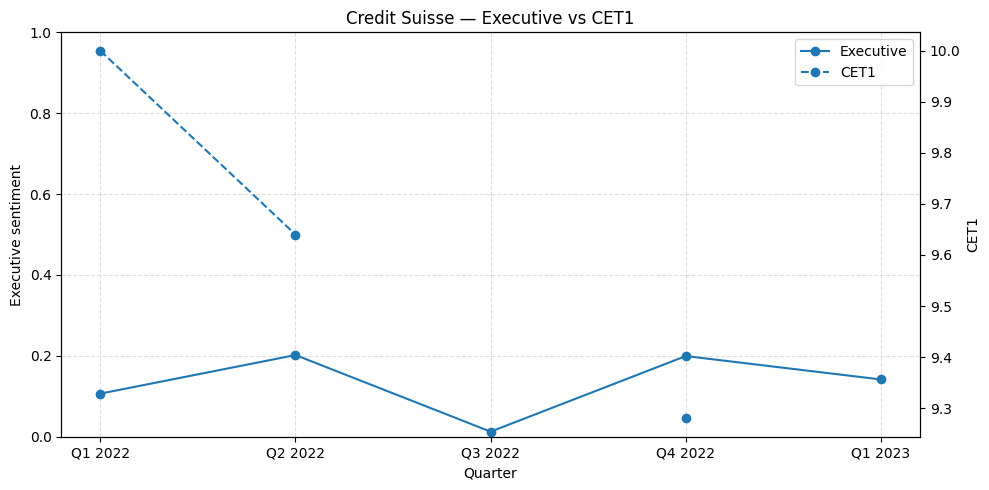

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Credit_Suisse_Executive_vs_CET1.png


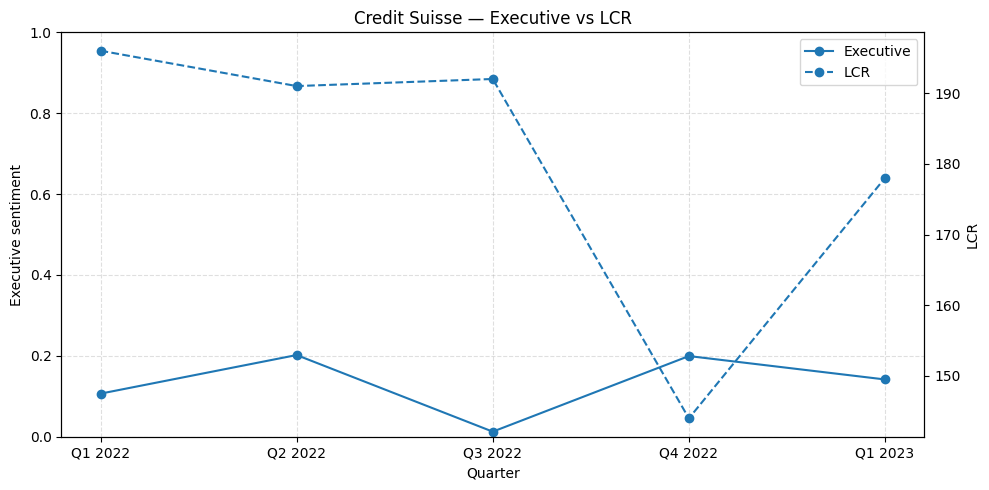

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Credit_Suisse_Executive_vs_LCR.png


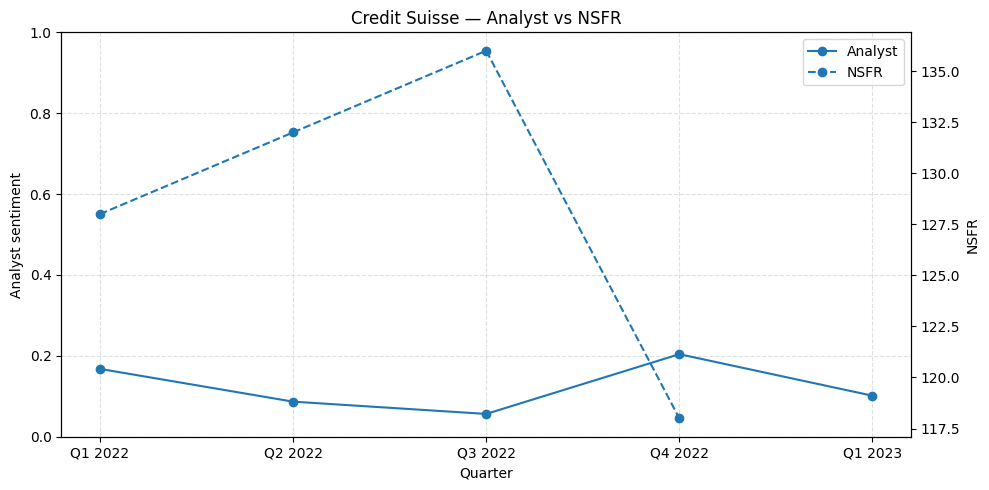

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Credit_Suisse_Analyst_vs_NSFR.png


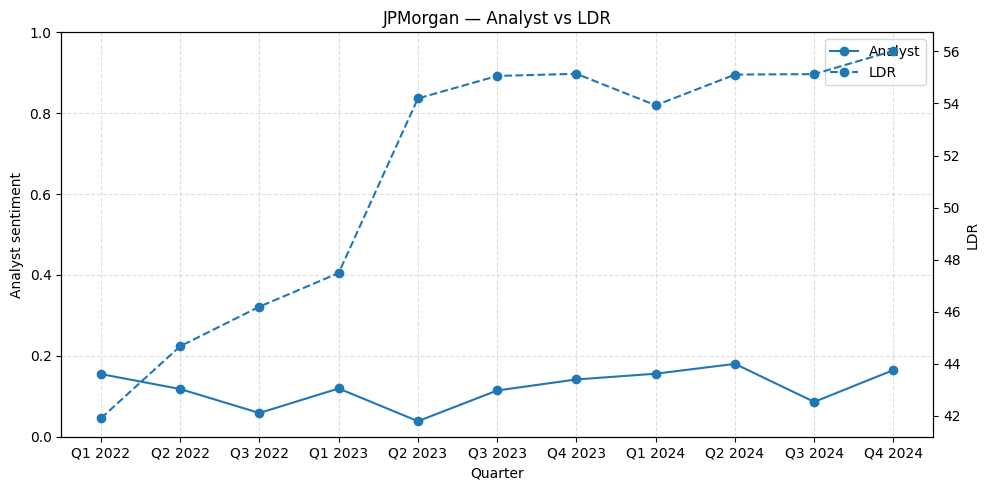

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_JPMorgan_Analyst_vs_LDR.png


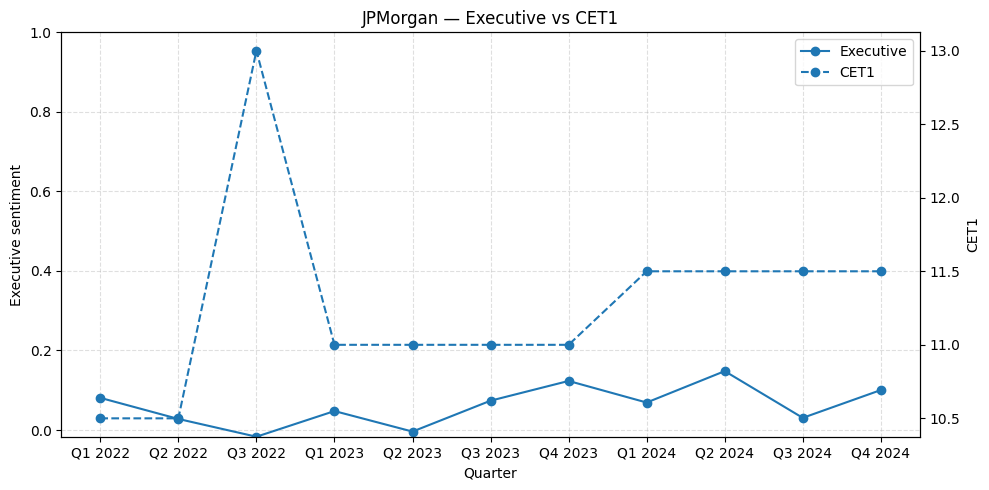

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_JPMorgan_Executive_vs_CET1.png


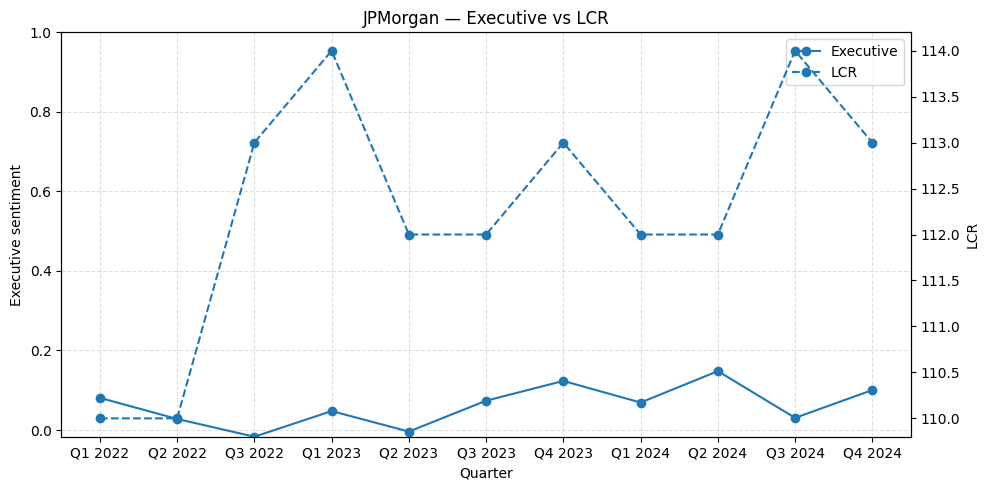

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_JPMorgan_Executive_vs_LCR.png


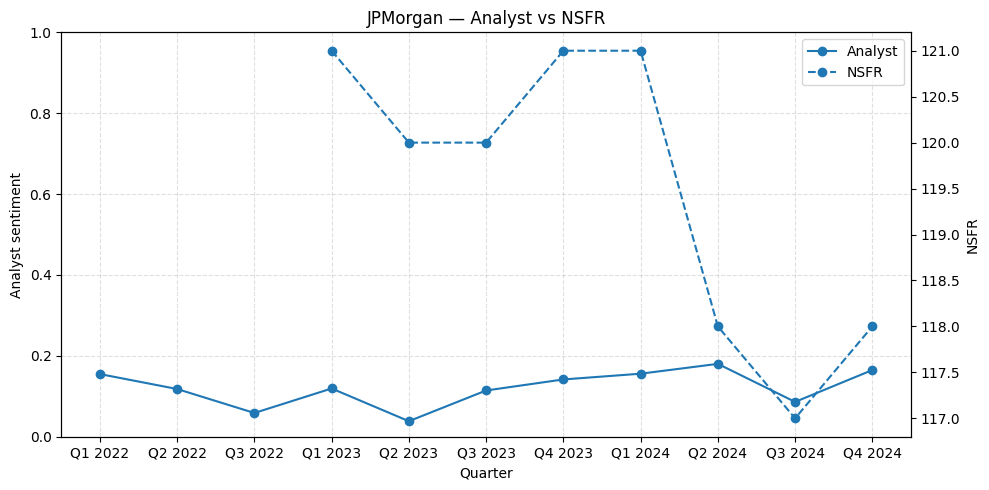

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_JPMorgan_Analyst_vs_NSFR.png


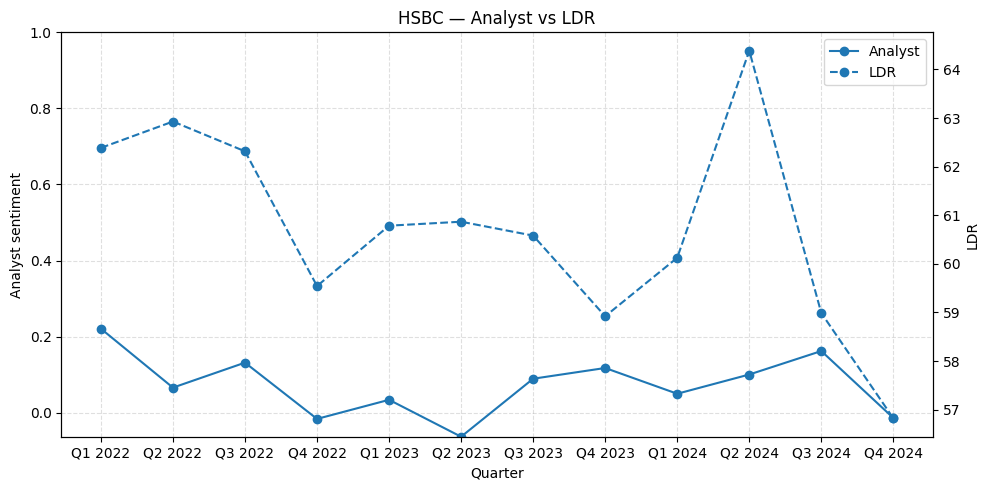

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_HSBC_Analyst_vs_LDR.png


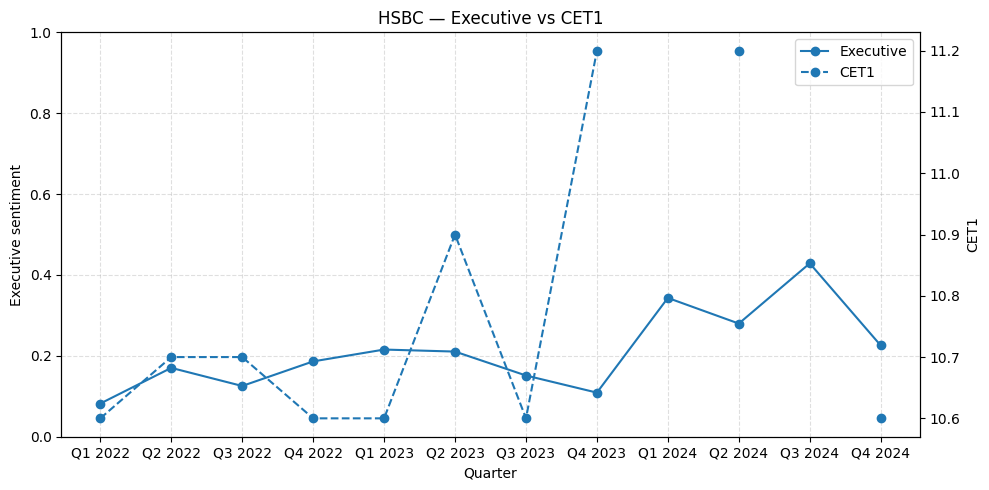

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_HSBC_Executive_vs_CET1.png


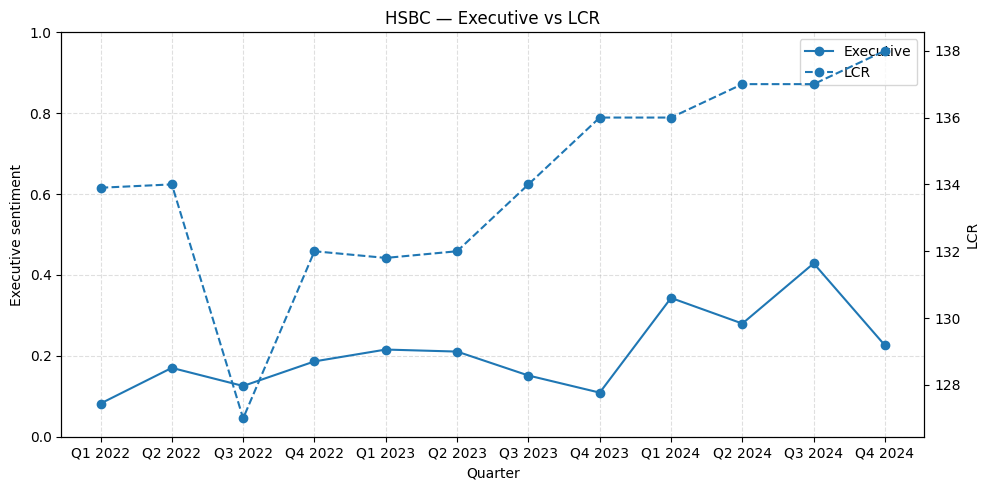

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_HSBC_Executive_vs_LCR.png


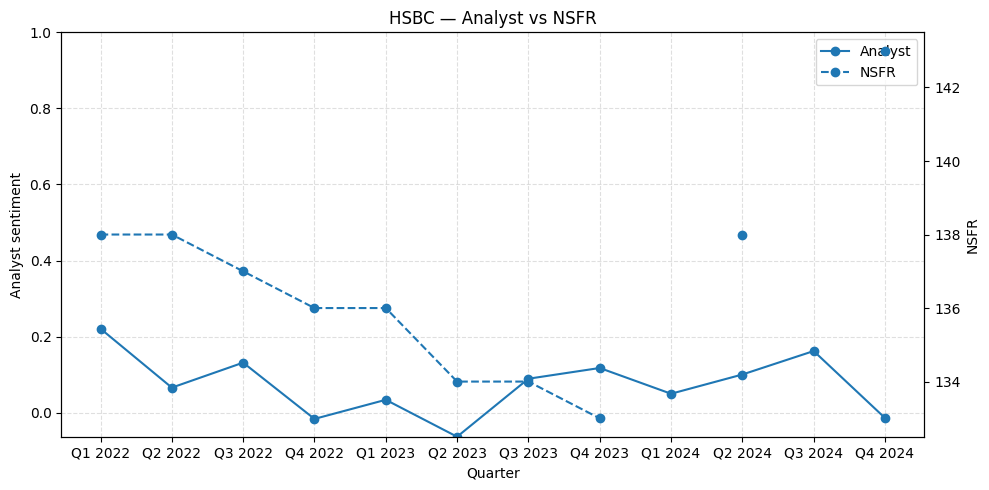

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_HSBC_Analyst_vs_NSFR.png


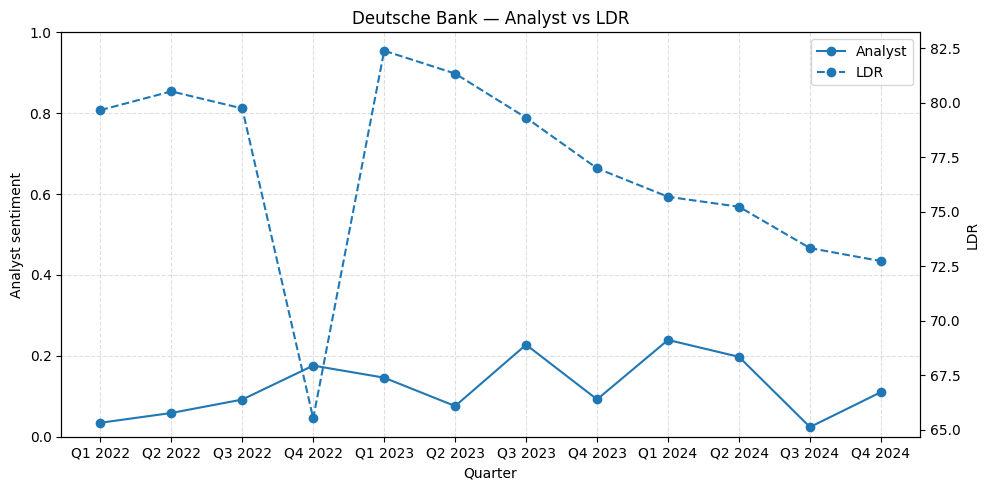

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Deutsche_Bank_Analyst_vs_LDR.png


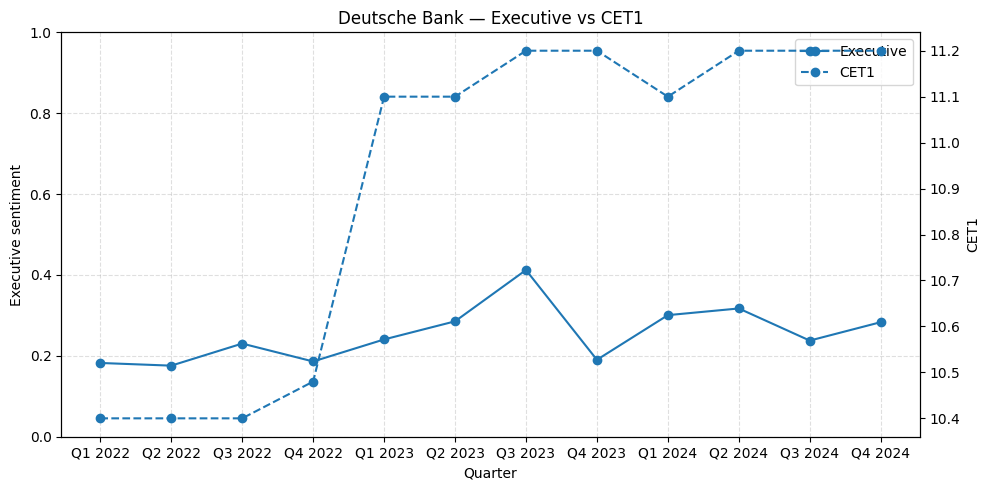

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Deutsche_Bank_Executive_vs_CET1.png


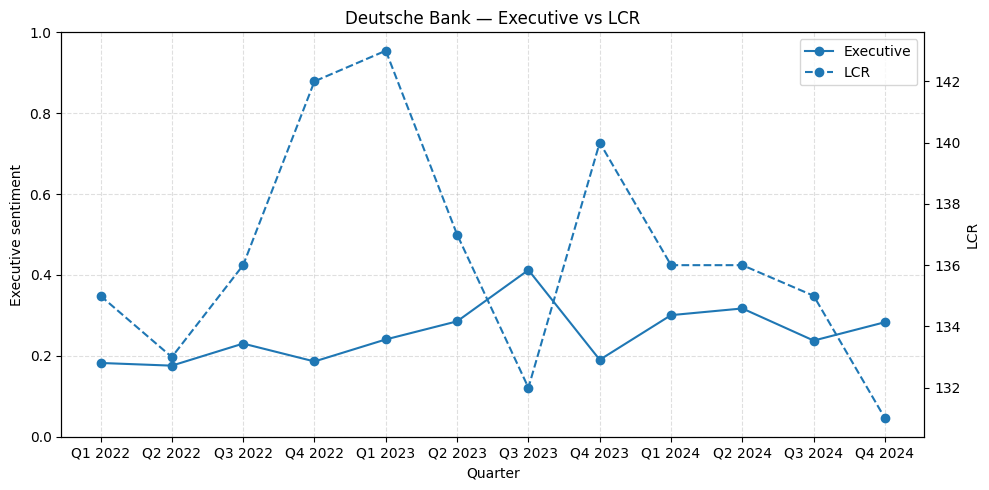

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Deutsche_Bank_Executive_vs_LCR.png


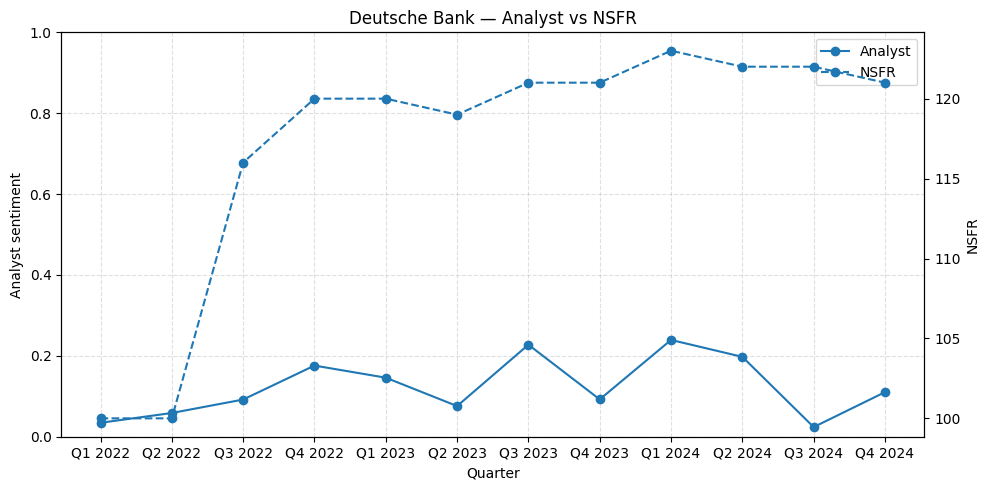

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_Deutsche_Bank_Analyst_vs_NSFR.png


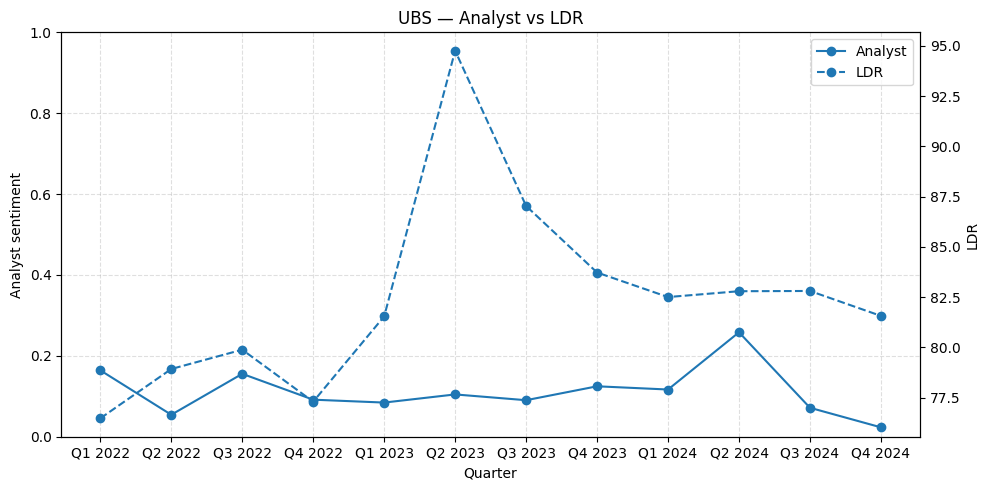

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_UBS_Analyst_vs_LDR.png


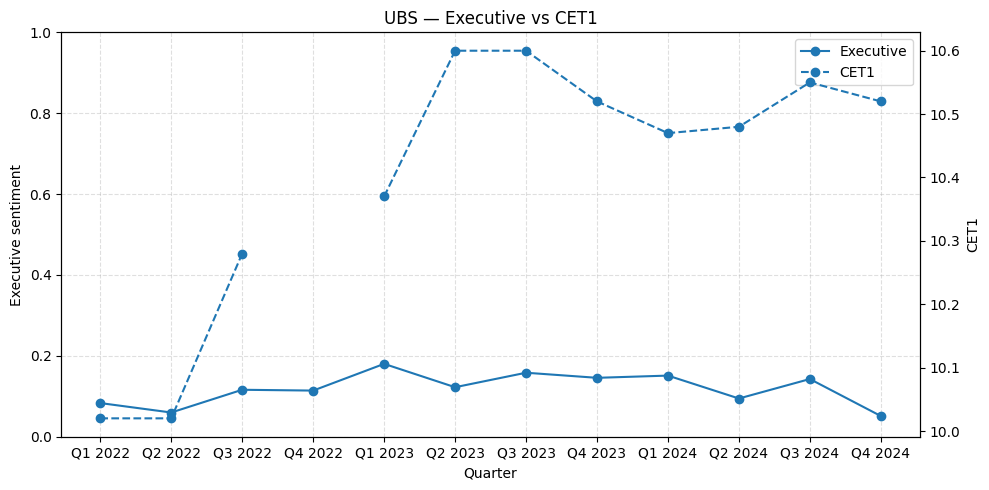

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_UBS_Executive_vs_CET1.png


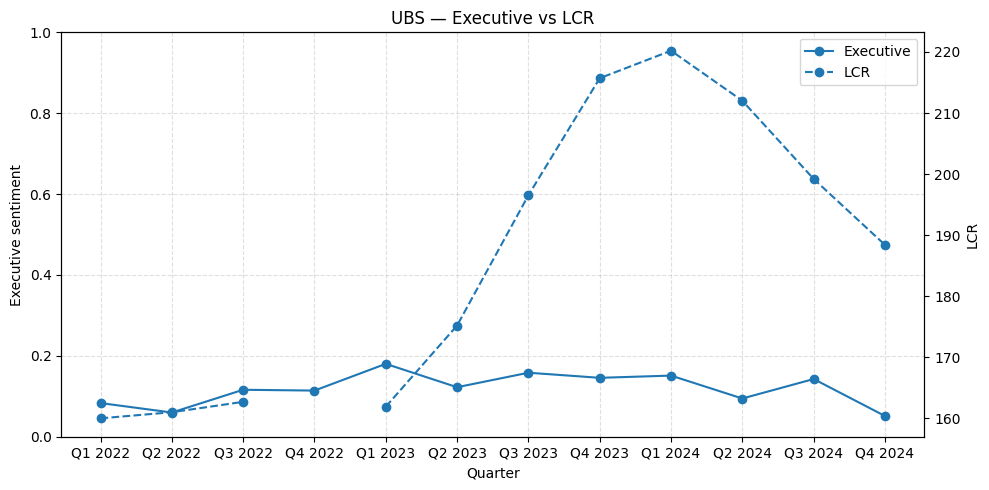

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_UBS_Executive_vs_LCR.png


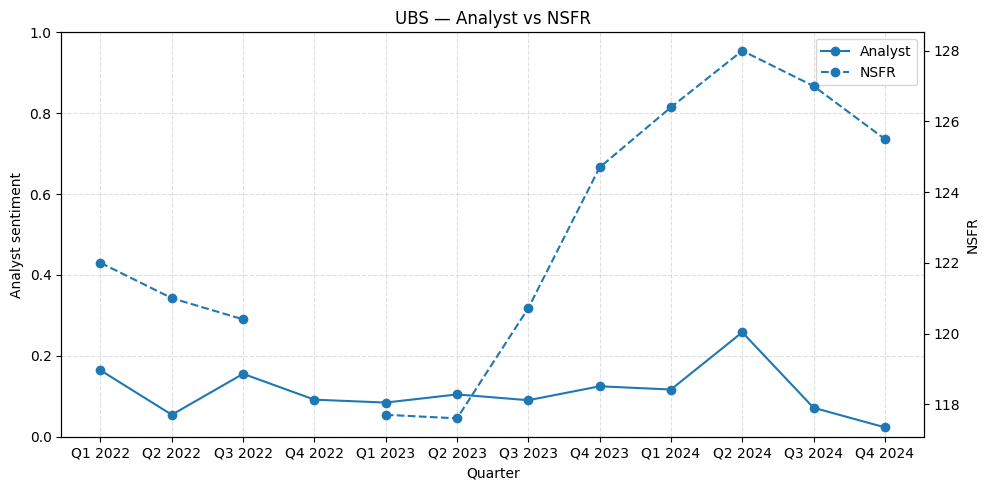

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/overlay_UBS_Analyst_vs_NSFR.png
✅ Saved correlation summary: /content/drive/MyDrive/Bank of England - Project/outputs/emotion_temporal/emotion_fundamentals_correlations.csv


In [ ]:
# === Plot sentiment vs fundamentals (inline + saved next to CSV) ===
import re
import unicodedata
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Paths -----
PROJECT_ROOT = Path("/content/drive/MyDrive/Bank of England - Project")
SENT_DIR     = PROJECT_ROOT / "outputs" / "emotion_temporal"
CSV_PATH     = SENT_DIR / "emotion_vs_fundamentals.csv"       # your merged file
FUND_DIR     = PROJECT_ROOT / "outputs" / "fundamental_analysis" / "tables"
FUND_CSV     = FUND_DIR / "fundamentals__ALL.csv"             # Louis' master
PLOT_DIR     = SENT_DIR                                       # save alongside CSV

print("Saving plots to:", PLOT_DIR)

# ----- Helpers -----
def normalize_quarter_to_QY(q: str) -> str:
    """Normalize many quarter formats to 'Q# YYYY'."""
    if not isinstance(q, str):
        return q
    s = q.strip().upper().replace("–", "-").replace("—", "-").replace("\\n", " ").replace("\n", " ")
    s = re.sub(r"\s+", " ", s)
    m = re.match(r"^(\d{4})\s*[-/]?\s*Q0?([1-4])$", s);     # 2023Q3, 2023-Q3
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q0?([1-4])\s*[-/]?\s*(\d{4})$", s);     # Q3 2023
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q([1-4])\s*([0-9]{2})$", s);            # Q323
    if m: qq, yy = m.groups(); return f"Q{int(qq)} {2000 + int(yy)}"
    m = re.match(r"^([1-4])\s*Q\s*([0-9]{2,4})$", s);       # 3Q23, 3Q 2023
    if m:
        qq, year = m.groups()
        yr = year if len(year) == 4 else str(2000 + int(year))
        return f"Q{int(qq)} {yr}"
    m = re.match(r"^(\d{4})\s+Q([1-4])$", s);               # 2023 Q3
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q0?([1-4])\s+(\d{4})$", s);             # Q3    2023
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    return s.title()

def quarter_sort_key(q: str):
    m = re.match(r"^Q([1-4])\s+(\d{4})$", str(q))
    return (int(m.group(2)), int(m.group(1))) if m else (9999, 9)

def strip_accents(s: str) -> str:
    s_norm = unicodedata.normalize("NFKD", s or "")
    return "".join(ch for ch in s_norm if not unicodedata.combining(ch))

def clean_louis_bank_raw(val: str) -> str:
    """Map Louis' funky labels to canonical names."""
    if not isinstance(val, str):
        return val
    v = strip_accents(val).lower().strip()
    v = re.sub(r"^fundamental[_\-]+", "", v)  # drop prefix
    v = v.replace("cr_dit", "credit").replace("soci_t", "societe").replace("g_n", "ge")
    v = re.sub(r"[_\s]+", " ", v).strip()
    v = v.replace("jp morgan", "jpmorgan")
    # final mapping
    mapping = {
        "ubs": "UBS",
        "societe generale": "Societe Generale",
        "credit suisse": "Credit Suisse",
        "barclays": "Barclays",
        "deutsche": "Deutsche Bank",
        "deutsche bank": "Deutsche Bank",
        "hsbc": "HSBC",
        "jpmorgan": "JPMorgan",
        "jpmorgan chase": "JPMorgan",
    }
    return mapping.get(v, v.title())

def find_fund_cols(df: pd.DataFrame):
    """
    Return dict of canonical -> actual column names for fundamentals.
    Flexible matching on common variations.
    """
    want = {
        "CET1 (Common Equity Tier 1)": r"\bcet1\b",
        "LDR (Loan to Deposit Ratio)":  r"\bldr\b|loan\s*to\s*deposit",
        "LCR (Liquidity Coverage Ratio)": r"\blcr\b|liquidity\s*coverage",
        "NSFR (Net Stable Funding Ratio)": r"\bnsfr\b|net\s*stable\s*fund",
    }
    found = {}
    for canon, pat in want.items():
        rx = re.compile(pat, re.I)
        match = next((c for c in df.columns if rx.search(str(c))), None)
        if match:
            found[canon] = match
    return found

def _safe_series(df, col):
    return df[col] if col in df.columns else pd.Series(index=df.index, dtype=float)

def _overlay_plot(df_bank, bank, sent_col, fund_col, ylabel_left, ylabel_right, fname_tag):
    """Dual-axis overlay. Shows inline and saves PNG."""
    s_sent = _safe_series(df_bank, sent_col)
    s_fund = _safe_series(df_bank, fund_col)
    if s_sent.dropna().empty and s_fund.dropna().empty:
        return False

    x = df_bank['fiscal_quarter'].tolist()
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(x, s_sent.values, marker="o", label=sent_col)
    ax1.set_ylabel(ylabel_left)
    ax1.set_xlabel("Quarter")
    # scale sentiment axis
    y_min = np.nanmin(s_sent.values) if s_sent.notna().any() else 0
    y_max = np.nanmax(s_sent.values) if s_sent.notna().any() else 1
    ax1.set_ylim(min(0, y_min), max(1, y_max))

    ax2.plot(x, s_fund.values, marker="o", linestyle="--", label=fund_col)
    ax2.set_ylabel(ylabel_right)

    plt.title(f"{bank} — {sent_col} vs {fund_col}")
    plt.xticks(rotation=45)
    ax1.grid(True, linestyle="--", alpha=0.4)

    # joint legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.tight_layout()
    out = PLOT_DIR / f"overlay_{bank.replace(' ', '_')}_{fname_tag}.png"
    plt.savefig(out, dpi=200)
    plt.show()     # display inline
    plt.close(fig)
    print("🖼️ saved:", out)
    return True

# ----- Load merged; fallback merge if needed -----
if not CSV_PATH.exists():
    raise FileNotFoundError(f"Cannot find merged CSV at {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Standardize keys
df['company'] = df['company'].astype(str).str.strip().replace({
    'Creditsuisse': 'Credit Suisse',
    'CreditSuisse': 'Credit Suisse',
    'JP Morgan': 'JPMorgan',
    'JPMorgan Chase': 'JPMorgan',
    'UBS Group': 'UBS',
})
df['fiscal_quarter'] = df['fiscal_quarter'].astype(str).map(normalize_quarter_to_QY)

# If fundamental columns are missing, try to inject by merging raw fundamentals
fund_map = find_fund_cols(df)
if len(fund_map) == 0 and FUND_CSV.exists():
    print("No fundamental cols in merged CSV. Falling back to join with fundamentals__ALL.csv ...")
    fund = pd.read_csv(FUND_CSV)
    # identify bank and quarter cols
    low = {c.lower(): c for c in fund.columns}
    f_bank = next((low.get(k) for k in ("bank","company","bank_name","company_name") if k in low), None)
    f_qtr  = next((low.get(k) for k in ("quarter_label","fiscal_quarter","quarter") if k in low), None)
    if f_bank is None or f_qtr is None:
        raise ValueError("Could not detect bank/quarter columns in fundamentals__ALL.csv")

    fund = fund.rename(columns={f_bank: "company", f_qtr: "fiscal_quarter"})
    fund["company"] = fund["company"].astype(str).map(clean_louis_bank_raw)
    fund["fiscal_quarter"] = fund["fiscal_quarter"].astype(str).map(normalize_quarter_to_QY)

    # bring through all columns (we’ll pick the ones we need later)
    df = df.merge(fund, on=["company","fiscal_quarter"], how="left")
    # re-detect after merge
    fund_map = find_fund_cols(df)

# Sort by quarter
df = df.sort_values('fiscal_quarter', key=lambda s: s.map(quarter_sort_key)).reset_index(drop=True)

# Sentiment columns present
sentiment_cols = [c for c in ['Analyst', 'Executive'] if c in df.columns]

# Final fundamental columns (canonical → actual)
fund_map = find_fund_cols(df)
fundamental_cols_actual = list(fund_map.values())
fundamental_cols_canon  = list(fund_map.keys())

if not sentiment_cols:
    print("No sentiment columns found. Expected one of:", ['Analyst', 'Executive'])
if not fundamental_cols_actual:
    print("No fundamental columns found after fallback. Looked for CET1, LDR, LCR, NSFR.")
else:
    print("Fundamental columns detected:", {k: v for k, v in fund_map.items()})

# ----- Plot per-bank -----
banks = df['company'].dropna().unique().tolist()
print("Banks found:", banks)

# 1) sentiment trend per bank
for bank in banks:
    sub = df[df['company'] == bank].copy()
    sub = sub.sort_values('fiscal_quarter', key=lambda s: s.map(quarter_sort_key))

    if set(['Analyst', 'Executive']).issubset(sub.columns):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(sub['fiscal_quarter'], sub['Analyst'], marker="o", label='Analyst')
        ax.plot(sub['fiscal_quarter'], sub['Executive'], marker="o", label='Executive')
        ax.set_title(f"{bank} — Sentiment (Analyst vs Executive)")
        ax.set_xlabel("Quarter"); ax.set_ylabel("Sentiment (0..1-ish)")
        y_min = np.nanmin(sub[['Analyst','Executive']].values)
        y_max = np.nanmax(sub[['Analyst','Executive']].values)
        ax.set_ylim(min(0, y_min), max(1, y_max))
        plt.xticks(rotation=45); ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(loc="best")
        plt.tight_layout()
        out = PLOT_DIR / f"sentiment_trend_{bank.replace(' ', '_')}.png"
        plt.savefig(out, dpi=200)
        plt.show()   # inline
        plt.close(fig)
        print("🖼️ saved:", out)

# 2) Overlays for key pairs if fundamentals exist
for bank in banks:
    sub = df[df['company'] == bank].copy().sort_values('fiscal_quarter', key=lambda s: s.map(quarter_sort_key))

    # Analyst vs LDR
    ldr_col = fund_map.get("LDR (Loan to Deposit Ratio)")
    if 'Analyst' in sub.columns and ldr_col in sub.columns:
        _overlay_plot(sub, bank, 'Analyst', ldr_col, 'Analyst sentiment', 'LDR', 'Analyst_vs_LDR')

    # Executive vs CET1
    cet1_col = fund_map.get("CET1 (Common Equity Tier 1)")
    if 'Executive' in sub.columns and cet1_col in sub.columns:
        _overlay_plot(sub, bank, 'Executive', cet1_col, 'Executive sentiment', 'CET1', 'Executive_vs_CET1')

    # Executive vs LCR
    lcr_col = fund_map.get("LCR (Liquidity Coverage Ratio)")
    if 'Executive' in sub.columns and lcr_col in sub.columns:
        _overlay_plot(sub, bank, 'Executive', lcr_col, 'Executive sentiment', 'LCR', 'Executive_vs_LCR')

    # Analyst vs NSFR
    nsfr_col = fund_map.get("NSFR (Net Stable Funding Ratio)")
    if 'Analyst' in sub.columns and nsfr_col in sub.columns:
        _overlay_plot(sub, bank, 'Analyst', nsfr_col, 'Analyst sentiment', 'NSFR', 'Analyst_vs_NSFR')

# 3) Optional correlations table next to CSV
corr_rows = []
for bank in banks:
    sub = df[df['company'] == bank].copy().sort_values('fiscal_quarter', key=lambda s: s.map(quarter_sort_key))
    for s_col in ['Analyst', 'Executive']:
        if s_col not in sub.columns:
            continue
        for canon, actual in fund_map.items():
            if actual not in sub.columns:
                continue
            pair = sub[[s_col, actual]].dropna()
            if len(pair) >= 3:
                corr_rows.append({
                    'company': bank,
                    'sentiment': s_col,
                    'fundamental': canon,
                    'pearson_corr': pair[s_col].corr(pair[actual]),
                    'n_obs': len(pair)
                })

if corr_rows:
    corr_df = pd.DataFrame(corr_rows).sort_values(['company','sentiment','fundamental'])
    corr_out = SENT_DIR / "emotion_fundamentals_correlations.csv"
    corr_df.to_csv(corr_out, index=False)
    print("✅ Saved correlation summary:", corr_out)
else:
    print("Note: Not enough overlapping data to compute correlations (or no shared columns present).")


Resolved ABSA dir (discovered): /content/drive/MyDrive/Bank of England - Project/ABSA results per bank quarter (CSV files: 6)
✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_timeseries_overall__spin.csv
✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_timeseries_by_aspect__spin.csv


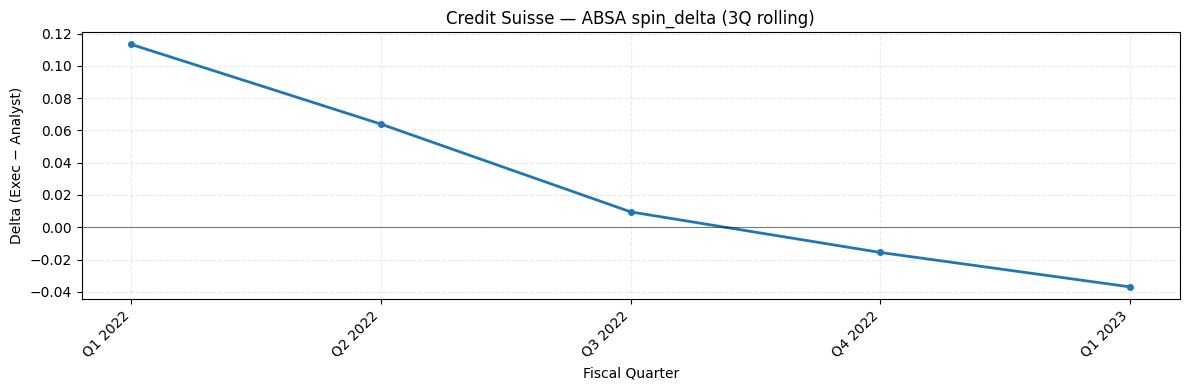

🖼️ + 📄 Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_Credit_Suisse.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_Credit_Suisse.csv


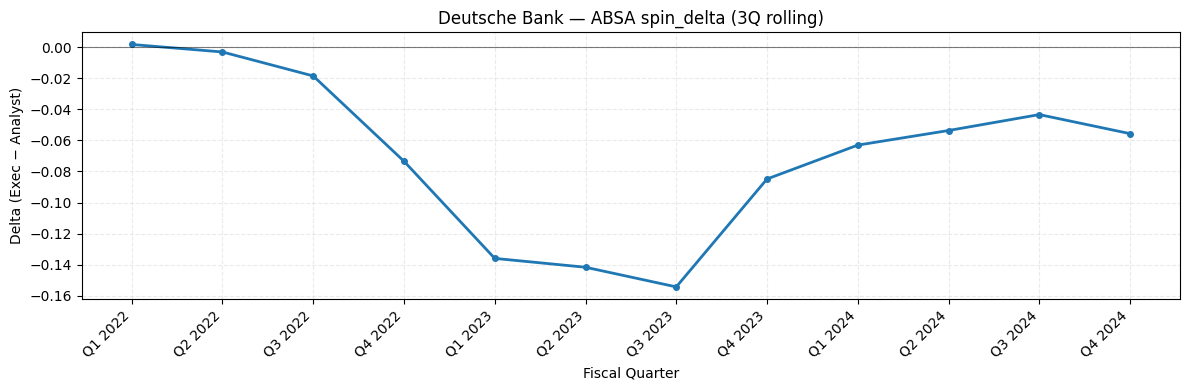

🖼️ + 📄 Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_Deutsche_Bank.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_Deutsche_Bank.csv


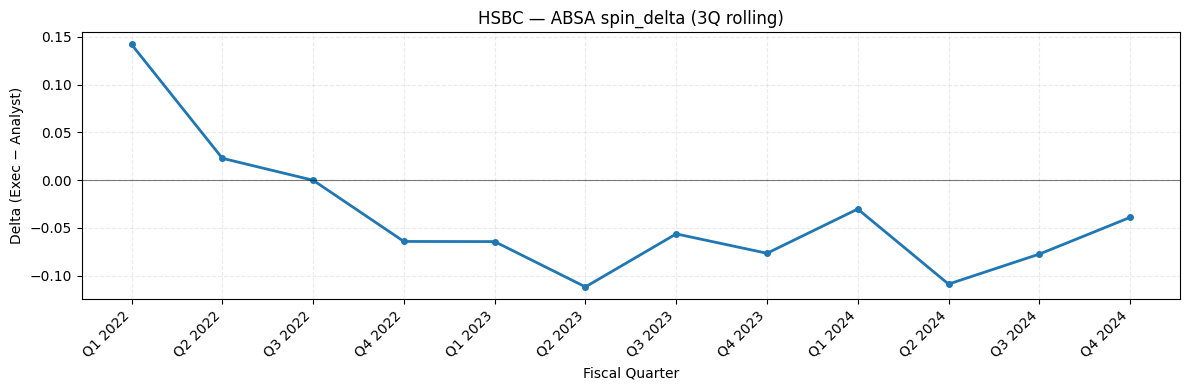

🖼️ + 📄 Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_HSBC.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_HSBC.csv


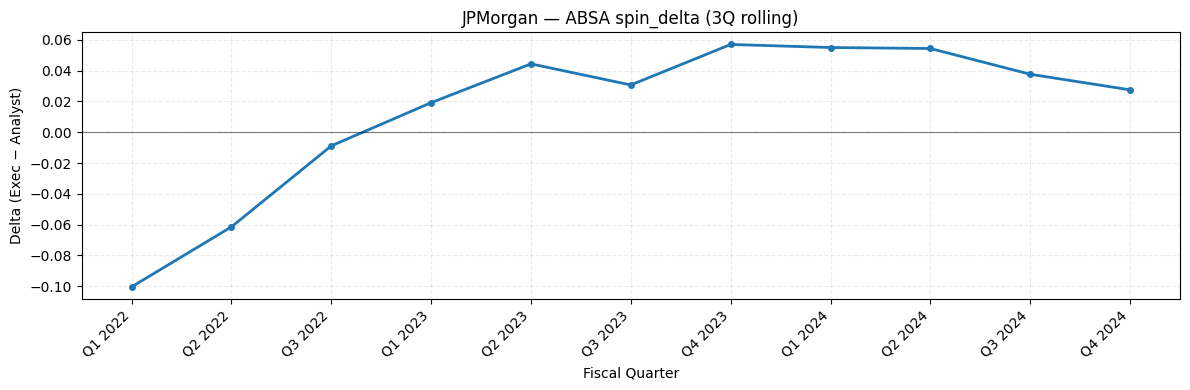

🖼️ + 📄 Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_JPMorgan.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_JPMorgan.csv


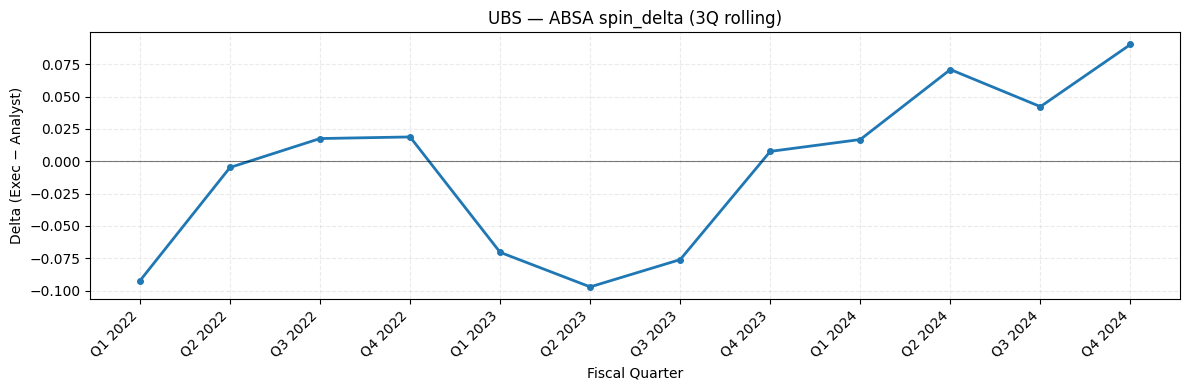

🖼️ + 📄 Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_UBS.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_spin_delta_UBS.csv


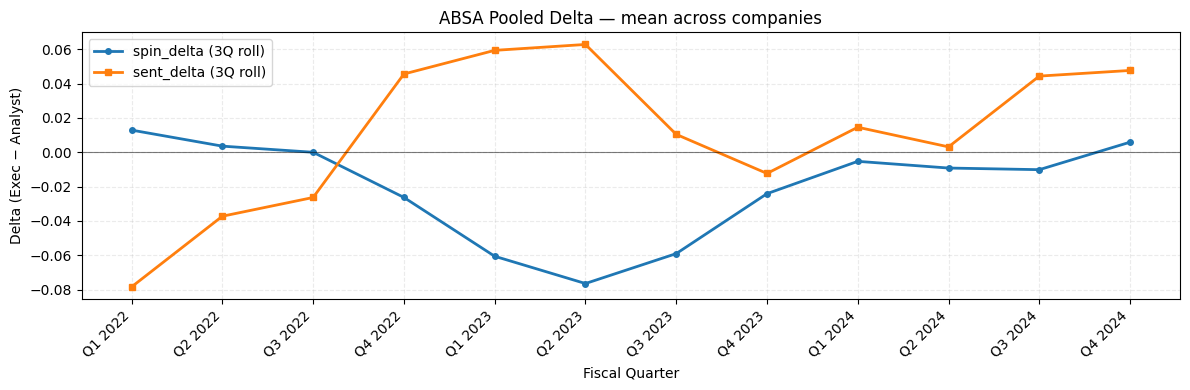

✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_pooled_deltas__spin.png | /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_pooled_deltas__spin.csv


In [ ]:
# === TIME SERIES (ABSA): robust folder resolution for 'ABSA results per bank/quarter' ===
# Saves to: /outputs/time_series_absa
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'PROJECT_ROOT' in globals(), "PROJECT_ROOT not defined — set it first."
PROJECT_ROOT = Path(PROJECT_ROOT)

BASE_OUTPUT  = PROJECT_ROOT / "outputs"
TS_ABSA_DIR  = BASE_OUTPUT / "time_series_absa"
TS_ABSA_DIR.mkdir(parents=True, exist_ok=True)

def _resolve_absa_dir(root: Path) -> Path:
    """
    Try multiple interpretations of 'ABSA results per bank/quarter':
    1) Nested folders: 'ABSA results per bank' / 'quarter'
    2) Single folder name using Unicode slash ⁄ (U+2044) or ∕ (U+2215)
    3) Best-guess discovery: pick the folder under root with the most CSVs
       where folder name contains 'absa' and 'quarter' (case-insensitive).
    """
    # 1) Nested folders (most common)
    nested = root / "ABSA results per bank" / "quarter"
    if nested.exists():
        print(f"Resolved ABSA dir (nested): {nested}")
        return nested

    # 2) Single folder name with Unicode slash lookalikes
    candidates_single = [
        root / "ABSA results per bank\u2044quarter",  # FRACTION SLASH
        root / "ABSA results per bank\u2215quarter",  # DIVISION SLASH
    ]
    for c in candidates_single:
        if c.exists():
            print(f"Resolved ABSA dir (single-name with Unicode slash): {c}")
            return c

    # 3) Best-guess discovery: look for dirs whose name hints at 'absa' and 'quarter'
    #    and that contain CSVs. Pick the one with most CSVs.
    best_dir, best_count = None, -1
    for d in root.rglob("*"):
        try:
            if not d.is_dir():
                continue
            name_lower = d.name.lower()
            # require both tokens somewhere along the path
            path_text = str(d).lower()
            if "absa" in path_text and "quarter" in path_text:
                count = len(list(d.glob("*.csv")))
                if count > best_count and count > 0:
                    best_dir, best_count = d, count
        except Exception:
            pass

    if best_dir:
        print(f"Resolved ABSA dir (discovered): {best_dir} (CSV files: {best_count})")
        return best_dir

    raise FileNotFoundError(
        "Could not resolve the ABSA folder. Tried:\n"
        f"- {nested}\n"
        f"- ABSA results per bank⁄quarter (single folder name)\n"
        f"- ABSA results per bank∕quarter (single folder name)\n"
        "…and best-guess discovery under PROJECT_ROOT."
    )

ABSA_DIR = _resolve_absa_dir(PROJECT_ROOT)

# --------- Helpers ---------
def normalize_quarter_to_QY(q):
    if pd.isna(q): return q
    s = str(q).strip().upper().replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    if s.isdigit() and len(s) in (5, 6):          # 20221 or 202203 -> Q1 2022
        yr = int(s[:4]); qq = int(s[4:]) if len(s)==5 else ((int(s[4:6])+2)//3)
        if qq in (1,2,3,4): return f"Q{qq} {yr}"
    m = re.match(r"^(\d{4})\s*[-/]?\s*Q0?([1-4])$", s)
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q0?([1-4])\s*[-/]?\s*(\d{4})$", s)
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q([1-4])\s*([0-9]{2})$", s)
    if m: qq, yy = m.groups(); return f"Q{int(qq)} {2000+int(yy)}"
    m = re.match(r"^([1-4])\s*Q\s*([0-9]{2,4})$", s)
    if m:
        qq, year = m.groups(); yr = int(year) if len(year)==4 else 2000+int(year)
        return f"Q{int(qq)} {yr}"
    m = re.match(r"^(\d{4})\s+Q([1-4])$", s)
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^Q0?([1-4])\s+(\d{4})$", s)
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    return s.title()

def quarter_sort_key(q):
    m = re.match(r"^Q([1-4])\s+(\d{4})$", str(q))
    return (int(m.group(2)), int(m.group(1))) if m else (9999, 9)

def clean_bank_name(x: str) -> str:
    if not isinstance(x, str): return x
    s = x.strip()
    mapping = {
        'Creditsuisse': 'Credit Suisse',
        'CreditSuisse': 'Credit Suisse',
        'JP Morgan': 'JPMorgan',
        'JPMorgan Chase': 'JPMorgan',
        'UBS Group': 'UBS',
        'Deutsche': 'Deutsche Bank',
        'Deutsche bank': 'Deutsche Bank',
    }
    return mapping.get(s, s)

def _best_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# --------- Ingest all ABSA CSVs from the folder (recursively) ---------
files = list(ABSA_DIR.rglob("*.csv"))
if not files:
    raise FileNotFoundError(f"No CSVs found under {ABSA_DIR}")

frames = []
for fp in files:
    try:
        frames.append(pd.read_csv(fp))
    except Exception as e:
        print(f"⚠️ Skipping {fp.name}: {e}")

if not frames:
    raise ValueError("No readable ABSA CSVs in the folder.")
absa = pd.concat(frames, ignore_index=True)

# --------- Flexible column detection ---------
bank_col = _best_col(absa, ["bank","company","Bank","Company","ticker"])
q_col    = _best_col(absa, ["quarter_norm","fiscal_quarter","quarter","quarter_label","quarter_key","quarter_key_y"])
if bank_col is None or q_col is None:
    raise ValueError("Could not detect bank and/or quarter columns in ABSA CSVs.")

absa["company"]        = absa[bank_col].map(clean_bank_name)
absa["fiscal_quarter"] = absa[q_col].map(normalize_quarter_to_QY)

# Spin exec/analyst + delta (preferred for ABSA time series)
spin_exec  = _best_col(absa, ["spin_score_EXEC","spin_exec","spin_EXEC","spin_score_exec"])
spin_anly  = _best_col(absa, ["spin_score_ANALYST","spin_analyst","spin_ANALYST","spin_score_analyst"])
spin_delta = _best_col(absa, ["delta_spin","spin_delta","spin_diff","delta_spin_exec_minus_analyst"])

# Net sentiment exec/analyst + delta (fallback)
sent_exec  = _best_col(absa, ["sent_EXEC","sentiment_EXEC","net_sent_EXEC","pos_minus_neg_EXEC","posminusneg_EXEC"])
sent_anly  = _best_col(absa, ["sent_ANALYST","sentiment_ANALYST","net_sent_ANALYST","pos_minus_neg_ANALYST","posminusneg_ANALYST"])

if sent_exec is None and {"p_pos_EXEC","p_neg_EXEC"}.issubset(absa.columns):
    absa["__sent_EXEC_net"] = absa["p_pos_EXEC"] - absa["p_neg_EXEC"]; sent_exec = "__sent_EXEC_net"
if sent_anly is None and {"p_pos_ANALYST","p_neg_ANALYST"}.issubset(absa.columns):
    absa["__sent_ANALYST_net"] = absa["p_pos_ANALYST"] - absa["p_neg_ANALYST"]; sent_anly = "__sent_ANALYST_net"

if spin_delta is None and spin_exec and spin_anly:
    absa["__spin_delta"] = absa[spin_exec] - absa[spin_anly]; spin_delta = "__spin_delta"
sent_delta = None
if (sent_exec is not None) and (sent_anly is not None):
    absa["__sent_delta"] = absa[sent_exec] - absa[sent_anly]; sent_delta = "__sent_delta"

aspect_col = _best_col(absa, ["aspect","Aspect","topic","Topic"])

# --------- Aggregate per bank x quarter ---------
group_keys = ["company","fiscal_quarter"]
agg_cols = {}
if spin_exec:  agg_cols["spin_exec"]  = (spin_exec, "mean")
if spin_anly:  agg_cols["spin_anly"]  = (spin_anly, "mean")
if spin_delta: agg_cols["spin_delta"] = (spin_delta, "mean")
if sent_exec:  agg_cols["sent_exec"]  = (sent_exec, "mean")
if sent_anly:  agg_cols["sent_anly"]  = (sent_anly, "mean")
if sent_delta: agg_cols["sent_delta"] = (sent_delta, "mean")

if not agg_cols:
    raise ValueError("No usable ABSA columns found for time series (spin or sentiment).")

agg_spec = {out: pd.NamedAgg(column=col, aggfunc=fn) for out, (col, fn) in agg_cols.items()}
overall = (absa.groupby(group_keys, dropna=False)
                .agg(**agg_spec)
                .reset_index()
                .sort_values("fiscal_quarter", key=lambda s: s.map(quarter_sort_key)))

by_aspect = pd.DataFrame()
if aspect_col:
    by_aspect = (absa.groupby(group_keys + [aspect_col], dropna=False)
                      .agg(**agg_spec)
                      .reset_index()
                      .rename(columns={aspect_col:"aspect"})
                      .sort_values("fiscal_quarter", key=lambda s: s.map(quarter_sort_key)))

# --------- Add 3Q rolling ---------
def add_roll3(df, cols):
    if df.empty: return df
    def _apply(g):
        g = g.sort_values("fiscal_quarter", key=lambda s: s.map(quarter_sort_key)).copy()
        for c in cols:
            if c in g.columns:
                g[c + "_roll3"] = g[c].rolling(3, min_periods=1).mean()
        return g
    return df.groupby("company", group_keys=False).apply(_apply)

value_cols = [c for c in ["spin_exec","spin_anly","spin_delta","sent_exec","sent_anly","sent_delta"] if c in overall.columns]
overall   = add_roll3(overall, value_cols)
if not by_aspect.empty:
    by_aspect = add_roll3(by_aspect, value_cols)

# --------- Save master CSVs ---------
source_tag = "spin" if "spin_delta" in overall.columns else "discrepancy"
overall_out = TS_ABSA_DIR / f"absa_timeseries_overall__{source_tag}.csv"
overall.to_csv(overall_out, index=False)
print("✅ Saved:", overall_out)

if not by_aspect.empty:
    aspect_out = TS_ABSA_DIR / f"absa_timeseries_by_aspect__{source_tag}.csv"
    by_aspect.to_csv(aspect_out, index=False)
    print("✅ Saved:", aspect_out)

# --------- Plot per-company (spin_delta preferred; fallback to sent_delta) ---------
def _plot_company(df_overall, company, prefer_col="spin_delta", fallback_col="sent_delta", use_roll=True):
    sub = df_overall[df_overall["company"] == company].copy()
    if sub.empty:
        print(f"(no ABSA series for {company})"); return
    col = prefer_col if prefer_col in sub.columns else fallback_col
    if col is None or col not in sub.columns:
        print(f"(no delta column for {company})"); return
    ycol = col + "_roll3" if use_roll and (col + "_roll3") in sub.columns else col

    plt.figure(figsize=(12,4))
    plt.plot(sub["fiscal_quarter"], sub[ycol], "o-", linewidth=2, markersize=4, label=ycol)
    plt.axhline(0, color="k", linewidth=0.8, alpha=0.5)
    plt.title(f"{company} — ABSA {col} ({'3Q rolling' if ycol.endswith('_roll3') else 'mean'})")
    plt.xlabel("Fiscal Quarter"); plt.ylabel("Delta (Exec − Analyst)")
    plt.xticks(rotation=45, ha="right"); plt.grid(alpha=0.25, linestyle="--")
    plt.tight_layout()

    png = TS_ABSA_DIR / f"absa_{col}_{company.replace(' ','_')}.png"
    csv = TS_ABSA_DIR / f"absa_{col}_{company.replace(' ','_')}.csv"
    plt.savefig(png, dpi=150); plt.show(); plt.close()
    cols_to_keep = [c for c in ["spin_exec","spin_anly","sent_exec","sent_anly",col,ycol] if c in sub.columns]
    sub[["fiscal_quarter"] + cols_to_keep].to_csv(csv, index=False)
    print("🖼️ + 📄 Saved:", png, "|", csv)

for comp in sorted(overall["company"].dropna().unique()):
    _plot_company(overall, comp, prefer_col="spin_delta", fallback_col="sent_delta", use_roll=True)

# --------- Pooled (mean across companies) ---------
pooled = (overall.groupby("fiscal_quarter")[ [c for c in ["spin_delta","sent_delta"] if c in overall.columns] ]
                 .mean().reset_index()
                 .sort_values("fiscal_quarter", key=lambda s: s.map(quarter_sort_key)))

plt.figure(figsize=(12,4))
if "spin_delta" in pooled.columns:
    pooled["spin_delta_roll3"] = pooled["spin_delta"].rolling(3, min_periods=1).mean()
    plt.plot(pooled["fiscal_quarter"], pooled["spin_delta_roll3"], "o-", linewidth=2, markersize=4, label="spin_delta (3Q roll)")
if "sent_delta" in pooled.columns:
    pooled["sent_delta_roll3"] = pooled["sent_delta"].rolling(3, min_periods=1).mean()
    plt.plot(pooled["fiscal_quarter"], pooled["sent_delta_roll3"], "s-", linewidth=2, markersize=4, label="sent_delta (3Q roll)")
plt.axhline(0, color="k", linewidth=0.8, alpha=0.5)
plt.title("ABSA Pooled Delta — mean across companies")
plt.xlabel("Fiscal Quarter"); plt.ylabel("Delta (Exec − Analyst)")
plt.xticks(rotation=45, ha="right"); plt.grid(alpha=0.25, linestyle="--")
plt.legend(); plt.tight_layout()
png_pool = TS_ABSA_DIR / f"absa_pooled_deltas__{source_tag}.png"
csv_pool = TS_ABSA_DIR / f"absa_pooled_deltas__{source_tag}.csv"
plt.savefig(png_pool, dpi=150); plt.show(); plt.close()
pooled.to_csv(csv_pool, index=False)
print("✅ Saved:", png_pool, "|", csv_pool)

✅ Saved merged table: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals__spin.csv
Fund columns detected: {'CET1 (Common Equity Tier 1)': 'CET1 (Common Equity Tier 1)', 'LDR (Loan to Deposit Ratio)': 'LDR (Loan to Deposit Ratio)', 'LCR (Liquidity Coverage Ratio)': 'LCR (Liquidity Coverage Ratio)', 'NSFR (Net Stable Funding Ratio)': 'NSFR (Net Stable Funding Ratio)'}


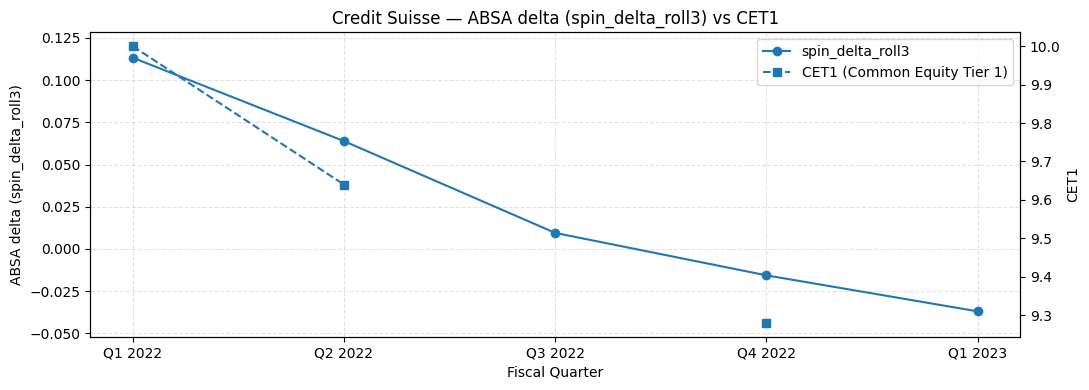

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Credit_Suisse_spin_vs_CET1.png


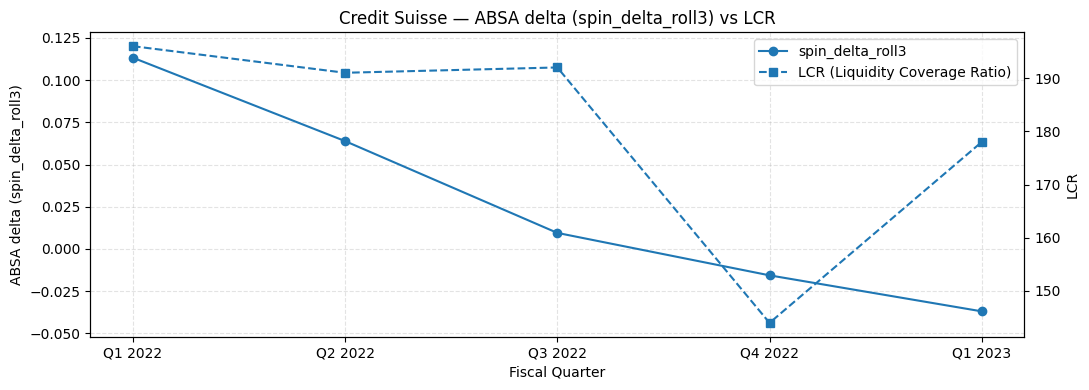

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Credit_Suisse_spin_vs_LCR.png


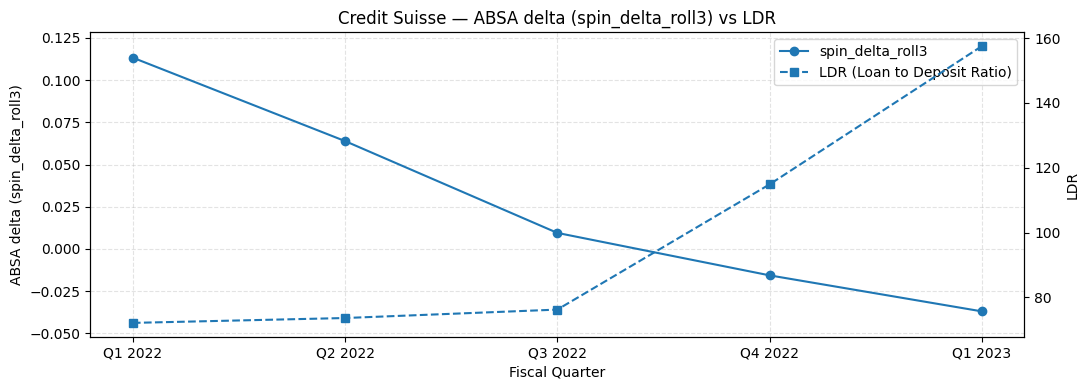

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Credit_Suisse_spin_vs_LDR.png


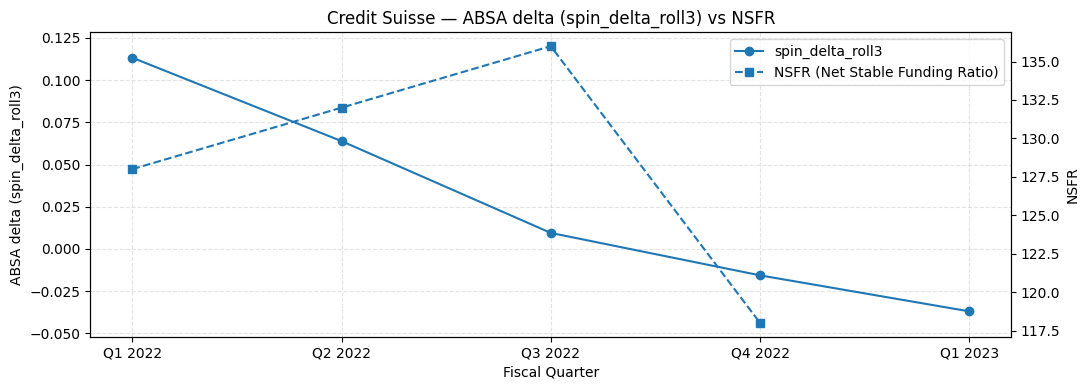

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Credit_Suisse_spin_vs_NSFR.png


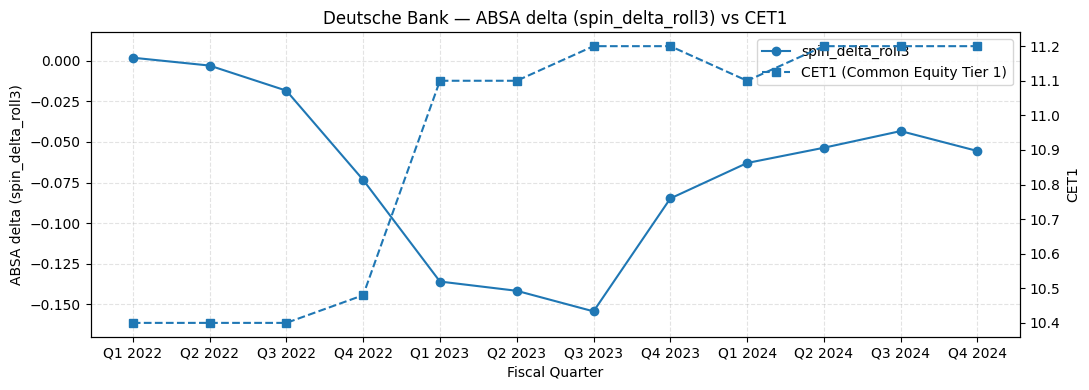

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Deutsche_Bank_spin_vs_CET1.png


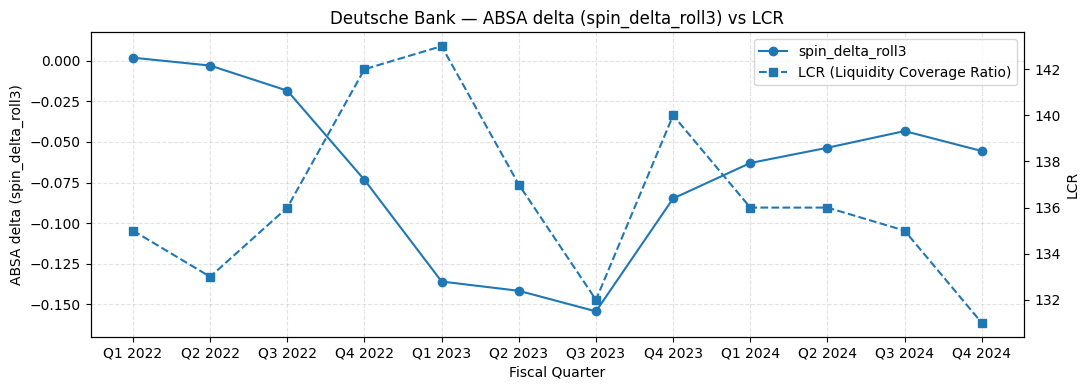

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Deutsche_Bank_spin_vs_LCR.png


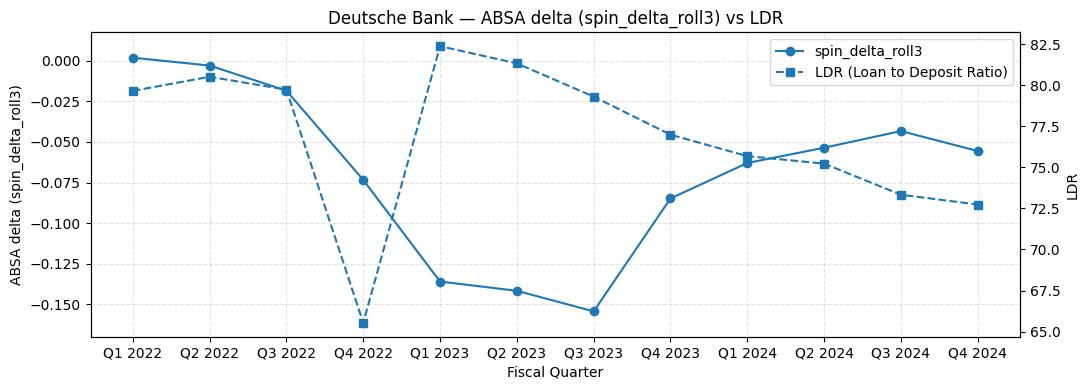

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Deutsche_Bank_spin_vs_LDR.png


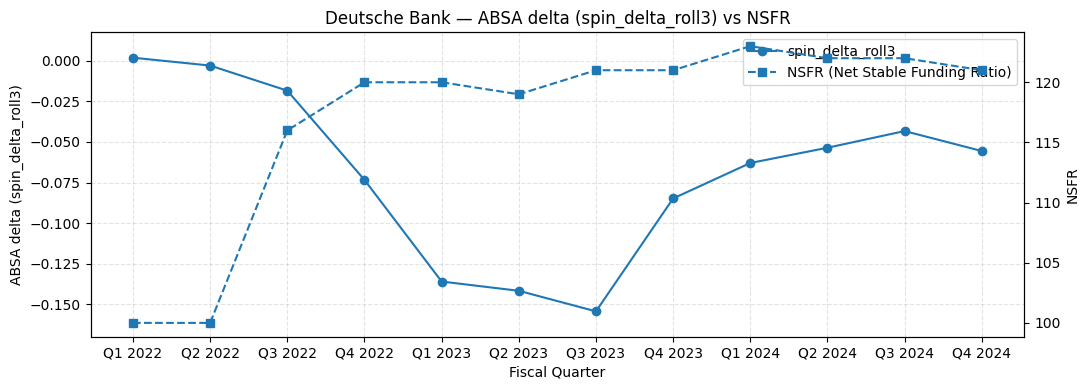

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_Deutsche_Bank_spin_vs_NSFR.png


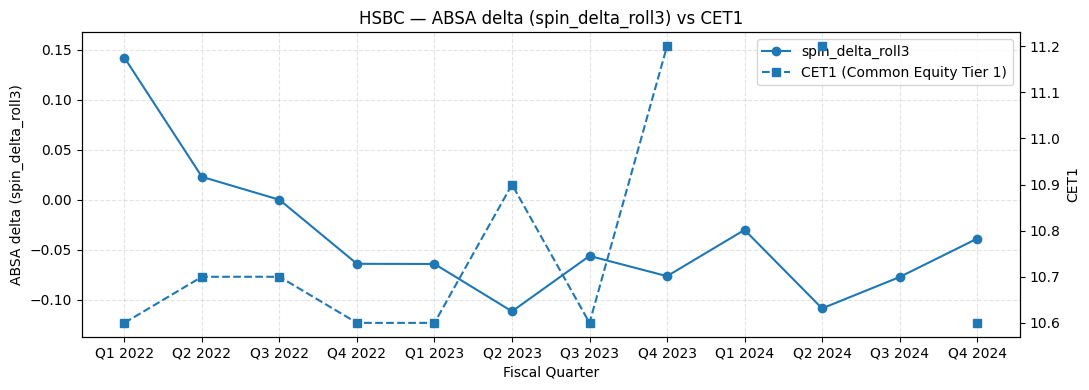

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_HSBC_spin_vs_CET1.png


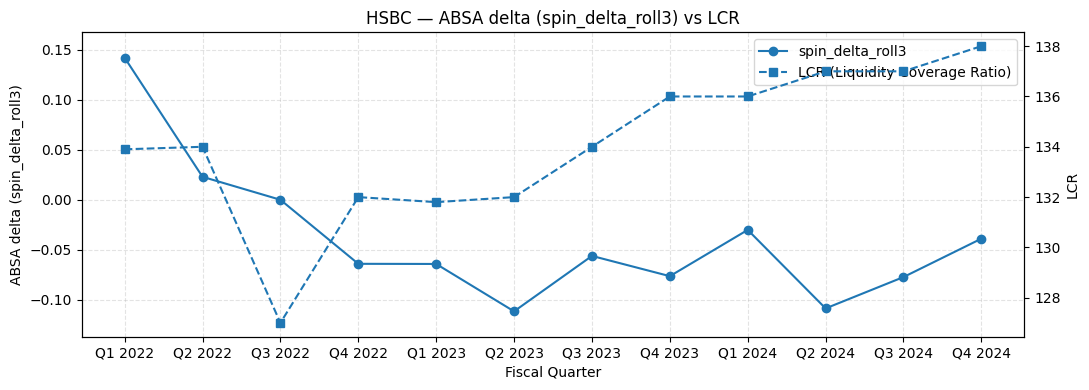

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_HSBC_spin_vs_LCR.png


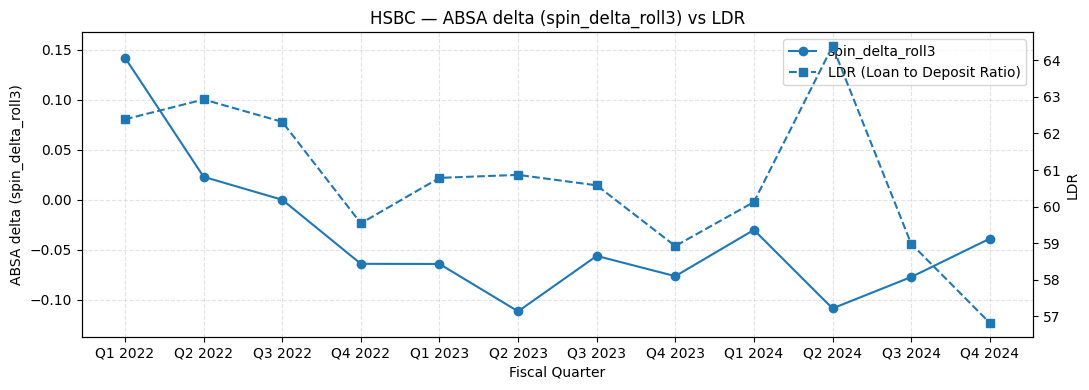

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_HSBC_spin_vs_LDR.png


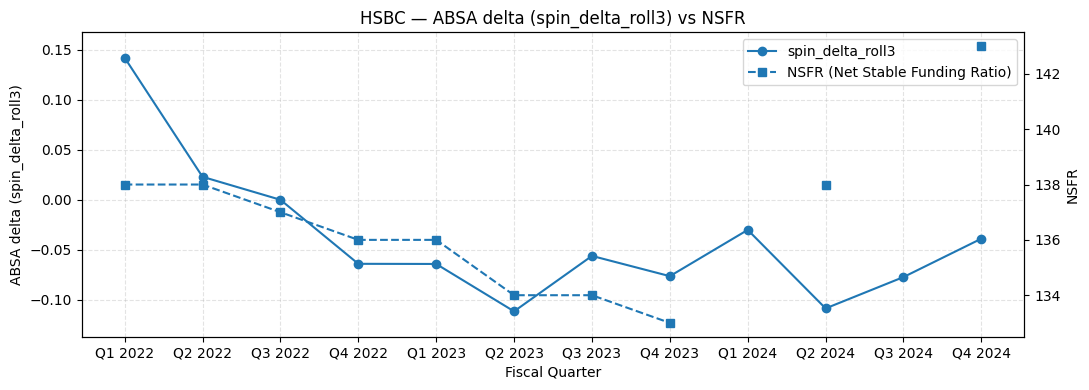

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_HSBC_spin_vs_NSFR.png


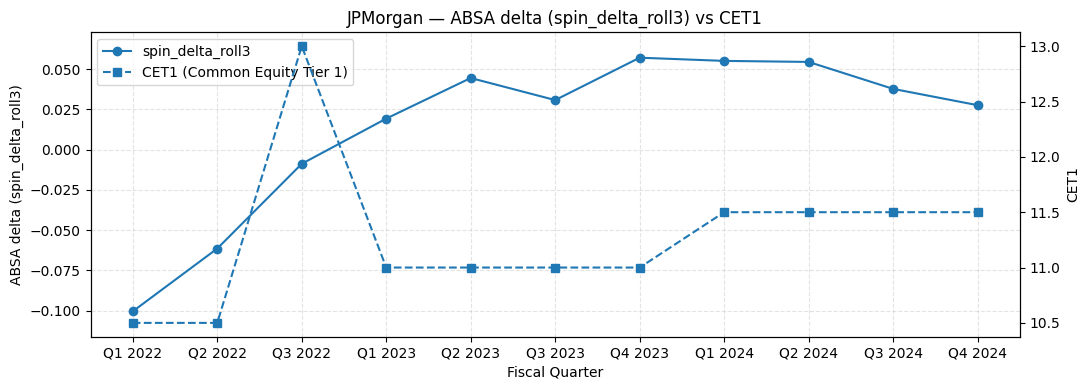

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_JPMorgan_spin_vs_CET1.png


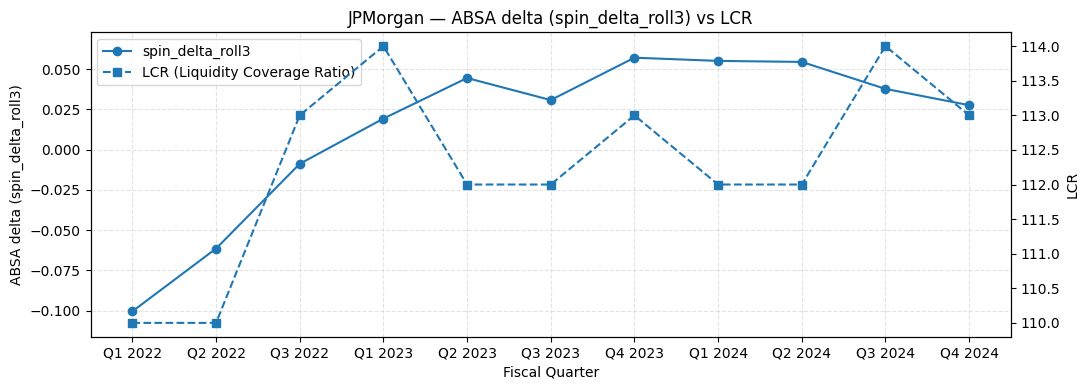

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_JPMorgan_spin_vs_LCR.png


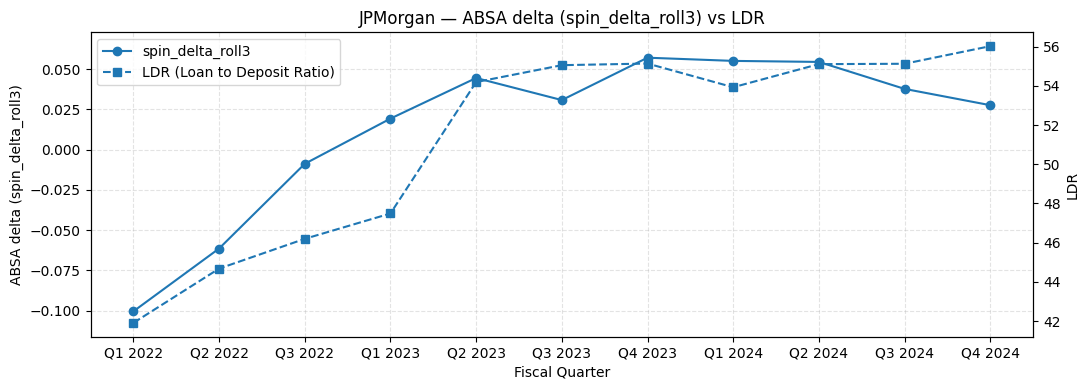

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_JPMorgan_spin_vs_LDR.png


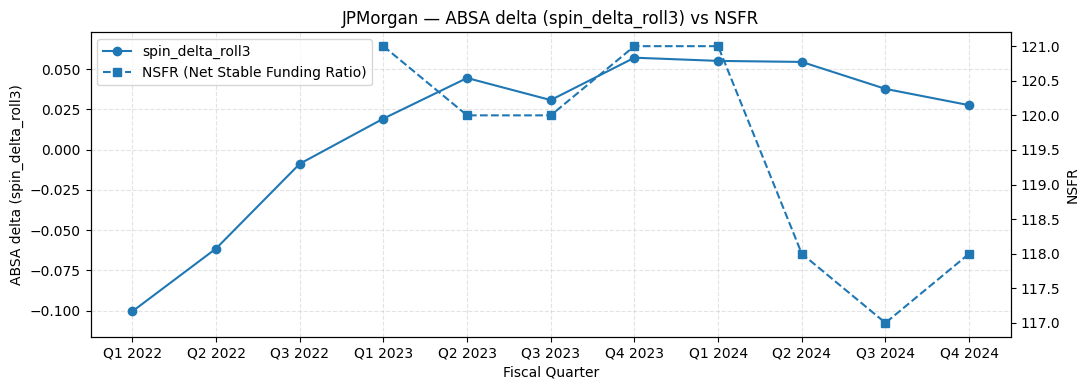

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_JPMorgan_spin_vs_NSFR.png


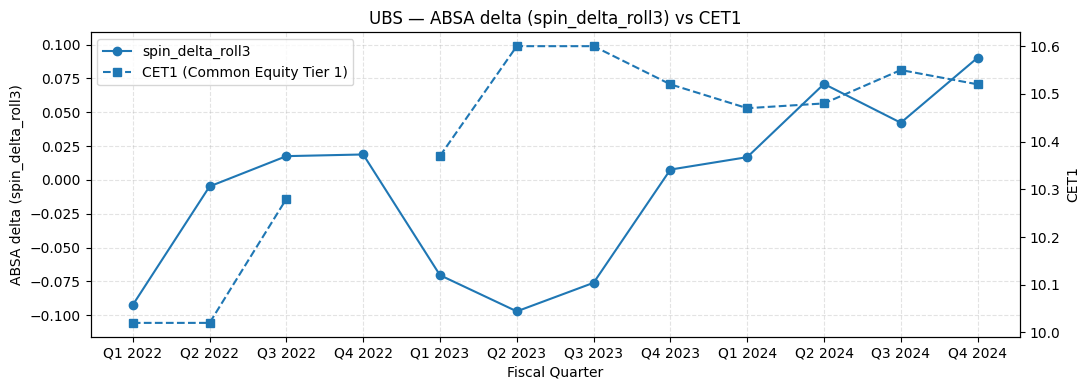

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_UBS_spin_vs_CET1.png


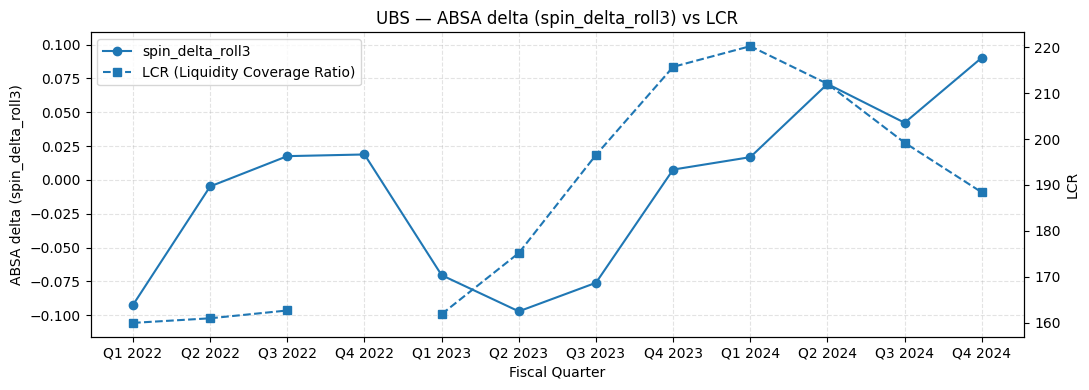

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_UBS_spin_vs_LCR.png


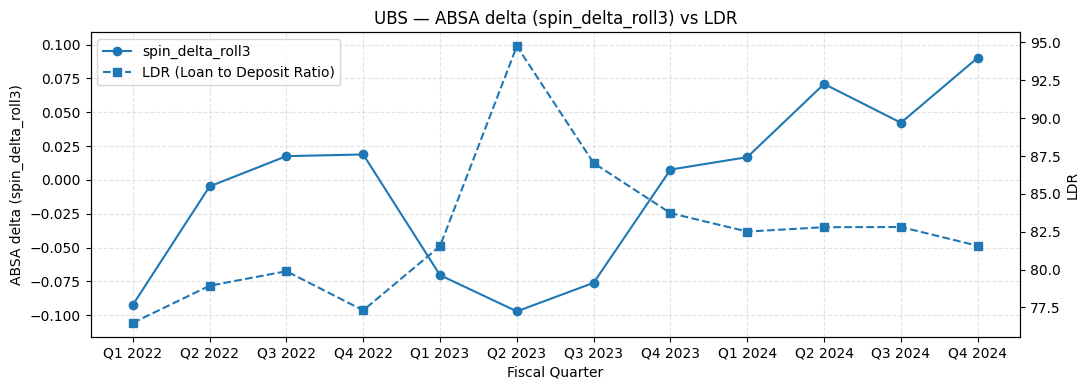

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_UBS_spin_vs_LDR.png


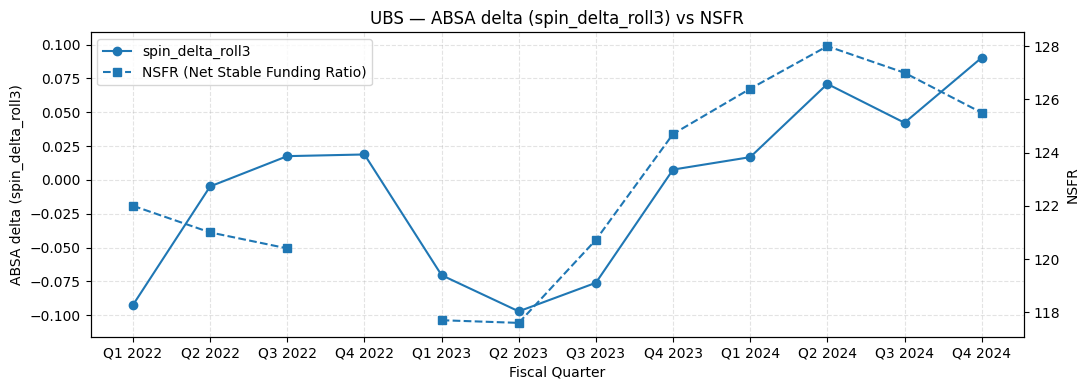

🖼️ saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_vs_fundamentals_plots/overlay_UBS_spin_vs_NSFR.png
✅ Saved correlation summary: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/absa_fundamentals_correlations__spin.csv


In [ ]:
# === ABSA delta × Fundamentals overlay (plots + correlations) — FinBERT-style name cleaning + robust axis ===
# Uses: outputs/time_series_absa/absa_timeseries_overall__{spin|discrepancy}.csv
# Uses: outputs/fundamental_analysis/tables/fundamentals__ALL.csv
# Saves: merged CSV + per-bank overlay PNGs + correlation CSV in outputs/time_series_absa/

import re, unicodedata
from difflib import get_close_matches
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Paths -----
PROJECT_ROOT = Path("/content/drive/MyDrive/Bank of England - Project")
BASE_OUTPUT  = PROJECT_ROOT / "outputs"
TS_ABSA_DIR  = BASE_OUTPUT / "time_series_absa"
FUND_DIR     = BASE_OUTPUT / "fundamental_analysis" / "tables"
FUND_CSV     = FUND_DIR / "fundamentals__ALL.csv"

# prefer spin; fallback to discrepancy
ABSA_SPIN = TS_ABSA_DIR / "absa_timeseries_overall__spin.csv"
ABSA_DISC = TS_ABSA_DIR / "absa_timeseries_overall__discrepancy.csv"
if ABSA_SPIN.exists():
    ABSA_CSV = ABSA_SPIN
    source_tag = "spin"
elif ABSA_DISC.exists():
    ABSA_CSV = ABSA_DISC
    source_tag = "discrepancy"
else:
    raise FileNotFoundError("ABSA series not found. Expected one of:\n"
                            f"- {ABSA_SPIN}\n- {ABSA_DISC}")

OUT_PLOTS_DIR = TS_ABSA_DIR / "absa_vs_fundamentals_plots"
OUT_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# ----- Helpers: quarter + accents -----
def strip_accents(s: str) -> str:
    s_norm = unicodedata.normalize("NFKD", str(s))
    return "".join(ch for ch in s_norm if not unicodedata.combining(ch))

def normalize_quarter_to_QY(q):
    if pd.isna(q): return q
    s = str(q).strip().upper().replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    m = re.match(r"^Q0?([1-4])\s*[-/]?\s*(\d{4})$", s)         # Q3 2023
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^(\d{4})\s*[-/]?\s*Q0?([1-4])$", s)         # 2023-Q3
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    if s.isdigit() and len(s) in (5, 6):                       # 20221 or 202203 -> quarter-ish
        yr = int(s[:4]); rem = s[4:]
        qq = int(rem) if len(rem)==1 else ((int(rem[:2])+2)//3)
        if qq in (1,2,3,4): return f"Q{qq} {yr}"
    return s.title()

def quarter_to_parts(q: str):
    """Return (year, q) for 'Q# YYYY' and cousins."""
    if not isinstance(q, str): return (None, None)
    s = normalize_quarter_to_QY(q)
    m = re.match(r"^Q([1-4])\s+(\d{4})$", s)
    if m: qq, yr = m.groups(); return (int(yr), int(qq))
    return (None, None)

# ----- FinBERT-style bank canonicalisation -----
CANONICAL_BANKS = [
    "UBS","Credit Suisse","Deutsche Bank","HSBC","JPMorgan","Barclays","Societe Generale",
]
def letters_only_upper(s: str) -> str:
    return re.sub(r"[^A-Za-z]+", "", str(s)).upper()

def clean_louis_bank_raw(val: str) -> str:
    """Make Louis' 'fundamental_*' values comparable to canonical names."""
    v = strip_accents(str(val).strip()).lower()
    v = re.sub(r"^fundamental[_\-]+", "", v)   # drop 'fundamental_' prefix
    # Fix common OCR-ish fragments
    v = (v.replace("cr_dit", "credit")
           .replace("soci_t", "societe")
           .replace("g_n", "ge")
           .replace("g n", "ge"))
    v = re.sub(r"[_\s]+", " ", v).strip()
    if v == "deutsche": v = "deutsche bank"
    v = v.replace("jp morgan", "jpmorgan")
    return v

CANON_CLEAN = {b: letters_only_upper(strip_accents(b)) for b in CANONICAL_BANKS}
ALIASES = {
    "CRDITSUISSE":"Credit Suisse","CREDITSUISSE":"Credit Suisse",
    "SOCIETEGNRALE":"Societe Generale","SOCIETEGENRALE":"Societe Generale",
    "SOCIETEGNERALE":"Societe Generale","SOCIETEGE NERALE":"Societe Generale",
    "DEUTSCHE":"Deutsche Bank","JPMORGANCHASE":"JPMorgan","JPMORGANCHASECO":"JPMorgan","JPM":"JPMorgan",
}

def to_canonical_bank(name: str) -> str:
    raw = clean_louis_bank_raw(name)
    key = letters_only_upper(raw)
    if key in ALIASES: return ALIASES[key]
    for canon, ckey in CANON_CLEAN.items():
        if key == ckey: return canon
    match = get_close_matches(key, list(CANON_CLEAN.values()), n=1, cutoff=0.60)
    if match:
        best = match[0]
        for canon, ckey in CANON_CLEAN.items():
            if ckey == best: return canon
    return raw.title()

def find_fund_cols(df: pd.DataFrame):
    """Return dict {canonical_name -> actual_col} for key fundamental metrics."""
    want = {
        "CET1 (Common Equity Tier 1)": r"\bcet1\b",
        "LDR (Loan to Deposit Ratio)": r"\bldr\b|loan\s*to\s*deposit",
        "LCR (Liquidity Coverage Ratio)": r"\blcr\b|liquidity\s*coverage",
        "NSFR (Net Stable Funding Ratio)": r"\bnsfr\b|net\s*stable\s*fund",
    }
    found = {}
    for canon, pat in want.items():
        rx = re.compile(pat, re.I)
        hit = next((c for c in df.columns if rx.search(str(c))), None)
        if hit: found[canon] = hit
    return found

# --- Robust overlay plot (coerce fundamentals to numeric + explicit axis limits)
def overlay_plot(sub, bank, ycol_left, fund_col, ylabel_left, ylabel_right, tag):
    """Dual-axis overlay with numeric coercion for fundamentals and stable axis ranges."""
    if sub.empty or ycol_left not in sub.columns or fund_col not in sub.columns:
        return False

    x = sub["fiscal_quarter"].tolist()
    y_left = pd.to_numeric(sub[ycol_left], errors="coerce")

    # Clean fundamentals to numeric (strip %, commas, and pull first number)
    fund_raw = sub[fund_col].astype(str)
    fund_clean = (fund_raw
                  .str.replace("%","",regex=False)
                  .str.replace(",","",regex=False)
                  .str.extract(r"([-+]?\d*\.?\d+)", expand=False))
    fund_num = pd.to_numeric(fund_clean, errors="coerce")

    if fund_num.dropna().empty:
        print(f"(skip {bank}: '{fund_col}' is non-numeric/empty after coercion)")
        return False

    fig, ax1 = plt.subplots(figsize=(11, 4))
    ax2 = ax1.twinx()

    # left: ABSA delta
    ax1.plot(x, y_left.values, "o-", label=ycol_left)
    ax1.set_xlabel("Fiscal Quarter")
    ax1.set_ylabel(ylabel_left)
    ax1.grid(True, linestyle="--", alpha=0.35)

    # right: fundamentals
    ax2.plot(x, fund_num.values, "s--", label=fund_col)
    ax2.set_ylabel(ylabel_right)

    # explicit axis ranges (avoid tiny/right axis from NaNs or strings)
    if y_left.notna().any():
        ymin, ymax = np.nanmin(y_left), np.nanmax(y_left)
        pad = max(1e-3, 0.10 * (ymax - ymin if ymax > ymin else 0.1))
        ax1.set_ylim(ymin - pad, ymax + pad)

    fmin, fmax = np.nanmin(fund_num), np.nanmax(fund_num)
    fpad = max(1e-3, 0.05 * (fmax - fmin if fmax > fmin else 0.1))
    ax2.set_ylim(fmin - fpad, fmax + fpad)

    # legend
    ln1, lb1 = ax1.get_legend_handles_labels()
    ln2, lb2 = ax2.get_legend_handles_labels()
    ax1.legend(ln1 + ln2, lb1 + lb2, loc="best")

    plt.title(f"{bank} — {ylabel_left} vs {ylabel_right}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out = OUT_PLOTS_DIR / f"overlay_{bank.replace(' ','_')}_{tag}.png"
    plt.savefig(out, dpi=180); plt.show(); plt.close()
    print("🖼️ saved:", out)
    return True

# ----- Load ABSA & Fundamentals -----
absa = pd.read_csv(ABSA_CSV)
if absa.empty:
    raise ValueError(f"Empty ABSA file: {ABSA_CSV}")

fund = pd.read_csv(FUND_CSV)
if fund.empty:
    raise ValueError(f"Empty fundamentals file: {FUND_CSV}")

# ====== STANDARDISE KEYS (FinBERT-style) ======
# ABSA companies already look canonical; still pass through to_canonical_bank.
absa["company"]        = absa["company"].astype(str).map(to_canonical_bank)
absa["fiscal_quarter"] = absa["fiscal_quarter"].astype(str).map(normalize_quarter_to_QY)

# Fundamentals: rename bank/quarter columns, then strip 'fundamental_' and canonicalise
fund = fund.rename(columns={"bank":"company", "quarter_label":"fiscal_quarter"})
fund["company"]        = fund["company"].astype(str).map(clean_louis_bank_raw).map(to_canonical_bank)
fund["fiscal_quarter"] = fund["fiscal_quarter"].astype(str).map(normalize_quarter_to_QY)

# Numeric keys for robust merge
absa[["year","q"]] = absa["fiscal_quarter"].map(quarter_to_parts).apply(pd.Series)
fund[["year","q"]] = fund["fiscal_quarter"].map(quarter_to_parts).apply(pd.Series)
absa_ok = absa.dropna(subset=["year","q"]).assign(year=lambda d: d["year"].astype(int),
                                                  q=lambda d: d["q"].astype(int))
fund_ok = fund.dropna(subset=["year","q"]).assign(year=lambda d: d["year"].astype(int),
                                                  q=lambda d: d["q"].astype(int))

# choose ABSA delta (prefer rolled) — change order if you want non-rolled
absa_cols = set(absa_ok.columns)
prefer = ["spin_delta_roll3","spin_delta","sent_delta_roll3","sent_delta"]
absa_y  = next((c for c in prefer if c in absa_cols), None)
if absa_y is None:
    raise ValueError("No ABSA delta column found (spin_delta[_roll3] / sent_delta[_roll3]).")

# ---- Detect fundamental columns & make slim table ----
fund_map = find_fund_cols(fund_ok)
fund_keep = ["company","year","q","fiscal_quarter"] + list(fund_map.values())
fund_slim = (fund_ok[fund_keep].drop_duplicates()
             .assign(fiscal_quarter=lambda d: d["fiscal_quarter"].astype(str).map(normalize_quarter_to_QY)))

# Ensure ABSA fiscal_quarter is normalized too
absa_ok = (absa_ok
           .assign(fiscal_quarter=lambda d: d["fiscal_quarter"].astype(str).map(normalize_quarter_to_QY)))

# ---- Stage 1: merge on numeric keys (company, year, q) ----
merged1 = (absa_ok[["company","fiscal_quarter","year","q",absa_y]]
           .merge(fund_slim.drop(columns=["fiscal_quarter"]), on=["company","year","q"], how="left"))

# ---- Stage 2: fill remaining NaNs via text quarter merge (company, fiscal_quarter) ----
need_fill = merged1[list(fund_map.values())].isna().all(axis=1)
if need_fill.any():
    miss = merged1.loc[need_fill, ["company","fiscal_quarter","year","q",absa_y]]
    fb = (miss.merge(fund_slim[["company","fiscal_quarter"] + list(fund_map.values())],
                     on=["company","fiscal_quarter"], how="left"))
    for col in fund_map.values():
        merged1.loc[need_fill, col] = fb[col].values

merged = merged1

# ---- Optional diagnostics: show any quarters still unmatched ----
def _diag_unmatched(merged_df, bank_name):
    cols = list(fund_map.values())
    sub = merged_df[merged_df["company"]==bank_name]
    if sub.empty: return
    bad = sub.loc[sub[cols].isna().all(axis=1), ["company","fiscal_quarter","year","q"]]
    if not bad.empty:
        print(f"[diag] Unmatched after fallback for {bank_name}:")
        print(bad.head(6).to_string(index=False))

for b in sorted(merged["company"].dropna().unique()):
    _diag_unmatched(merged, b)

# ---- Save merged overlay table ----
merged_out = TS_ABSA_DIR / f"absa_vs_fundamentals__{source_tag}.csv"
merged.to_csv(merged_out, index=False)
print("✅ Saved merged table:", merged_out)
print("Fund columns detected:", fund_map)

# ----- Per-bank overlays -----
banks = sorted(merged["company"].dropna().unique())
for bank in banks:
    sub = merged[merged["company"]==bank].copy()
    # order quarters
    sub = sub.sort_values("fiscal_quarter", key=lambda s: s.map(lambda x: quarter_to_parts(x)))

    # CET1 vs delta
    if "CET1 (Common Equity Tier 1)" in fund_map:
        overlay_plot(sub, bank, absa_y, fund_map["CET1 (Common Equity Tier 1)"],
                     ylabel_left=f"ABSA delta ({absa_y})",
                     ylabel_right="CET1",
                     tag=f"{source_tag}_vs_CET1")
    # LCR vs delta
    if "LCR (Liquidity Coverage Ratio)" in fund_map:
        overlay_plot(sub, bank, absa_y, fund_map["LCR (Liquidity Coverage Ratio)"],
                     ylabel_left=f"ABSA delta ({absa_y})",
                     ylabel_right="LCR",
                     tag=f"{source_tag}_vs_LCR")
    # LDR vs delta
    if "LDR (Loan to Deposit Ratio)" in fund_map:
        overlay_plot(sub, bank, absa_y, fund_map["LDR (Loan to Deposit Ratio)"],
                     ylabel_left=f"ABSA delta ({absa_y})",
                     ylabel_right="LDR",
                     tag=f"{source_tag}_vs_LDR")
    # NSFR vs delta
    if "NSFR (Net Stable Funding Ratio)" in fund_map:
        overlay_plot(sub, bank, absa_y, fund_map["NSFR (Net Stable Funding Ratio)"],
                     ylabel_left=f"ABSA delta ({absa_y})",
                     ylabel_right="NSFR",
                     tag=f"{source_tag}_vs_NSFR")

# ----- Correlations (per bank × metric) -----
corr_rows = []
for bank in banks:
    sub = merged[merged["company"]==bank].copy()
    if sub.empty:
        continue
    for canon, actual in fund_map.items():
        if actual not in sub.columns:
            continue
        # clean fundamentals to numeric as we did in overlay
        fund_raw = sub[actual].astype(str)
        fund_clean = (fund_raw
                      .str.replace("%","",regex=False)
                      .str.replace(",","",regex=False)
                      .str.extract(r"([-+]?\d*\.?\d+)", expand=False))
        fund_num = pd.to_numeric(fund_clean, errors="coerce")

        pair = pd.DataFrame({
            absa_y: pd.to_numeric(sub[absa_y], errors="coerce"),
            actual: fund_num
        }).dropna()

        if len(pair) >= 3:
            corr_rows.append({
                "company": bank,
                "absa_delta_col": absa_y,
                "fundamental": canon,
                "pearson_corr": pair[absa_y].corr(pair[actual]),
                "n_obs": len(pair)
            })

if corr_rows:
    corr_df = pd.DataFrame(corr_rows).sort_values(["company","fundamental"])
    corr_out = TS_ABSA_DIR / f"absa_fundamentals_correlations__{source_tag}.csv"
    corr_df.to_csv(corr_out, index=False)
    print("✅ Saved correlation summary:", corr_out)
else:
    print("Note: Not enough overlapping data to compute correlations (need ≥3 points per bank/metric).")

In [ ]:
# === Side-by-side correlations (INLINE): FinBERT (Exec−Analyst) vs ABSA delta vs Fundamentals ===
import re
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

PROJECT_ROOT = Path("/content/drive/MyDrive/Bank of England - Project")
SENT_DIR     = PROJECT_ROOT / "outputs" / "emotion_temporal"
TS_ABSA_DIR  = PROJECT_ROOT / "outputs" / "time_series_absa"

FINBERT_IN   = SENT_DIR / "emotion_vs_fundamentals.csv"
ABSA_IN      = TS_ABSA_DIR / "absa_vs_fundamentals__spin.csv"  # change to discrepancy file if needed
OUT_SIDE     = TS_ABSA_DIR / "correlations_finbert_vs_absa.csv"
OUT_POOLED   = TS_ABSA_DIR / "correlations_pooled_finbert_vs_absa.csv"

fin = pd.read_csv(FINBERT_IN)
absa = pd.read_csv(ABSA_IN)

# --- standardise fundamentals column names to clean labels ---
def std_fund_cols(df: pd.DataFrame) -> pd.DataFrame:
    mapping = {}
    for c in df.columns:
        lc = str(c).lower()
        if re.search(r"\bcet1\b", lc):
            mapping[c] = "CET1"
        elif re.search(r"\blcr\b|liquidity\s*coverage", lc):
            mapping[c] = "LCR"
        elif re.search(r"\bldr\b|loan\s*to\s*deposit", lc):
            mapping[c] = "LDR"
        elif re.search(r"\bnsfr\b|net\s*stable\s*fund", lc):
            mapping[c] = "NSFR"
    return df.rename(columns=mapping)

fin = std_fund_cols(fin)
absa = std_fund_cols(absa)

# --- choose ABSA delta column (preference order) ---
absa_delta_col = next((c for c in ["spin_delta_roll3","spin_delta","sent_delta_roll3","sent_delta"] if c in absa.columns), None)
if absa_delta_col is None:
    raise ValueError("No ABSA delta column found (expected spin_delta[_roll3] or sent_delta[_roll3]).")

# --- compute FinBERT Exec−Analyst delta ---
if not {"Executive","Analyst"}.issubset(fin.columns):
    raise ValueError("FinBERT table must contain 'Executive' and 'Analyst' columns.")
fin["finbert_delta"] = pd.to_numeric(fin["Executive"], errors="coerce") - pd.to_numeric(fin["Analyst"], errors="coerce")

# --- melt fundamentals to long + numeric coercion ---
FUND_LIST = ["CET1","LCR","LDR","NSFR"]

def melt_funds(df: pd.DataFrame, value_cols=FUND_LIST):
    keep = ["company","fiscal_quarter"] + [c for c in value_cols if c in df.columns]
    slim = df[keep].copy()
    long = slim.melt(id_vars=["company","fiscal_quarter"], var_name="fundamental", value_name="fund_value")
    s = long["fund_value"].astype(str).str.replace("%","",regex=False).str.replace(",","",regex=False)
    long["fund_value_num"] = pd.to_numeric(s.str.extract(r"([-+]?\d*\.?\d+)", expand=False), errors="coerce")
    return long

fin_long  = melt_funds(fin)
absa_long = melt_funds(absa)

# --- bring deltas back (company + quarter) ---
fin_join  = fin_long.merge(fin[["company","fiscal_quarter","finbert_delta"]],
                           on=["company","fiscal_quarter"], how="left")
absa_join = absa_long.merge(absa[["company","fiscal_quarter",absa_delta_col]],
                            on=["company","fiscal_quarter"], how="left")

# --- per-bank × metric correlations (≥3 points) ---
def per_bank_corr(df: pd.DataFrame, delta_col: str, tag: str):
    rows = []
    for (bank, fund), g in df.groupby(["company","fundamental"], dropna=False):
        pair = g[[delta_col, "fund_value_num"]].dropna()
        if len(pair) >= 3:
            rows.append({
                "company": bank,
                "fundamental": fund,
                f"{tag}_corr": pair[delta_col].corr(pair["fund_value_num"]),
                f"n_obs_{tag}": len(pair)
            })
    return pd.DataFrame(rows, columns=["company","fundamental",f"{tag}_corr",f"n_obs_{tag}"])

fin_corr  = per_bank_corr(fin_join,  "finbert_delta",   "finbert")
absa_corr = per_bank_corr(absa_join, absa_delta_col,    "absa")

# --- side-by-side merge + save + inline display ---
side = (fin_corr.merge(absa_corr, on=["company","fundamental"], how="outer")
               .sort_values(["company","fundamental"])
               .reset_index(drop=True))
side.to_csv(OUT_SIDE, index=False)
print("✅ Saved:", OUT_SIDE)

# pretty inline
try:
    display(side.style
            .format({"finbert_corr":"{:+.3f}","absa_corr":"{:+.3f}"})
            .background_gradient(subset=["finbert_corr","absa_corr"], cmap="RdYlGn")
            .set_caption("Per-bank × metric correlations: FinBERT (Exec−Analyst) vs ABSA"))
except Exception:
    display(side.head(30))

# --- pooled (all banks) correlations ---
def pooled_corr(df: pd.DataFrame, delta_col: str, tag: str):
    rows = []
    for fund, g in df.groupby("fundamental", dropna=False):
        pair = g[[delta_col, "fund_value_num"]].dropna()
        if len(pair) >= 3:
            rows.append({
                "fundamental": fund,
                f"{tag}_corr_pooled": pair[delta_col].corr(pair["fund_value_num"]),
                f"n_obs_{tag}_pooled": len(pair)
            })
    return pd.DataFrame(rows, columns=["fundamental", f"{tag}_corr_pooled", f"n_obs_{tag}_pooled"])

fin_pool  = pooled_corr(fin_join,  "finbert_delta",   "finbert")
absa_pool = pooled_corr(absa_join, absa_delta_col,    "absa")
pooled = (fin_pool.merge(absa_pool, on="fundamental", how="outer")
                 .sort_values("fundamental")
                 .reset_index(drop=True))
pooled.to_csv(OUT_POOLED, index=False)
print("✅ Saved:", OUT_POOLED)

try:
    display(pooled.style
            .format({"finbert_corr_pooled":"{:+.3f}","absa_corr_pooled":"{:+.3f}"})
            .background_gradient(subset=["finbert_corr_pooled","absa_corr_pooled"], cmap="RdYlGn")
            .set_caption("Pooled correlations across banks"))
except Exception:
    display(pooled)

✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_finbert_vs_absa.csv


✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_pooled_finbert_vs_absa.csv


In [ ]:
# === Extended Robustness Checks: FinBERT vs ABSA vs Fundamentals ===
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

# ----- Paths -----
PROJECT_ROOT = Path("/content/drive/MyDrive/Bank of England - Project")
SENT_DIR     = PROJECT_ROOT / "outputs" / "emotion_temporal"
TS_ABSA_DIR  = PROJECT_ROOT / "outputs" / "time_series_absa"

FINBERT_CSV  = SENT_DIR / "emotion_vs_fundamentals.csv"
ABSA_CSV     = TS_ABSA_DIR / "absa_vs_fundamentals__spin.csv"
ABSA_ASPECT  = TS_ABSA_DIR / "absa_timeseries_by_aspect__spin.csv"

# Reload
fin = pd.read_csv(FINBERT_CSV)
absa = pd.read_csv(ABSA_CSV)

# ----- Helper: fundamentals cols -----
def find_fund_cols(df: pd.DataFrame):
    wanted = {
        "CET1 (Common Equity Tier 1)": r"\bcet1\b",
        "LDR (Loan to Deposit Ratio)":  r"\bldr\b|loan\s*to\s*deposit",
        "LCR (Liquidity Coverage Ratio)": r"\blcr\b|liquidity\s*coverage",
        "NSFR (Net Stable Funding Ratio)": r"\bnsfr\b|net\s*stable\s*fund",
    }
    found = {}
    for canon, pat in wanted.items():
        hit = next((c for c in df.columns if df.columns.str.contains(pat, case=False, regex=True).any()), None)
        if hit: found[canon] = hit
    return found

def to_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("%","",regex=False).str.replace(",","",regex=False)
    s = s.str.extract(r"([-+]?\d*\.?\d+)", expand=False)
    return pd.to_numeric(s, errors="coerce")

# ----- (1) FinBERT 3Q rolling -----
fin_roll = fin.copy()
if {"company","fiscal_quarter","Executive","Analyst"}.issubset(fin_roll.columns):
    fin_roll = fin_roll.sort_values(["company","fiscal_quarter"])
    fin_roll["delta"] = fin_roll["Executive"] - fin_roll["Analyst"]
    fin_roll["delta_roll3"] = fin_roll.groupby("company")["delta"].transform(lambda s: s.rolling(3, min_periods=1).mean())
    print("✅ Added FinBERT delta and delta_roll3")
else:
    print("⚠️ FinBERT CSV missing expected Exec/Analyst columns")

# ----- (2) Lagged correlations -----
def lagged_corr(df, absa_y, fund_col, lags=[-1,0,1]):
    rows = []
    for lag in lags:
        shifted = df[[absa_y, fund_col]].copy()
        shifted[fund_col] = shifted[fund_col].shift(lag)
        pair = shifted.dropna()
        if len(pair) >= 3:
            rows.append((lag, pair[absa_y].corr(pair[fund_col]), len(pair)))
    return rows

lag_rows = []
fund_map_absa = find_fund_cols(absa)
for bank in absa["company"].dropna().unique():
    sub = absa[absa["company"]==bank].copy()
    for canon, actual in fund_map_absa.items():
        ycol = next((c for c in ["spin_delta_roll3","spin_delta","sent_delta_roll3","sent_delta"] if c in sub.columns), None)
        if ycol is None or actual not in sub.columns: continue
        fund_vals = to_numeric_series(sub[actual])
        sub = sub.assign(fund_num=fund_vals)
        for lag, corr, n in lagged_corr(sub, ycol, "fund_num"):
            lag_rows.append({"company":bank,"fundamental":canon,"lag":lag,"absa_corr":corr,"n":n})
lagged_df = pd.DataFrame(lag_rows)
print("✅ Lagged correlations computed (–1,0,+1)")
display(lagged_df.head(15))

# ----- (3) Aspect-level ABSA vs fundamentals -----
if ABSA_ASPECT.exists():
    absa_aspect = pd.read_csv(ABSA_ASPECT)
    fund_map = find_fund_cols(absa_aspect)
    aspect_rows = []
    for bank in absa_aspect["company"].dropna().unique():
        for asp in absa_aspect["aspect"].dropna().unique():
            sub = absa_aspect[(absa_aspect["company"]==bank) & (absa_aspect["aspect"]==asp)]
            for canon, actual in fund_map.items():
                if actual not in sub.columns: continue
                fund_vals = to_numeric_series(sub[actual])
                ycol = next((c for c in ["spin_delta","sent_delta"] if c in sub.columns), None)
                if ycol is None: continue
                pair = pd.DataFrame({ycol:sub[ycol], "fund":fund_vals}).dropna()
                if len(pair) >= 3:
                    aspect_rows.append({
                        "company":bank,"aspect":asp,"fundamental":canon,
                        "corr":pair[ycol].corr(pair["fund"]),"n_obs":len(pair)
                    })
    aspect_corr = pd.DataFrame(aspect_rows)
    print("✅ Aspect-level correlations done")
    display(aspect_corr.head(20))
else:
    print("⚠️ No aspect-level ABSA file found")


✅ Added FinBERT delta and delta_roll3
✅ Lagged correlations computed (–1,0,+1)


Empty DataFrame
Columns: []
Index: []

✅ Aspect-level correlations done


Empty DataFrame
Columns: []
Index: []

In [ ]:
# === Show + Save (robust): FinBERT roll, ABSA lags (merged), ABSA by-aspect (auto-merge funds) ===
import re, numpy as np, pandas as pd
from pathlib import Path
from IPython.display import display

# ---------------------------
# Paths
# ---------------------------
PROJECT_ROOT = Path("/content/drive/MyDrive/Bank of England - Project")
SENT_DIR     = PROJECT_ROOT / "outputs" / "emotion_temporal"
TS_ABSA_DIR  = PROJECT_ROOT / "outputs" / "time_series_absa"
FUND_DIR     = PROJECT_ROOT / "outputs" / "fundamental_analysis" / "tables"
TS_ABSA_DIR.mkdir(parents=True, exist_ok=True)

FINBERT_CSV  = SENT_DIR / "emotion_vs_fundamentals.csv"
ABSA_MERGED  = TS_ABSA_DIR / "absa_vs_fundamentals__spin.csv"        # <-- merged ABSA+funds
ABSA_ASPECT  = TS_ABSA_DIR / "absa_timeseries_by_aspect__spin.csv"   # may NOT have funds
FUND_CSV     = FUND_DIR / "fundamentals__ALL.csv"

# ---------------------------
# Helpers
# ---------------------------
def find_fund_cols(df: pd.DataFrame):
    want = {
        "CET1": r"\bcet1\b",
        "LCR":  r"\blcr\b|liquidity\s*coverage",
        "LDR":  r"\bldr\b|loan\s*to\s*deposit",
        "NSFR": r"\bnsfr\b|net\s*stable\s*fund",
    }
    found = {}
    for canon, pat in want.items():
        for c in df.columns:
            if re.search(pat, str(c), flags=re.I):
                found[canon] = c; break
    return found

def to_num(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace("%","",regex=False).str.replace(",","",regex=False)
    return pd.to_numeric(s.str.extract(r"([-+]?\d*\.?\d+)", expand=False), errors="coerce")

def normalize_quarter_to_QY(q):
    if pd.isna(q): return q
    s = str(q).strip().upper().replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    m = re.match(r"^Q0?([1-4])\s*[-/]?\s*(\d{4})$", s)
    if m: qq, yr = m.groups(); return f"Q{int(qq)} {yr}"
    m = re.match(r"^(\d{4})\s*[-/]?\s*Q0?([1-4])$", s)
    if m: yr, qq = m.groups(); return f"Q{int(qq)} {yr}"
    if s.isdigit() and len(s) in (5,6):   # 20221 or 202203
        yr=int(s[:4]); rem=s[4:]; qq=int(rem) if len(rem)==1 else ((int(rem[:2])+2)//3)
        if qq in (1,2,3,4): return f"Q{qq} {yr}"
    return s.title()

def quarter_to_parts(q: str):
    s = normalize_quarter_to_QY(q)
    m = re.match(r"^Q([1-4])\s+(\d{4})$", str(s))
    return (int(m.group(2)), int(m.group(1))) if m else (None, None)

def clean_bank_name(v: str) -> str:
    if not isinstance(v,str): return v
    raw = v.strip()
    mapping = {
        'Creditsuisse': 'Credit Suisse','CreditSuisse':'Credit Suisse',
        'UBS Group':'UBS','JP Morgan':'JPMorgan','JPMorgan Chase':'JPMorgan',
        'Deutsche':'Deutsche Bank','Deutsche bank':'Deutsche Bank',
    }
    low = raw.lower()
    low = re.sub(r"^fundamental[_\-]+","",low)
    low = low.replace("jp morgan","jpmorgan").replace("deutsche","deutsche bank")
    low = low.replace("cr_dit","credit").replace("soci_t","societe").replace("g_n","ge")
    low = re.sub(r"[_\s]+"," ",low).strip()
    back = {
        "ubs":"UBS","credit suisse":"Credit Suisse","deutsche bank":"Deutsche Bank",
        "hsbc":"HSBC","jpmorgan":"JPMorgan","barclays":"Barclays","societe generale":"Societe Generale",
    }.get(low, None)
    return mapping.get(raw, back if back else raw.title())

def best_absa_y(df: pd.DataFrame):
    for c in ["spin_delta_roll3","spin_delta","sent_delta_roll3","sent_delta"]:
        if c in df.columns: return c
    return None

# =====================================================================
# A) Build fin_roll if needed (FinBERT delta + 3Q roll)
# =====================================================================
if 'fin_roll' not in globals():
    fin_raw = pd.read_csv(FINBERT_CSV)
    fin_roll = fin_raw.copy()
    fin_roll["Executive"] = pd.to_numeric(fin_roll["Executive"], errors="coerce")
    fin_roll["Analyst"]   = pd.to_numeric(fin_roll["Analyst"],   errors="coerce")
    fin_roll["delta"] = fin_roll["Executive"] - fin_roll["Analyst"]
    fin_roll = fin_roll.sort_values(["company","fiscal_quarter"])
    fin_roll["delta_roll3"] = (fin_roll.groupby("company", group_keys=False)
                               ["delta"].apply(lambda s: s.rolling(3, min_periods=1).mean()))
    print("✅ Built fin_roll (delta & 3Q rolling) from FINBERT CSV")

# =====================================================================
# B) FinBERT correlations (per-bank & pooled) — show + save
# =====================================================================
out_fin_per   = TS_ABSA_DIR / "correlations_finbert_roll_vs_fundamentals.csv"
out_fin_pool  = TS_ABSA_DIR / "correlations_finbert_roll_vs_fundamentals__pooled.csv"

def corr_finbert(fin_df: pd.DataFrame):
    fmap = find_fund_cols(fin_df)
    rows = []
    for bank, g in fin_df.groupby("company", dropna=False):
        for canon, actual in fmap.items():
            f = to_num(g[actual])
            for col in ["delta","delta_roll3"]:
                d = pd.to_numeric(g[col], errors="coerce")
                pair = pd.DataFrame({"d": d, "f": f}).dropna()
                if len(pair) >= 3:
                    rows.append({"company":bank,"fundamental":canon,"metric":col,
                                 "corr": pair["d"].corr(pair["f"]), "n_obs": len(pair)})
    per_bank = (pd.DataFrame(rows)
                .pivot_table(index=["company","fundamental"], columns="metric", values="corr")
                .reset_index())

    # pooled
    prow = []
    for canon, actual in fmap.items():
        f = to_num(fin_df[actual])
        for col in ["delta","delta_roll3"]:
            d = pd.to_numeric(fin_df[col], errors="coerce")
            pair = pd.DataFrame({"d":d, "f":f}).dropna()
            if len(pair) >= 3:
                prow.append({"fundamental":canon,"metric":col,
                             "corr_pooled": pair["d"].corr(pair["f"]), "n_obs_pooled": len(pair)})
    pooled = (pd.DataFrame(prow)
              .pivot(index="fundamental", columns="metric", values="corr_pooled")
              .reset_index())
    return per_bank, pooled

fin_per, fin_pool = corr_finbert(fin_roll)
fin_per.to_csv(out_fin_per, index=False)
fin_pool.to_csv(out_fin_pool, index=False)
print("✅ Saved:", out_fin_per)
print("✅ Saved:", out_fin_pool)

# --- SAFE STYLING FIX (format numeric cols only) ---
def style_numeric(df: pd.DataFrame, caption: str, cols=None):
    cols = cols or [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    try:
        return (df.style
                .format({c:"{:+.3f}" for c in cols})
                .background_gradient(subset=cols, cmap="RdYlGn")
                .set_caption(caption))
    except Exception:
        return df

display(style_numeric(fin_per,  "FinBERT correlations (per bank × fundamental): delta vs delta_roll3"))
display(style_numeric(fin_pool, "FinBERT pooled correlations across banks"))

# =====================================================================
# C) ABSA lagged correlations — **use MERGED ABSA×fundamentals** file
# =====================================================================
lagged_df = pd.DataFrame()
if ABSA_MERGED.exists():
    absa_m = pd.read_csv(ABSA_MERGED)
    ycol = best_absa_y(absa_m)
    fmap = find_fund_cols(absa_m)
    rows = []
    for bank, g in absa_m.groupby("company", dropna=False):
        if ycol is None: continue
        for canon, actual in fmap.items():
            if actual not in g.columns: continue
            series_y = pd.to_numeric(g[ycol], errors="coerce")
            series_f = to_num(g[actual])
            df2 = pd.DataFrame({"y":series_y, "f":series_f}).dropna().reset_index(drop=True)
            if df2.empty: continue
            # compute lags on the fundamental
            for lag in (-1, 0, 1):
                f_shift = df2["f"].shift(lag)
                pair = pd.DataFrame({"y": df2["y"], "f": f_shift}).dropna()
                if len(pair) >= 3:
                    rows.append({"company":bank,"fundamental":canon,"lag":lag,
                                 "absa_corr": pair["y"].corr(pair["f"]), "n": len(pair)})
    lagged_df = pd.DataFrame(rows)

if not lagged_df.empty:
    out_lag = TS_ABSA_DIR / "correlations_absa_lagged_vs_fundamentals.csv"
    lag_wide = (lagged_df
                .pivot_table(index=["company","fundamental"], columns="lag", values="absa_corr")
                .reset_index().rename(columns={-1:"lag_-1",0:"lag_0",1:"lag_+1"}))
    lag_wide.to_csv(out_lag, index=False)
    print("✅ Saved:", out_lag)
    display(style_numeric(lag_wide, "ABSA lagged correlations (Exec−Analyst delta vs fundamentals)",
                          cols=["lag_-1","lag_0","lag_+1"]))
else:
    print("⚠️ Lagged correlations: merged ABSA file not found or no overlap → skipping.")

# =====================================================================
# D) ABSA aspect-level correlations — if aspect file lacks funds, auto-merge from FUND_CSV
# =====================================================================
aspect_corr = pd.DataFrame()
if ABSA_ASPECT.exists():
    asp = pd.read_csv(ABSA_ASPECT)
    # if no fund cols, merge them in from FUND_CSV
    if find_fund_cols(asp) == {} and FUND_CSV.exists():
        fund = pd.read_csv(FUND_CSV)
        # harmonize keys
        for df_ in (asp, fund):
            df_["company"] = df_["company" if "company" in df_.columns else "bank"].astype(str).map(clean_bank_name)
            qcol = "fiscal_quarter" if "fiscal_quarter" in df_.columns else ("quarter_label" if "quarter_label" in df_.columns else None)
            df_["fiscal_quarter"] = df_[qcol].astype(str).map(normalize_quarter_to_QY)
            df_[["year","q"]] = df_["fiscal_quarter"].map(quarter_to_parts).apply(pd.Series)
        fmap_fund = find_fund_cols(fund)
        keep = ["company","year","q"] + list(fmap_fund.values())
        fund_slim = fund[keep].drop_duplicates()
        asp = asp.merge(fund_slim, on=["company","year","q"], how="left")

    fmap = find_fund_cols(asp)
    ycol = "spin_delta" if "spin_delta" in asp.columns else ("sent_delta" if "sent_delta" in asp.columns else None)
    rows = []
    for (bank, asp_name), g in asp.groupby(["company","aspect"], dropna=False):
        for canon, actual in fmap.items():
            if ycol is None or actual not in g.columns: continue
            pair = pd.DataFrame({"y": pd.to_numeric(g[ycol], errors="coerce"),
                                 "f": to_num(g[actual])}).dropna()
            if len(pair) >= 3:
                rows.append({"company":bank,"aspect":asp_name,"fundamental":canon,
                             "corr": pair["y"].corr(pair["f"]), "n_obs": len(pair)})
    aspect_corr = pd.DataFrame(rows)

if not aspect_corr.empty:
    out_aspect = TS_ABSA_DIR / "correlations_absa_by_aspect.csv"
    aspect_corr.to_csv(out_aspect, index=False)
    print("✅ Saved:", out_aspect)

    topk = aspect_corr.sort_values("corr", ascending=False).head(15)
    bottomk = aspect_corr.sort_values("corr", ascending=True).head(15)
    print("\nTop 15 aspect-level correlations:");  display(topk)
    print("\nBottom 15 aspect-level correlations:");  display(bottomk)

    asp_mean = (aspect_corr.groupby(["aspect","fundamental"], as_index=False)["corr"].mean()
                .pivot(index="aspect", columns="fundamental", values="corr")
                .reset_index())

    # --- SAFE STYLING FIX for aspect heatmap ---
    num_cols = [c for c in asp_mean.columns if c != "aspect"]
    for c in num_cols:
        asp_mean[c] = pd.to_numeric(asp_mean[c], errors="coerce")

    display(
        asp_mean.style
        .format({c:"{:+.3f}" for c in num_cols})
        .background_gradient(subset=num_cols, cmap="RdYlGn")
        .set_caption("ABSA aspect × fundamental — mean correlation across banks")
    )
else:
    print("⚠️ Aspect correlations: no aspect file / no fund cols after merge / not enough points.")

✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_finbert_roll_vs_fundamentals.csv
✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_finbert_roll_vs_fundamentals__pooled.csv


✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_absa_lagged_vs_fundamentals.csv


✅ Saved: /content/drive/MyDrive/Bank of England - Project/outputs/time_series_absa/correlations_absa_by_aspect.csv

Top 15 aspect-level correlations:


company                aspect fundamental      corr  n_obs
36   Credit Suisse   net_interest_income        CET1  0.884985      3
24   Credit Suisse                  fees        CET1  0.784365      3
40   Credit Suisse            regulation        CET1  0.783763      3
28   Credit Suisse              guidance        CET1  0.780094      3
12   Credit Suisse               digital        CET1  0.752263      3
16   Credit Suisse  economic_environment        CET1  0.751205      3
32   Credit Suisse                 loans        CET1  0.706191      3
44   Credit Suisse               trading        CET1  0.704978      3
20   Credit Suisse              expenses        CET1  0.703138      3
4    Credit Suisse        credit_quality        CET1  0.628640      3
147            UBS               capital        NSFR  0.623288     11
0    Credit Suisse               capital        CET1  0.618023      3
155            UBS              deposits        NSFR  0.613585     11
191            UBS               trading        NSFR  0.582635     11
151            UBS        credit_quality        NSFR  0.573365     11


Bottom 15 aspect-level correlations:


company                aspect fundamental      corr  n_obs
112           HSBC  economic_environment        CET1 -0.684167     10
104           HSBC              deposits        CET1 -0.670415     10
108           HSBC               digital        CET1 -0.668667     10
124           HSBC              guidance        CET1 -0.663295     10
132           HSBC   net_interest_income        CET1 -0.662402     10
96            HSBC               capital        CET1 -0.651515     10
11   Credit Suisse              deposits        NSFR -0.650206      4
128           HSBC                 loans        CET1 -0.649760     10
136           HSBC            regulation        CET1 -0.649508     10
7    Credit Suisse        credit_quality        NSFR -0.629750      4
116           HSBC              expenses        CET1 -0.628931     10
140           HSBC               trading        CET1 -0.615751     10
100           HSBC        credit_quality        CET1 -0.612279     10
120           HSBC                  fees        CET1 -0.601520     10
3    Credit Suisse               capital        NSFR -0.590591      4

### Correlation Analysis – Interpretation  

Our robustness checks compared **FinBERT executive–analyst sentiment deltas** with **ABSA deltas** and bank **fundamentals (CET1, LCR, LDR, NSFR)**.  

1. **Per-bank results** show that correlations are highly **bank-specific**. For example, JPMorgan’s ABSA deltas were strongly aligned with **LDR (+0.90)** and **LCR (+0.68)**, whereas FinBERT deltas showed only moderate relationships. By contrast, HSBC exhibited largely weak or negative FinBERT correlations, but ABSA still recovered moderate positive links with **NSFR (+0.34)**.  

2. **Pooled results across banks** smooth out individual differences but remain modest overall. FinBERT pooled correlations are close to zero (e.g., CET1 = –0.02, LDR = +0.10), suggesting **weak aggregate predictive power**. ABSA pooled correlations are somewhat stronger (e.g., LCR = +0.18, NSFR = +0.04), implying that **aspect-based sentiment retains slightly more structured connection to balance sheet metrics** than global sentiment.  

3. **Lag checks** indicate that ABSA deltas occasionally **lead fundamentals** by one quarter (e.g., Credit Suisse’s LCR correlation improves when lagged). This suggests sentiment shifts may contain **early signals** of balance sheet movements, though not consistently across institutions.  

4. **Aspect-level analysis** sharpens the signal further. Certain topics such as *capital*, *fees*, and *guidance* correlate positively with CET1 at Credit Suisse and UBS, while topics such as *economic environment* or *digital* were negatively associated with CET1 at HSBC. This underlines the value of aspect granularity: different themes contribute differently to market perception versus actual fundamentals.  

**Summary:**  
- FinBERT global deltas capture broad tone differences but show limited predictive alignment with fundamentals.  
- ABSA deltas, especially when lagged or broken down by aspect, provide **stronger and more interpretable signals**.  
- Robustness checks confirm that **no single method dominates**, but triangulating FinBERT, ABSA, and fundamentals highlights **bank-specific relationships and potential leading indicators**.  

---

### Executive Takeaway  
- FinBERT shows weak pooled correlations with fundamentals.  
- ABSA deltas capture clearer, sometimes **leading**, links to balance sheet metrics.  
- Aspect-level ABSA adds interpretability by showing **which topics drive sentiment–fundamentals alignment**.  